## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Utility functions

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

# Heuristic solution

hand-tuned function to generate actions for agents

In [4]:
def heuristic(agent_id, pos, img_st, seen_fire, center, close_agent_id, close_pos):

    traj = []
    actions = []
    traj.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    action_set = [4,1,2,3,5,8,7,6]
    
    dists = None
    x,y = pos

    r = img_dim//2
    c = img_dim//2

    if img_st[r,c] in [1,2] or seen_fire:
        seen_fire = True
        dists = []
        
        cen_vec = np.array([x-center,y-center])
        cen_vec = cen_vec/np.linalg.norm(cen_vec)
        for a in range(1,9):
        #for a in [2,5,7,4]:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]

            rl = -new_pos[1] + y + img_dim//2
            cl = new_pos[0] -x + img_dim//2
            #if a in [1,3,8,6] and img_st[rl,cl] in [0]:
            #    continue

            move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
            if a != 0:
                move_vec = move_vec/np.linalg.norm(move_vec)
            dists.append((np.cross(cen_vec,move_vec),new_pos,a))

        cir_pos = min(dists)[1]
        cir_act = min(dists)[2]

        ri = -cir_pos[1] + y + img_dim//2
        ci = cir_pos[0] -x + img_dim//2

        left_act = None
        if cir_act==1:
            left_act = [6,4]
            #left_act = [4]
            righ_act = [2]
        elif cir_act==2:
            left_act = [4,1]
            #left_act = [1]
            righ_act = [3]
        elif cir_act==3:
            left_act = [1,2]
            #left_act = [2]
            righ_act = [5]
        elif cir_act==5:
            left_act = [2,3]
            #left_act = [3]
            righ_act = [8]
        elif cir_act==8:
            left_act = [3,5]
            #left_act = [5]
            righ_act = [7]
        elif cir_act==7:
            left_act = [5,8]
            #left_act = [8]
            righ_act = [6]
        elif cir_act==6:
            left_act = [8,7]
            #left_act = [7]
            righ_act = [4]
        elif cir_act==4:
            left_act = [7,6]
            #left_act = [6]
            righ_act = [1]

        '''
        left_act = None
        if cir_act==2:
            #left_act = [3]
            left_act = [1]
        elif cir_act==5:
            #left_act = [8]
            left_act = [3]
        elif cir_act==7:
            #left_act = [6]
            left_act = [8]
        elif cir_act==4:
            #left_act = [1]
            left_act = [6]
        '''    
        #print(cir_act)
        #print(left_act)

        '''
        out_pos = actions_to_trajectory(traj[-1],[left_act[0]])[1]
        ro = -out_pos[1] + y + img_dim//2
        co = out_pos[0] - x + img_dim//2
        if img_st[ro,co] in [1,2]:
            cir_pos = out_pos
            cir_act = left_act[0]
        elif img_st[ri,ci] in [0]:
            cir_act = righ_act[0]
            cir_pos = actions_to_trajectory(traj[-1],[cir_act])[1]
        '''

        out = False
        for a in left_act:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            ro = -new_pos[1] + y + img_dim//2
            co = new_pos[0] - x + img_dim//2
            if img_st[ro,co] in [1]:
                cir_pos = new_pos
                cir_act = a
                out = True
                break

        if not out:
            for a in left_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                ro = -new_pos[1] + y + img_dim//2
                co = new_pos[0] - x + img_dim//2
                if img_st[ro,co] in [2]:
                    cir_pos = new_pos
                    cir_act = a
                    out = True
                    break

        counter = 0
        for (dr,dc) in move_neigh:
            rn = ri + dr
            cn = ci + dc
            if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [0]:
                counter += 1

        if not out and img_st[ri,ci] in [0] and counter>=6:
            for a in righ_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                cir_pos = new_pos
                cir_act = a

        if np.linalg.norm(cir_pos-close_pos,2)<=1 and agent_id > close_agent_id:
            cir_pos = traj[-1]
            cir_act = 0

        traj.append(cir_pos)
        actions.append(cir_act)      

    if not seen_fire:
        dists = []
        #for a in range(9):
        for idx,a in enumerate([2,5,7,4,1,3,8,6]):
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            incntv = -(8-idx)*0.1
            dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))

        #print(dists)
        #print()
        score, pos, act = min(dists)
        traj.append(pos)
        actions.append(act)
        
    return traj, actions, seen_fire

test heuristic in simulator [qualitatively]

In [37]:
grid_size = 50
img_dim = 8
act_repeat = 6
center = (grid_size+1)/2
dp = 0.15/0.2763

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

num_agents = 10
seed = 13

episode stats: [2190   70  240], 0.876000
# unique agents left = 10
25.94s = 0.43m elapsed


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


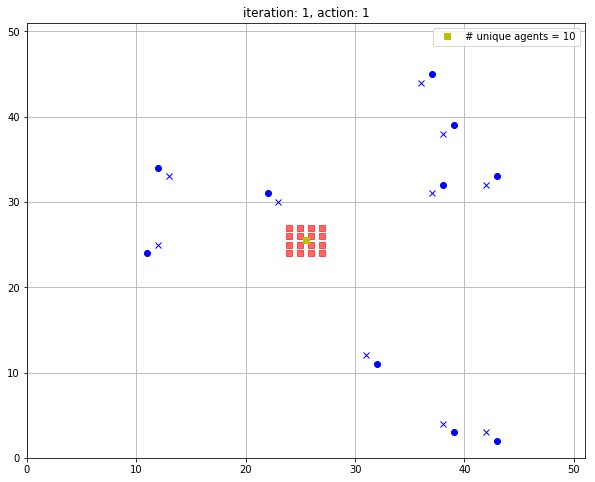

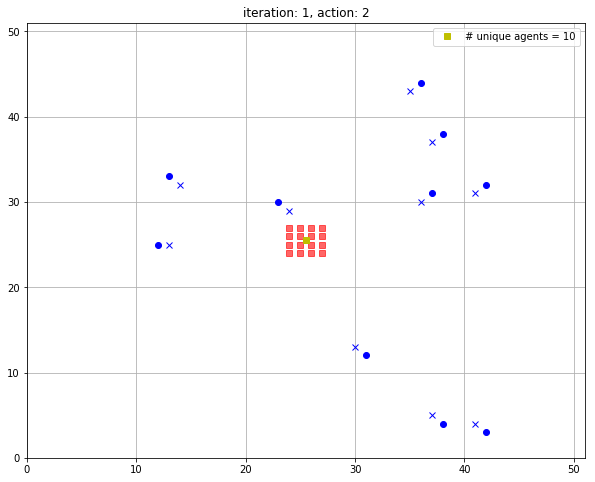

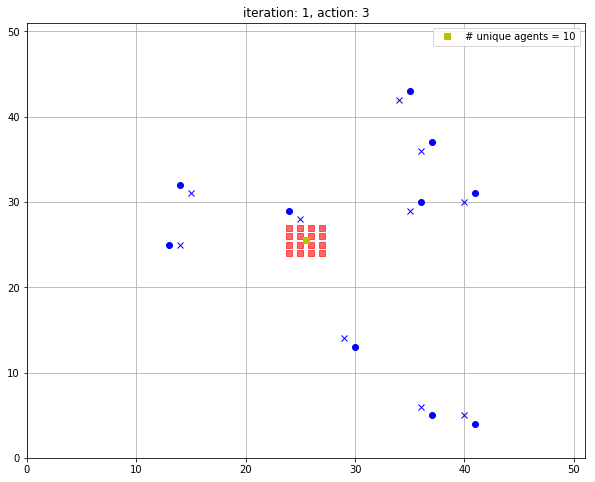

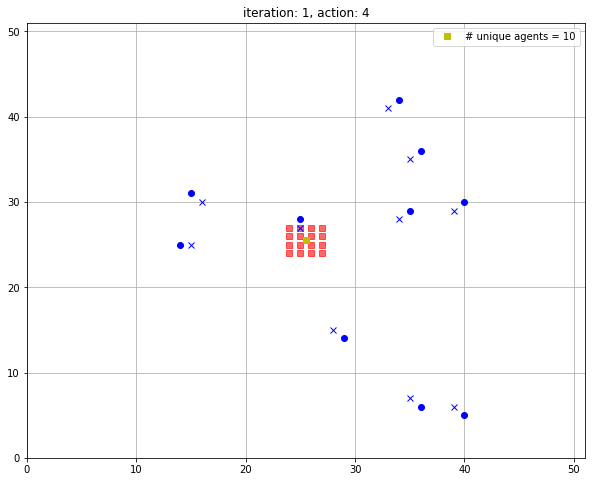

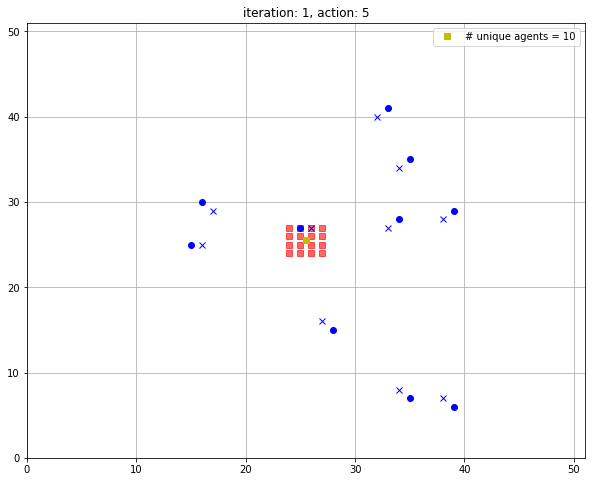

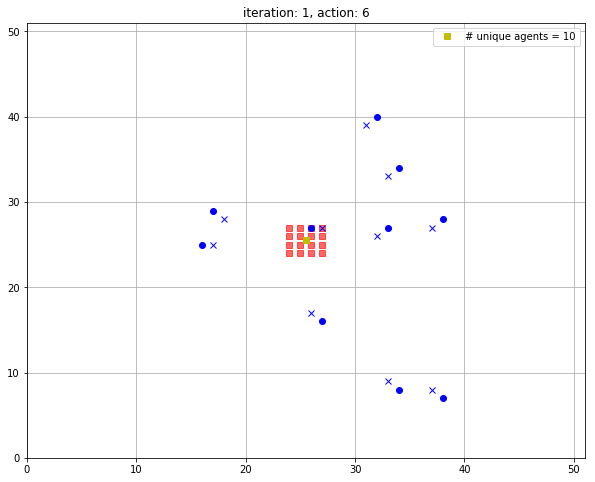

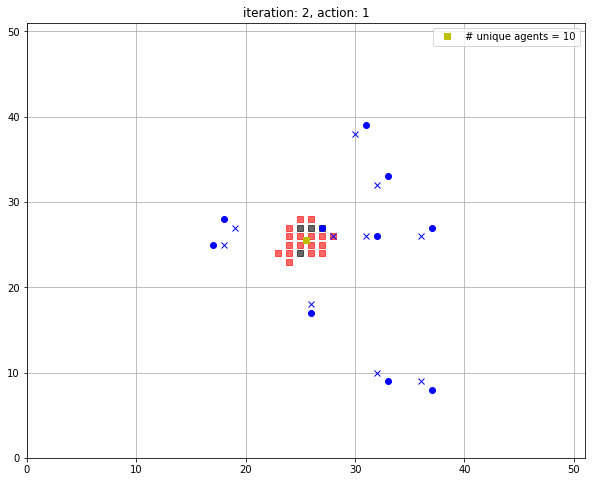

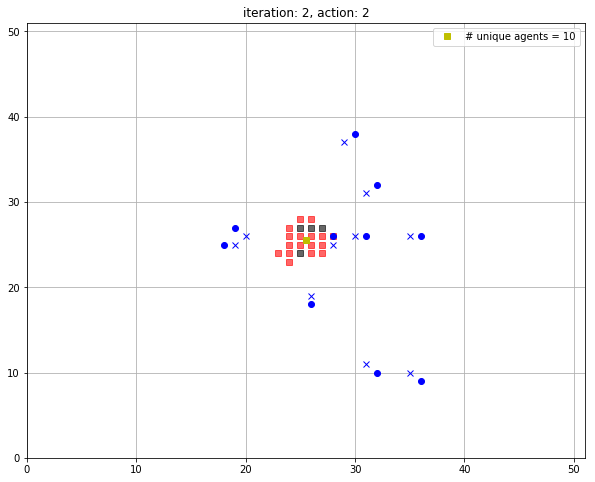

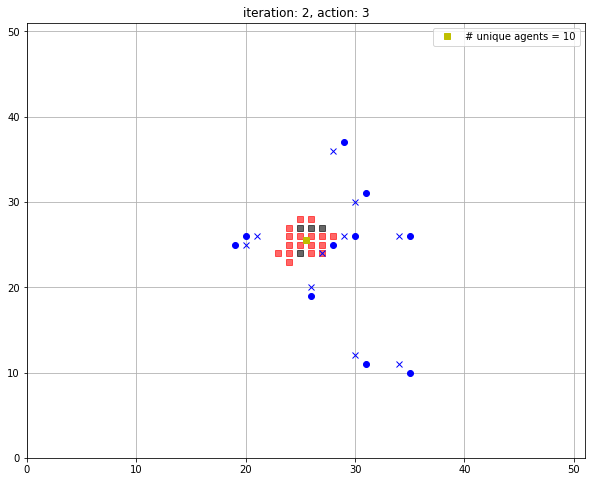

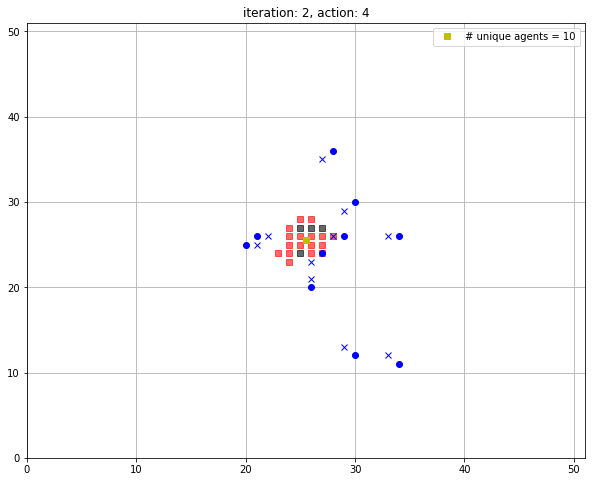

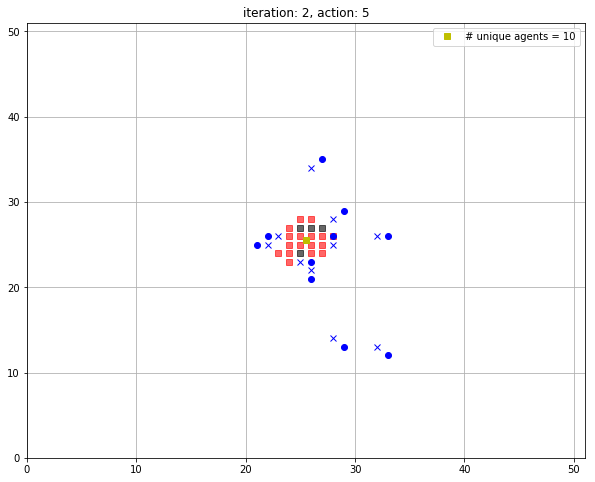

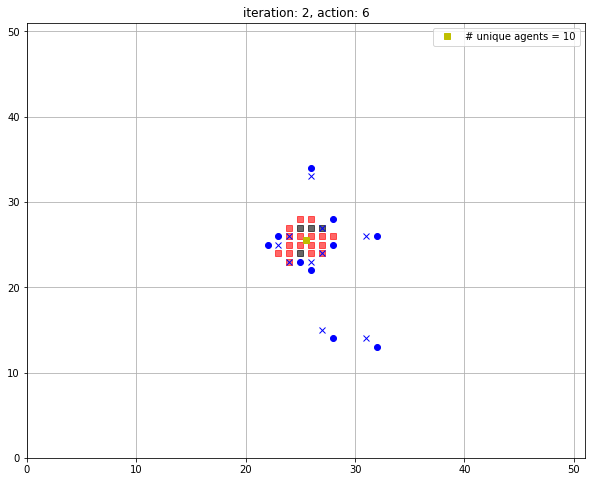

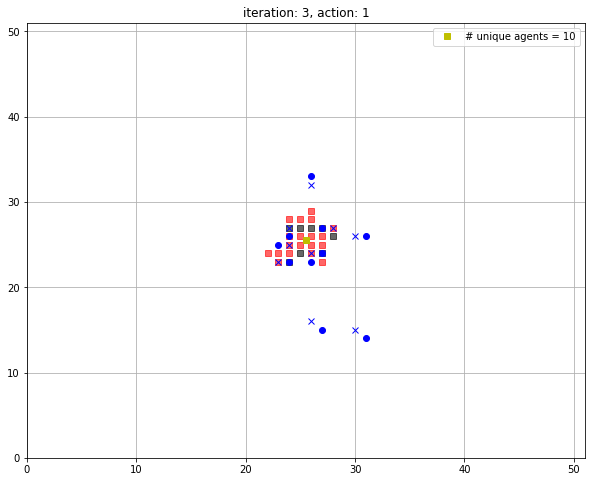

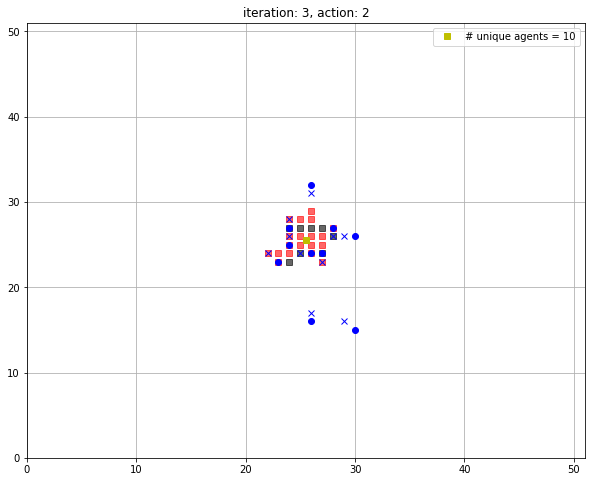

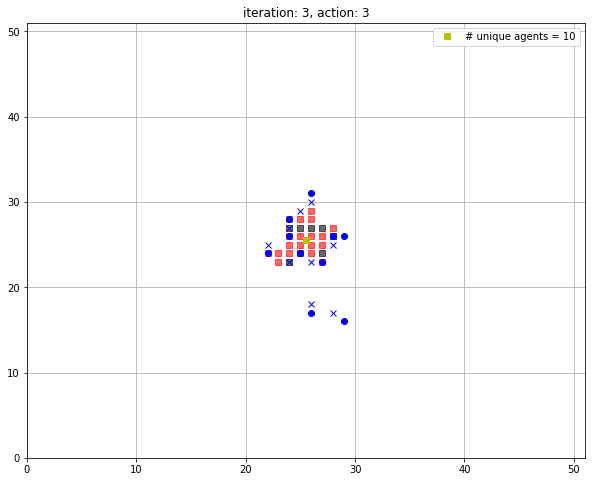

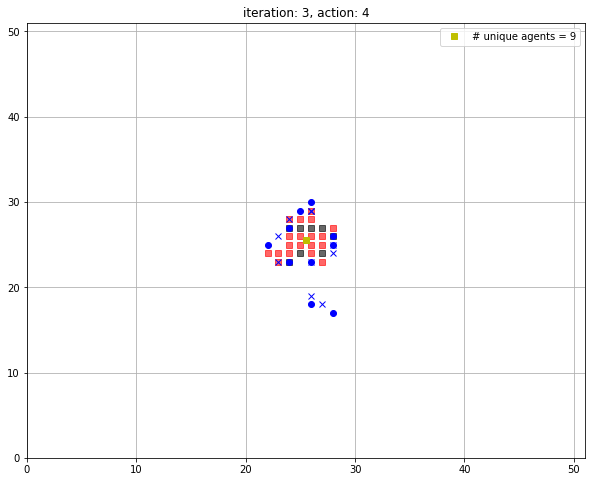

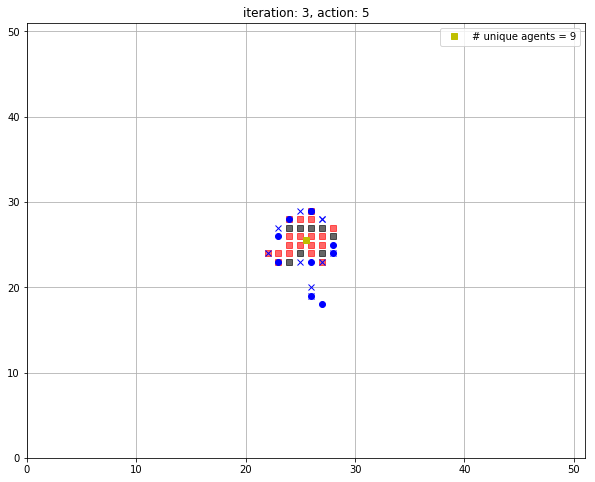

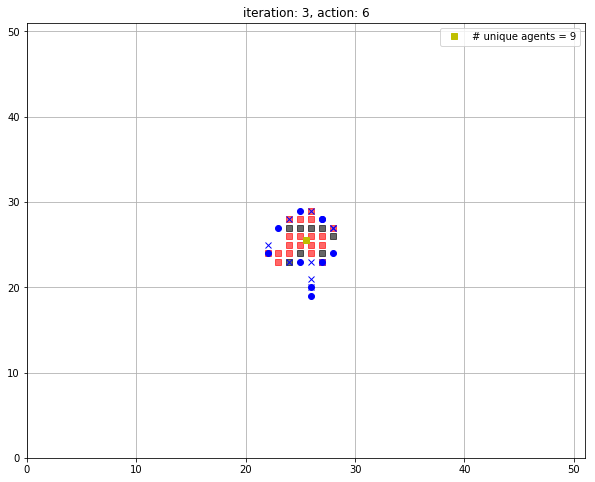

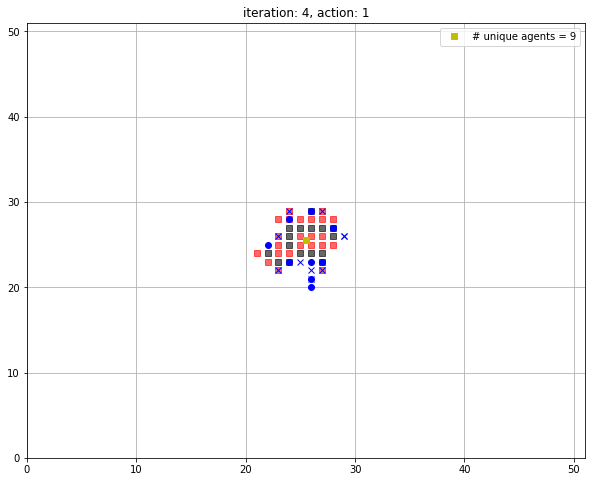

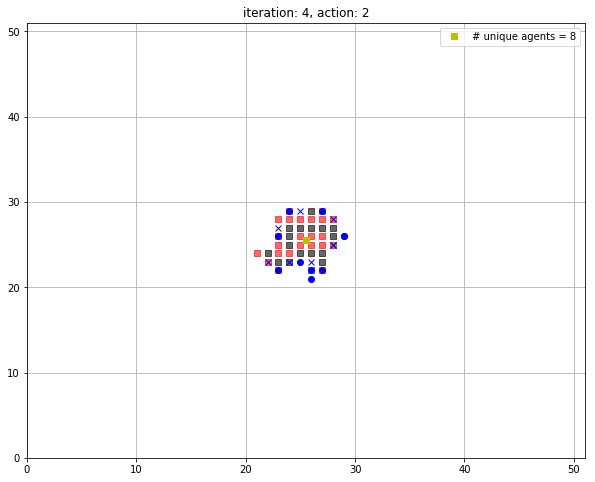

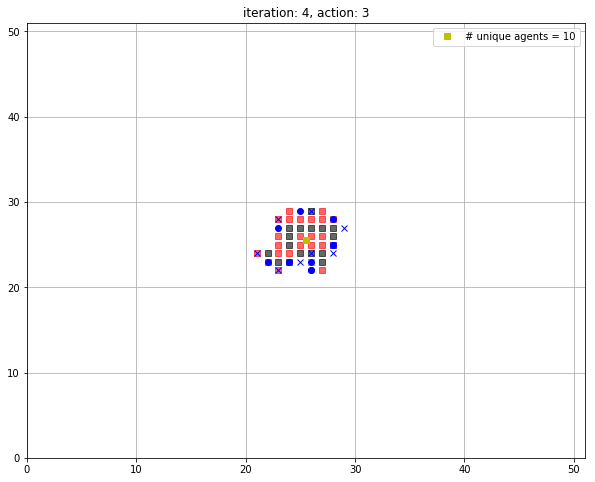

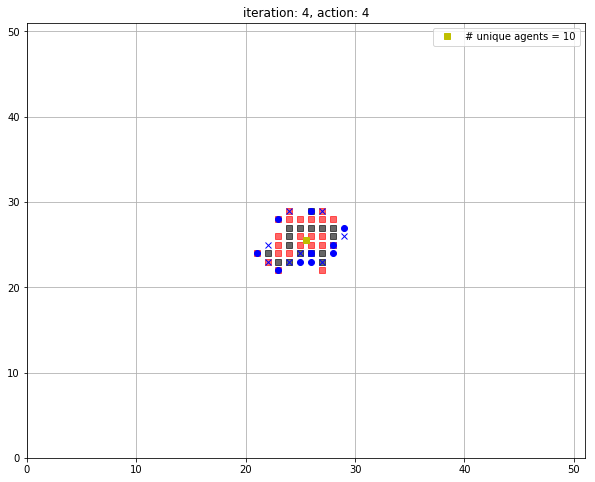

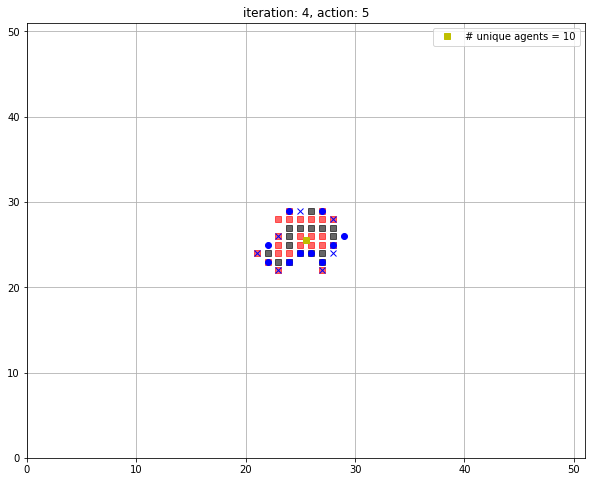

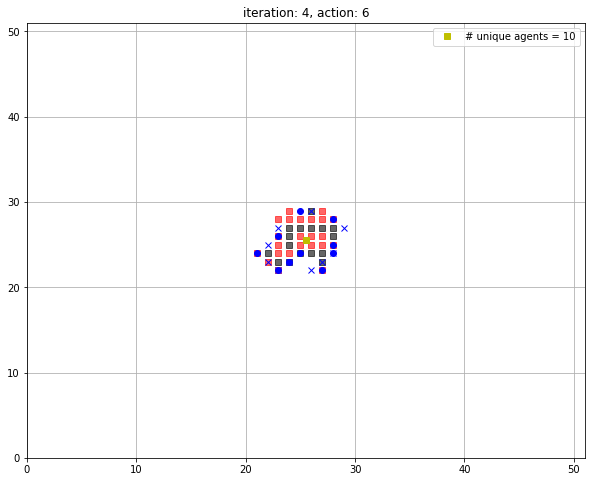

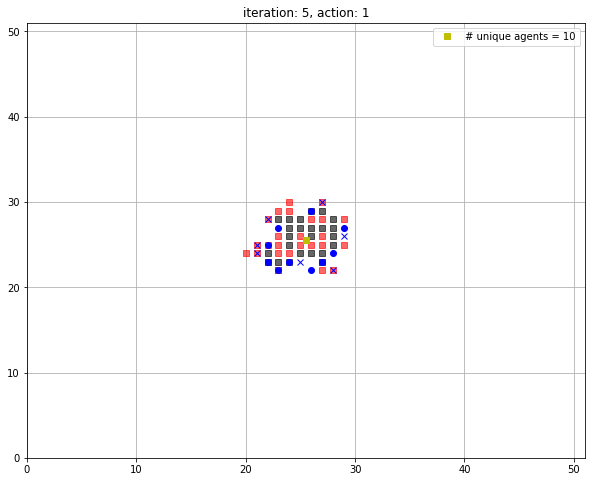

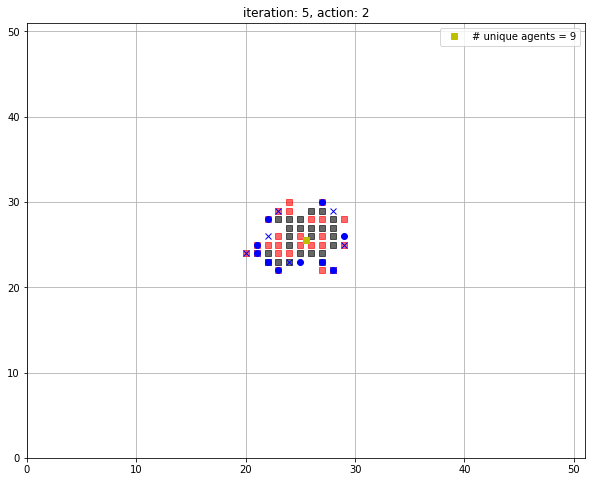

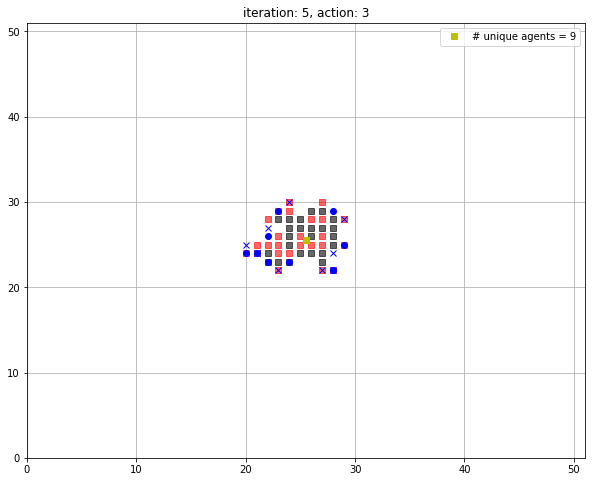

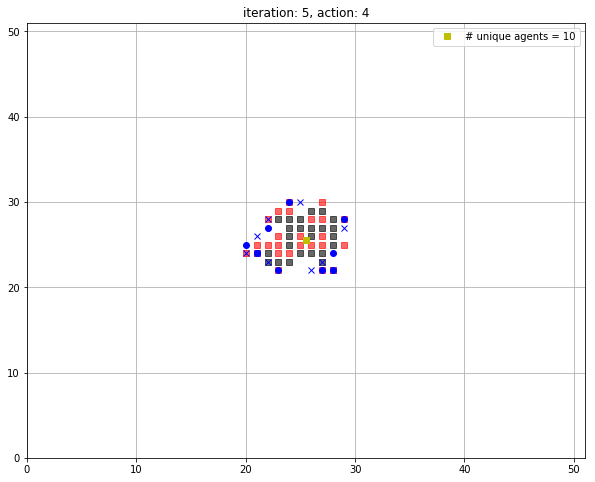

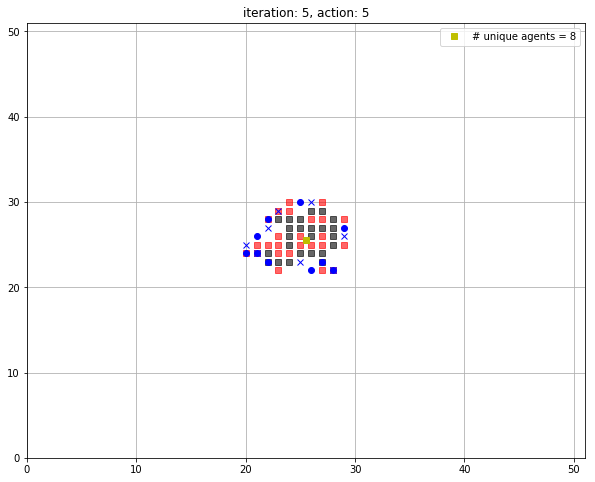

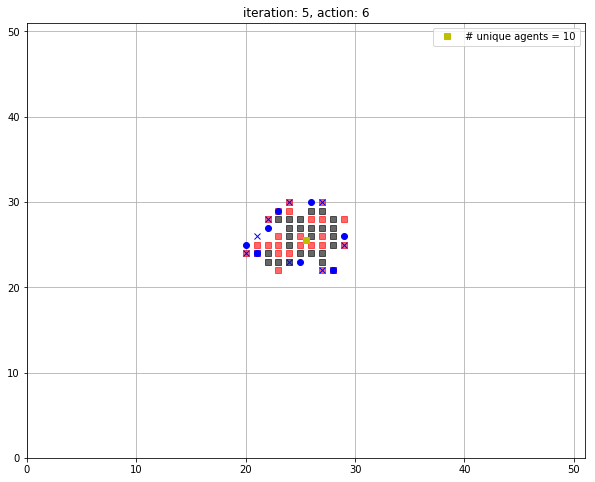

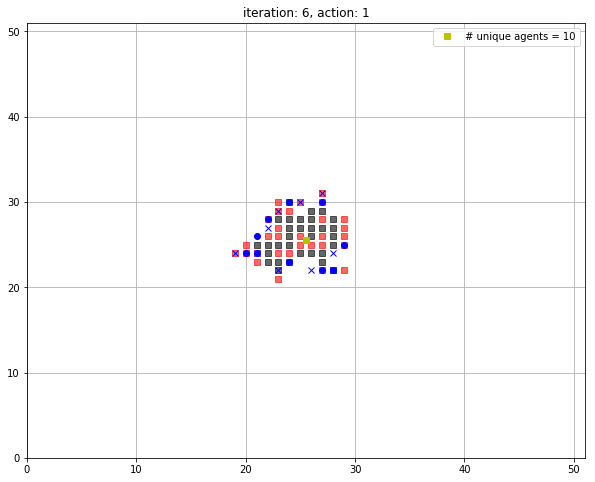

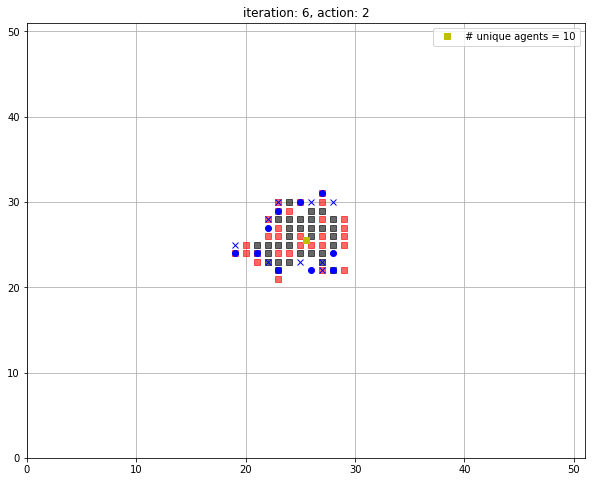

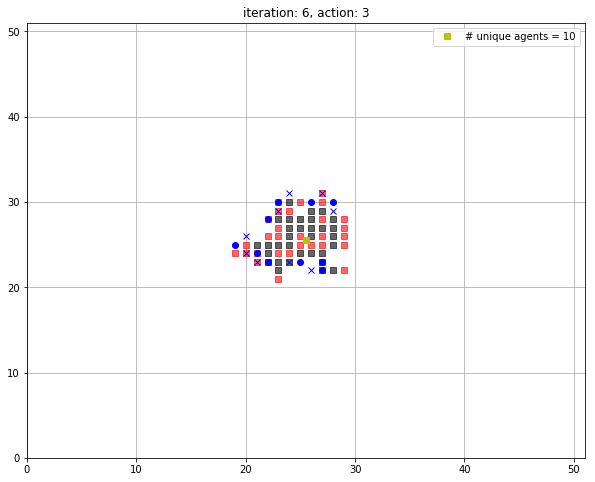

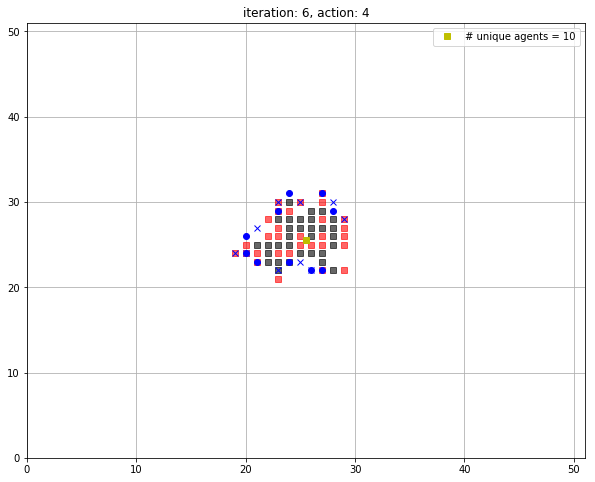

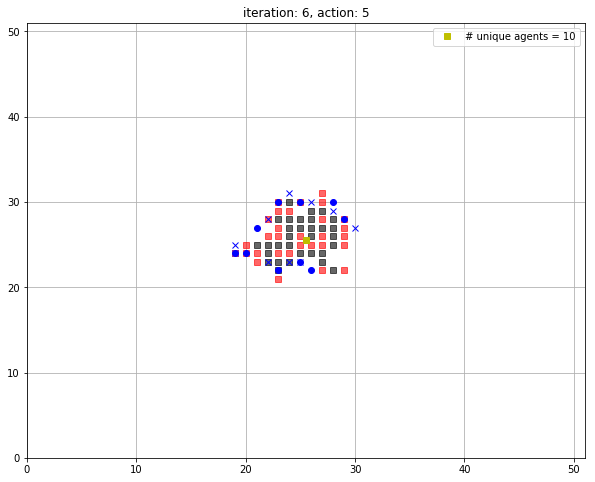

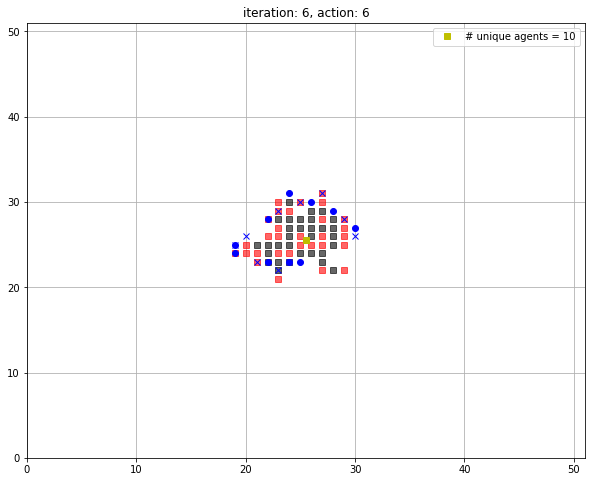

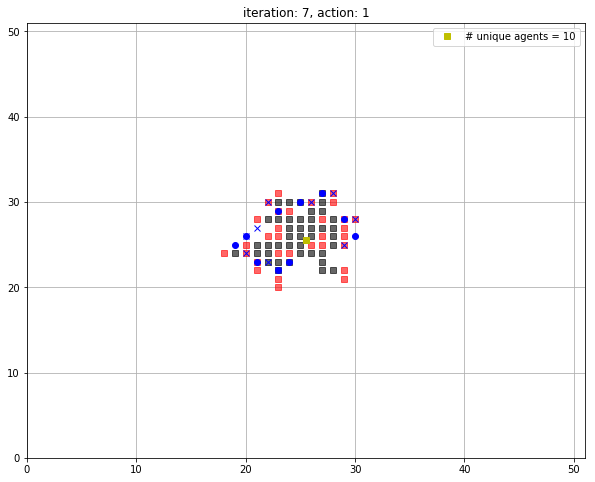

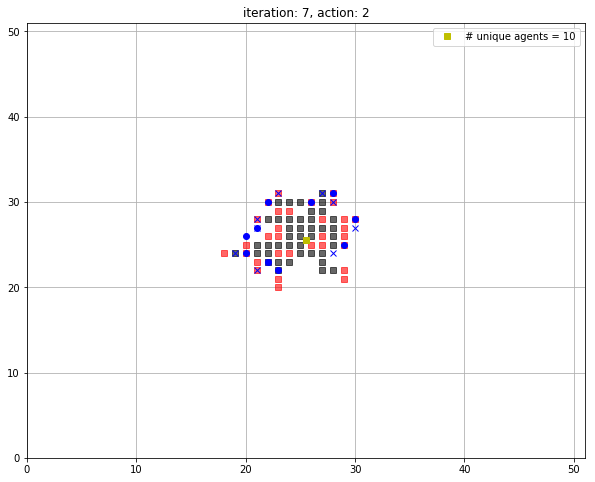

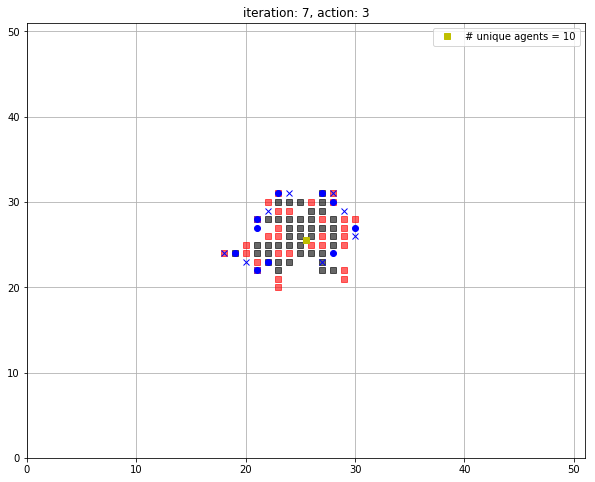

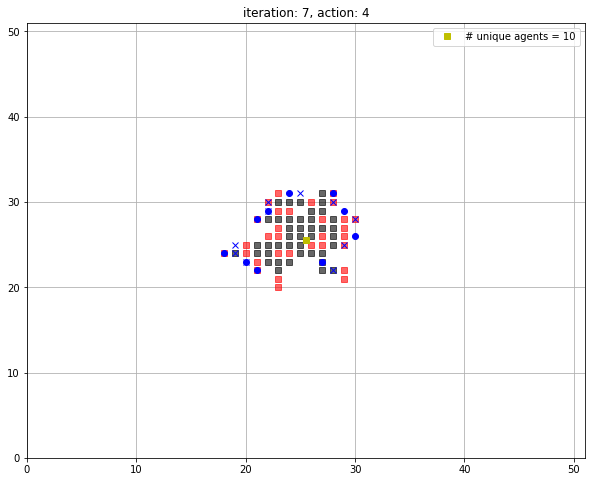

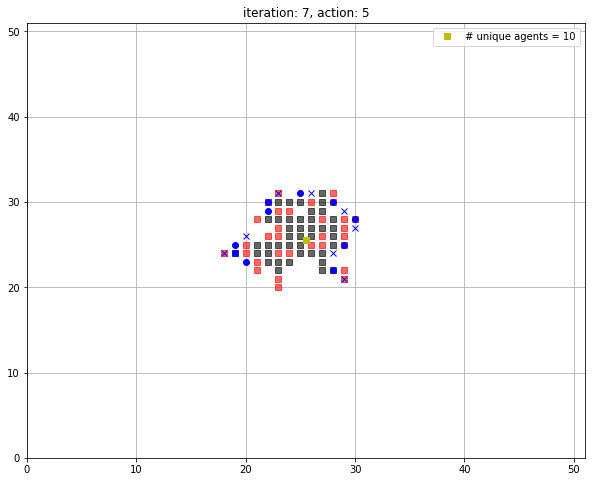

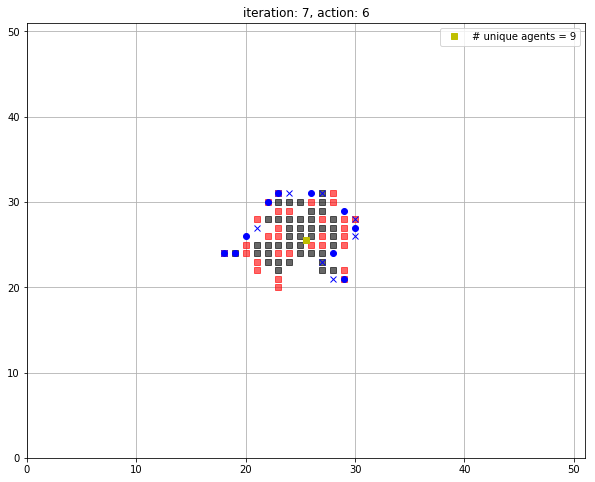

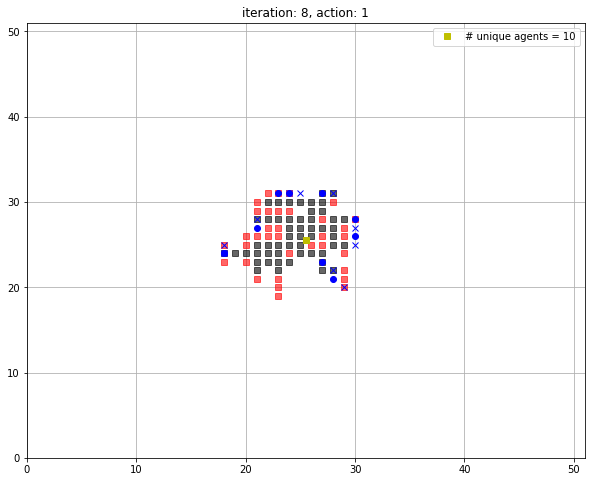

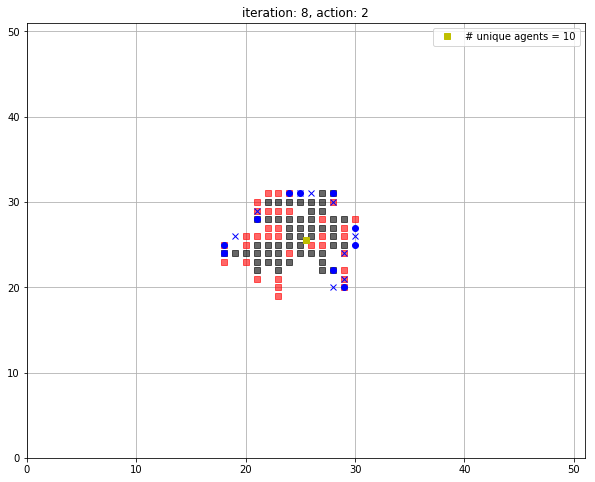

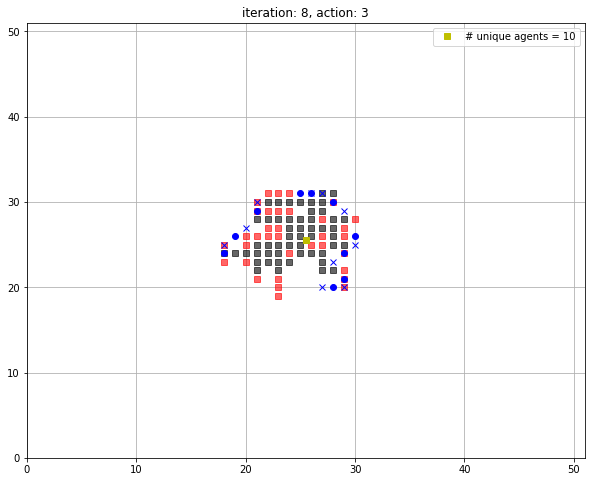

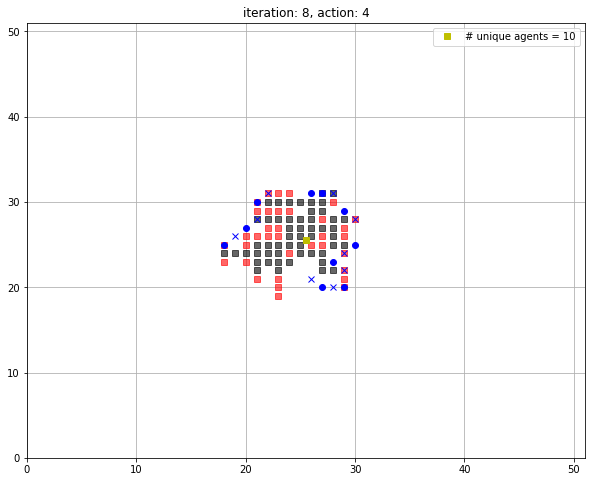

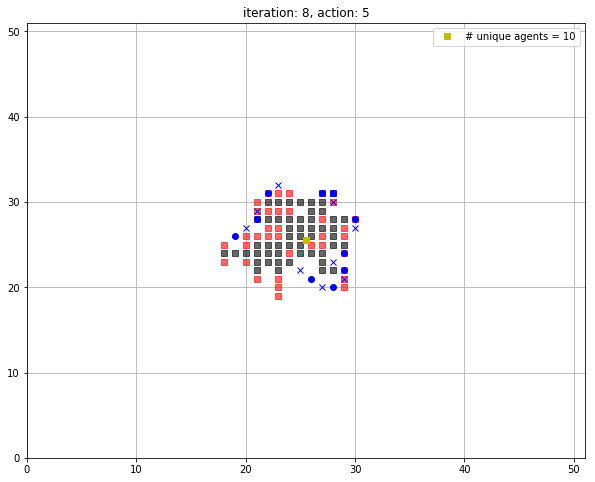

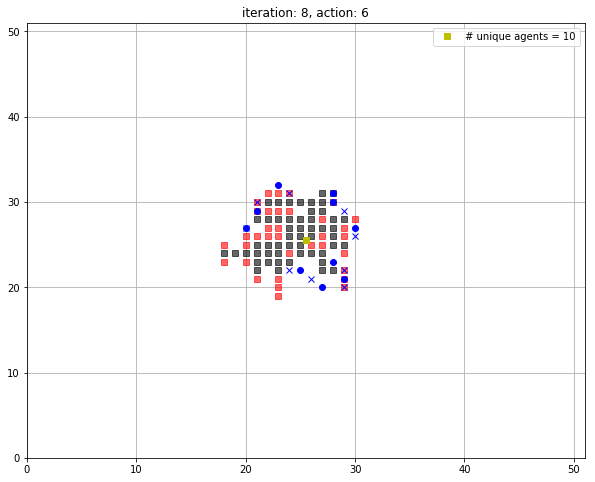

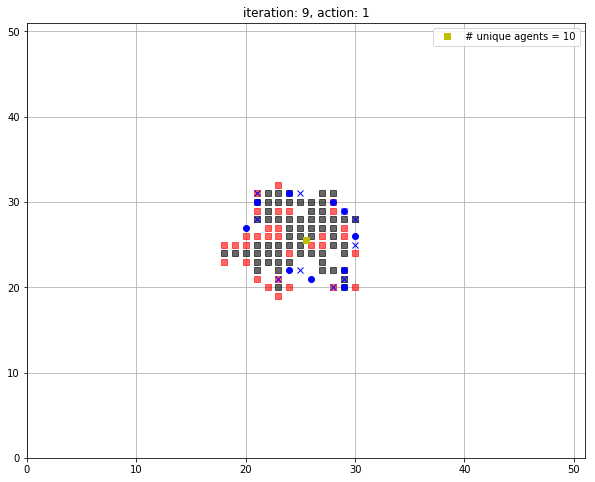

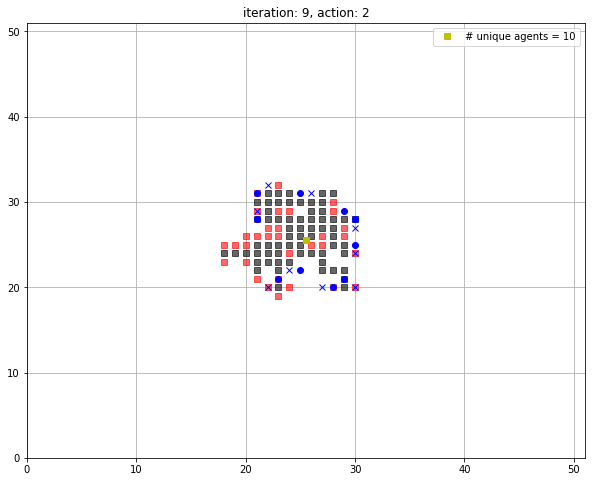

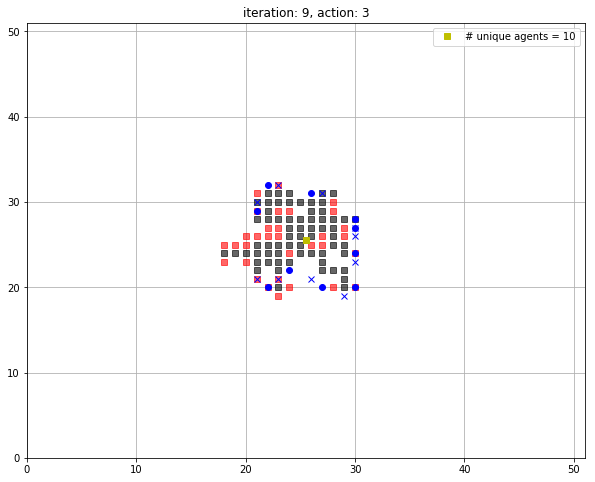

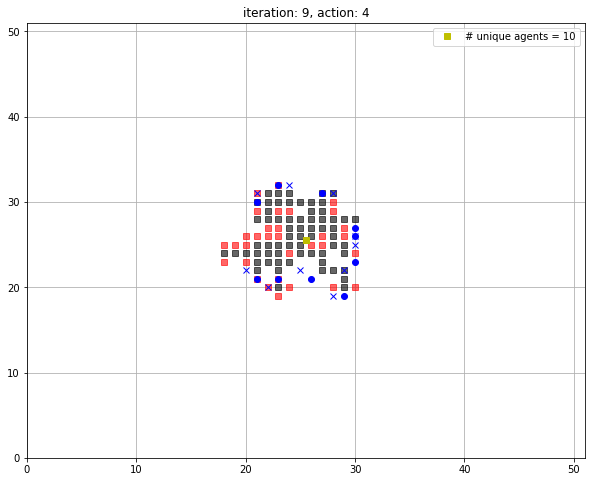

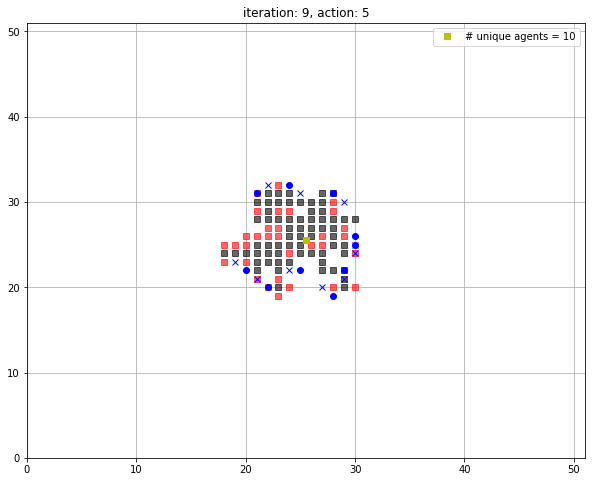

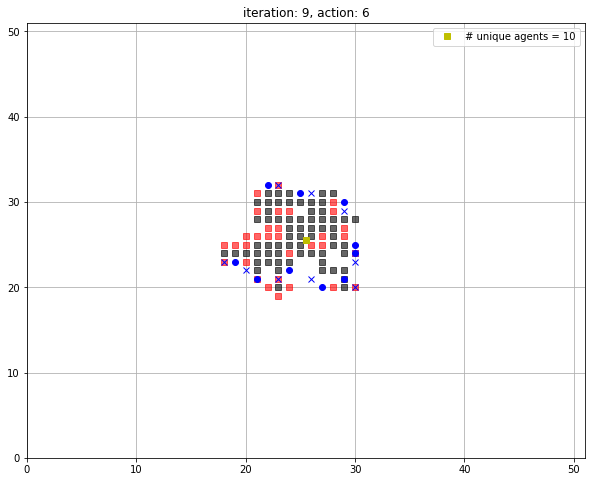

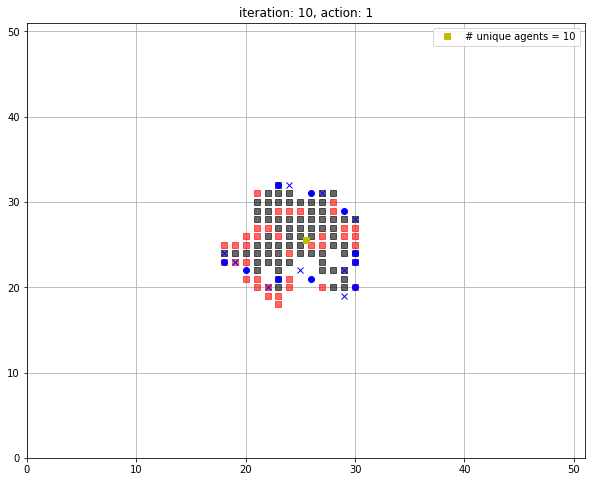

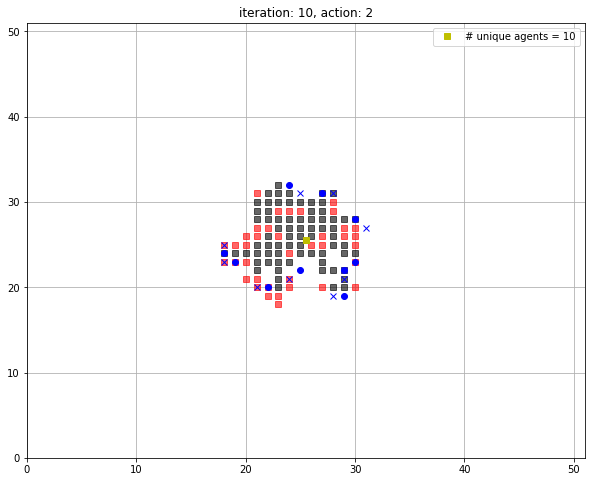

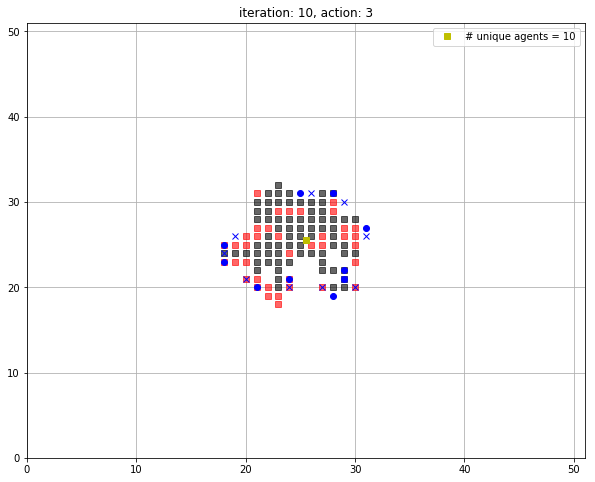

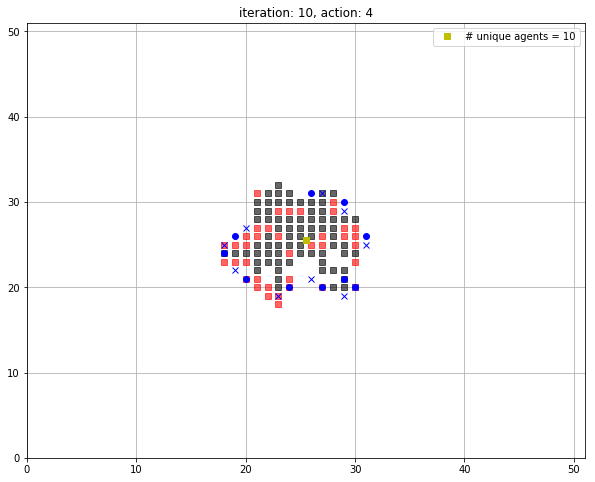

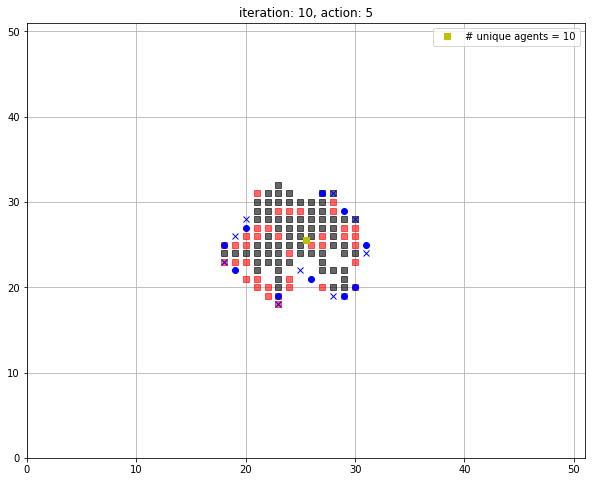

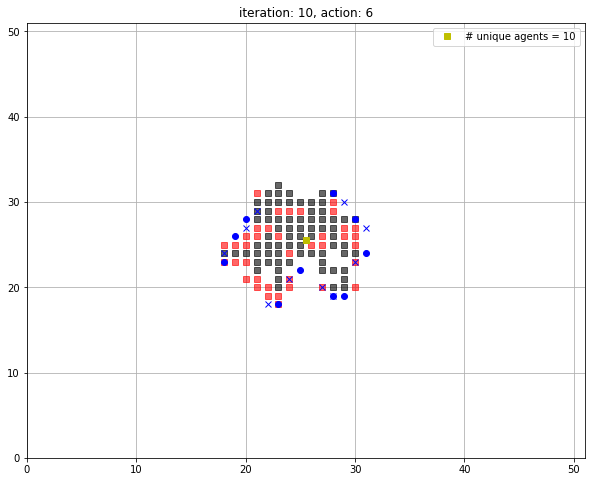

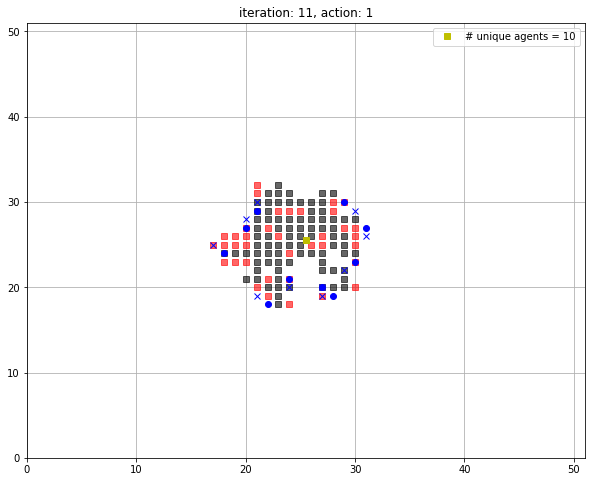

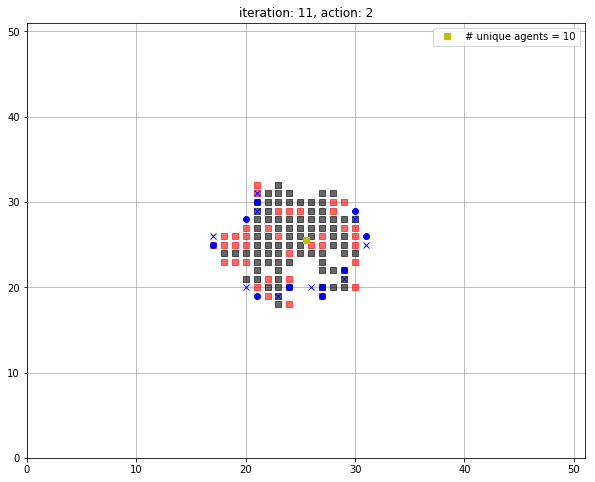

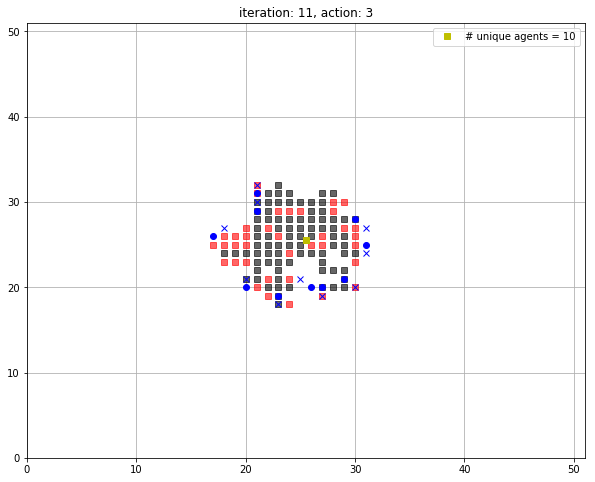

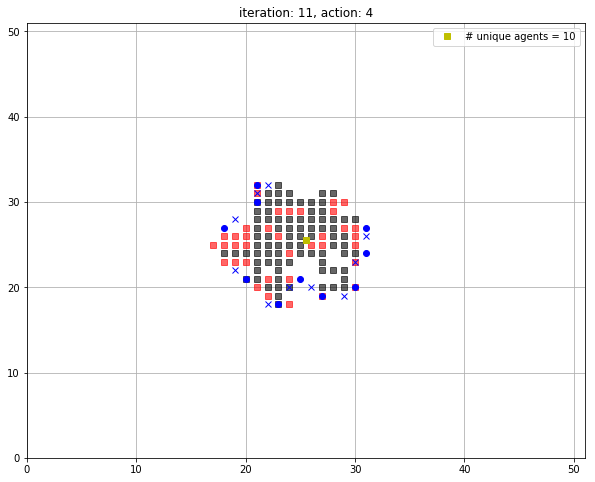

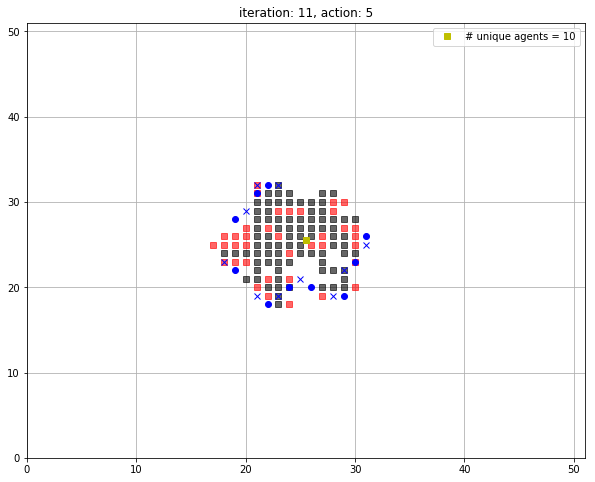

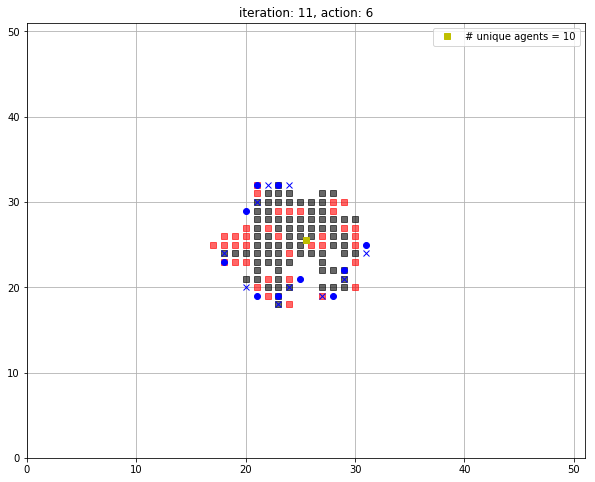

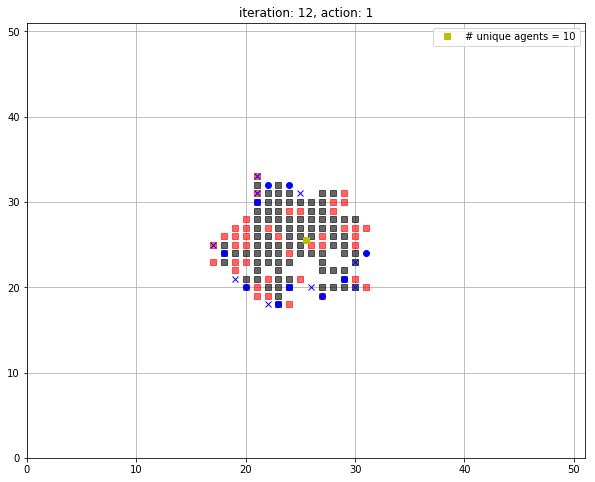

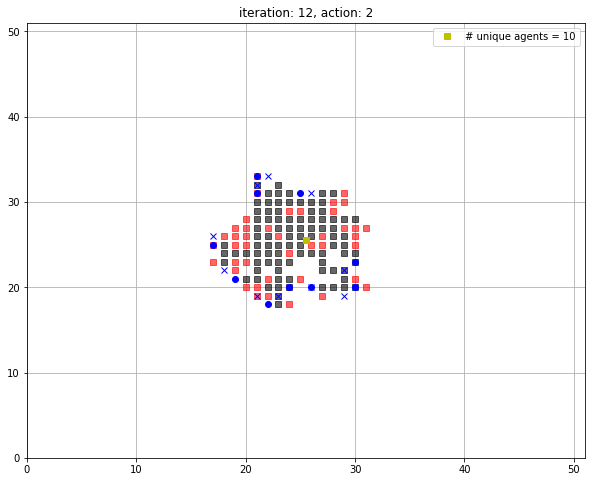

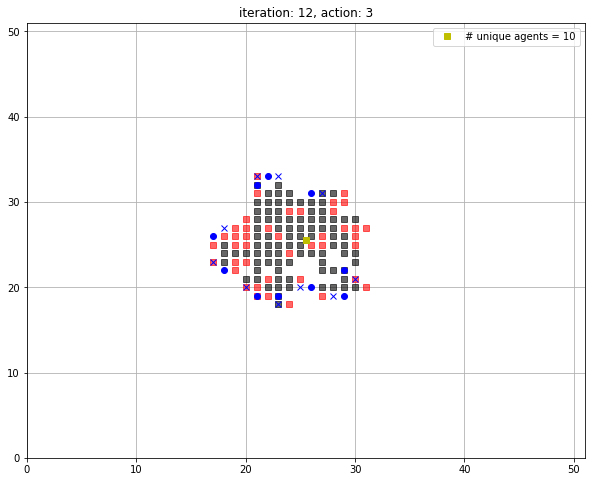

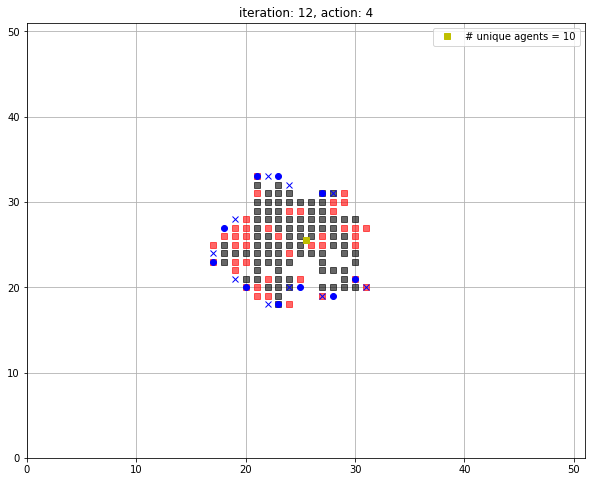

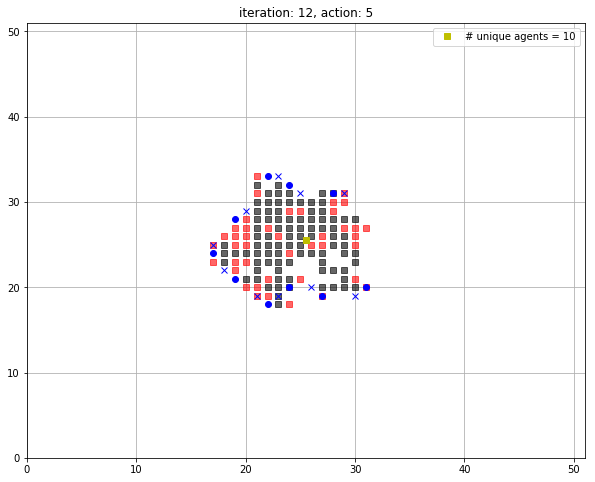

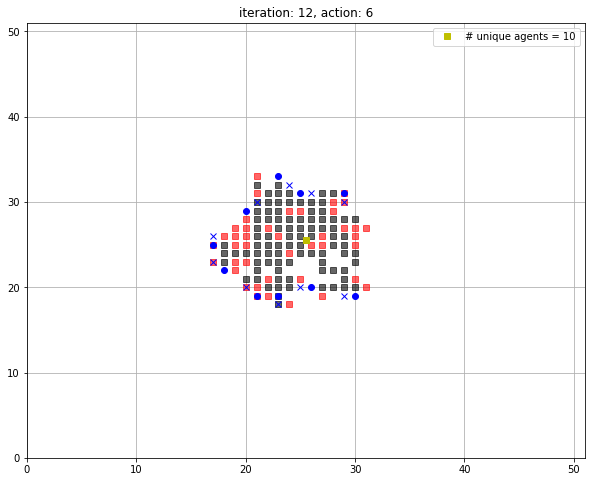

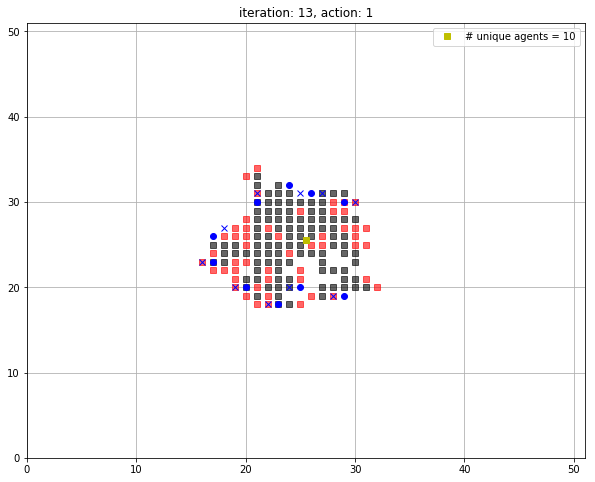

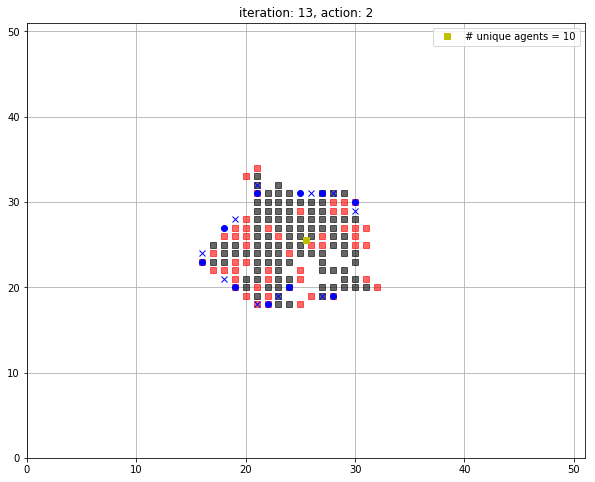

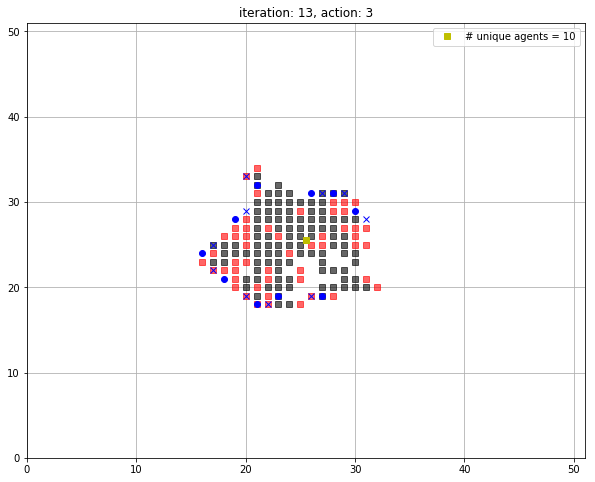

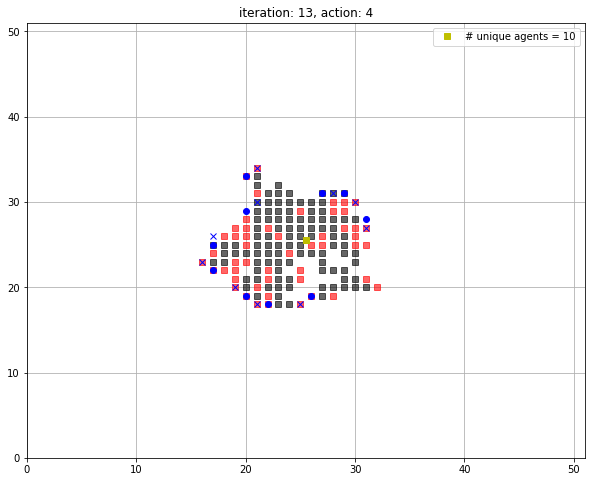

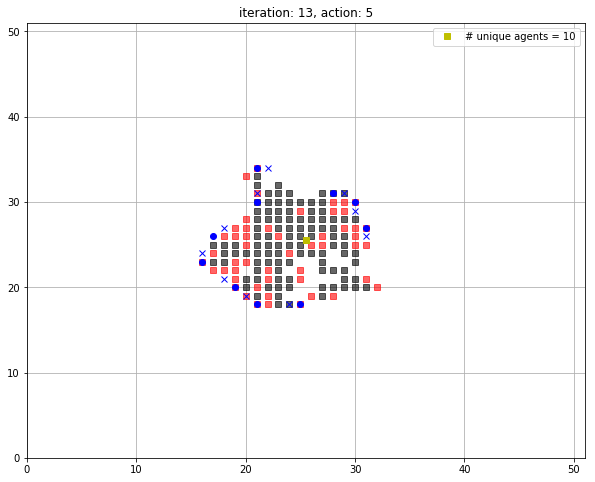

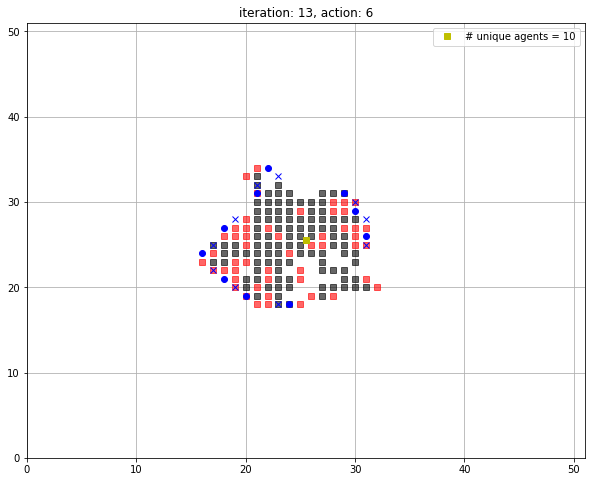

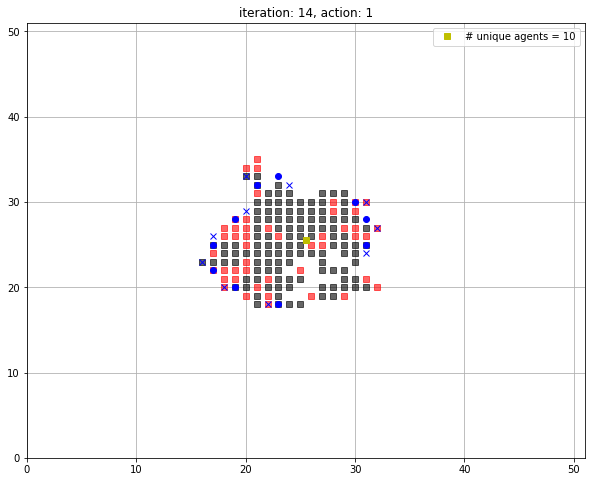

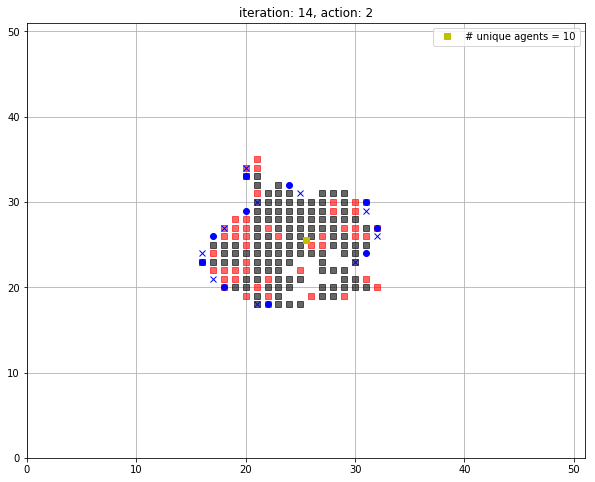

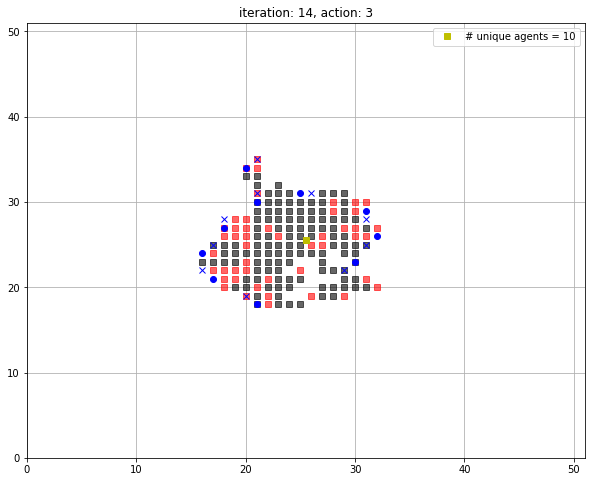

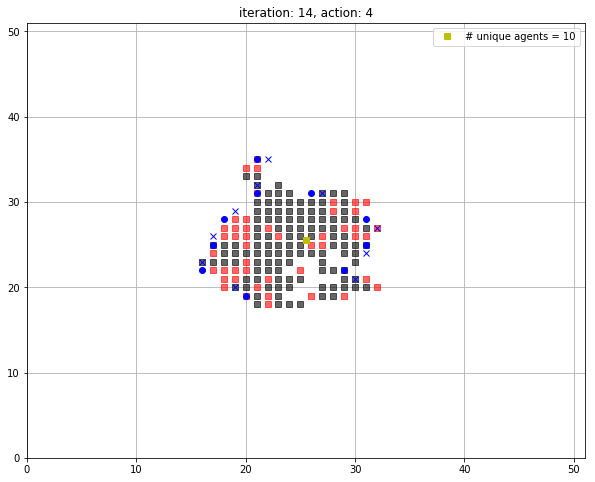

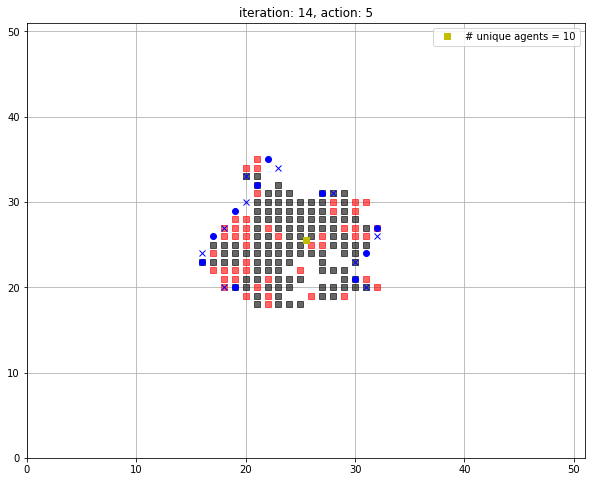

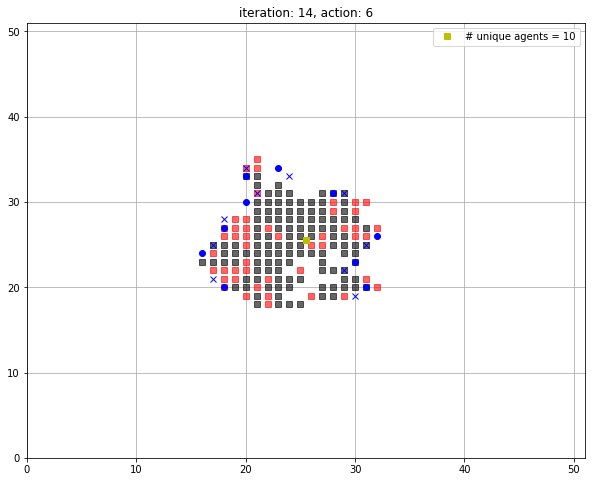

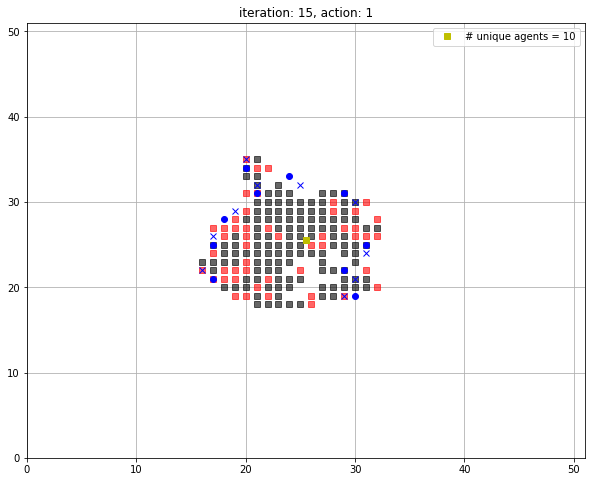

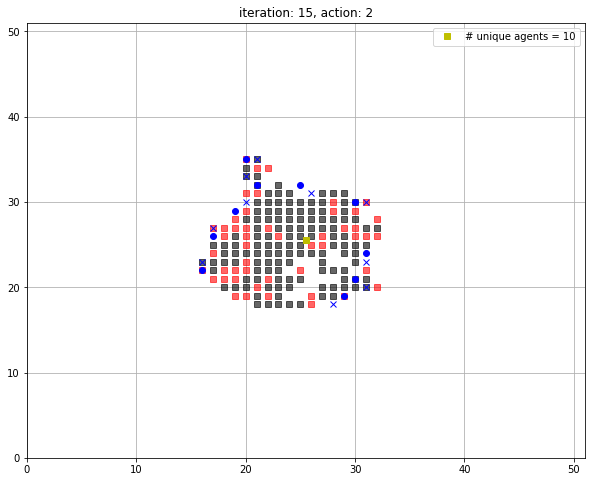

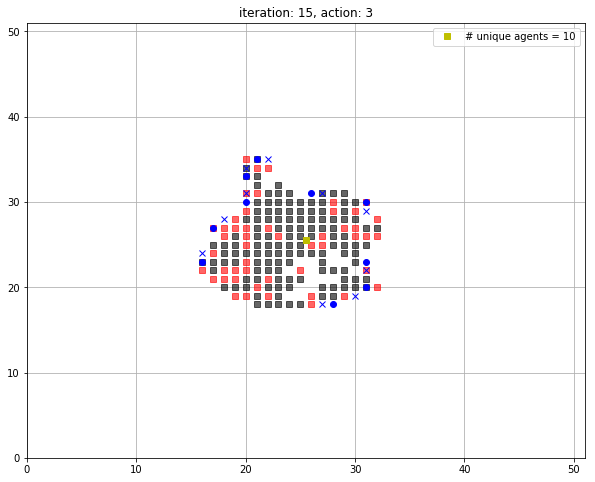

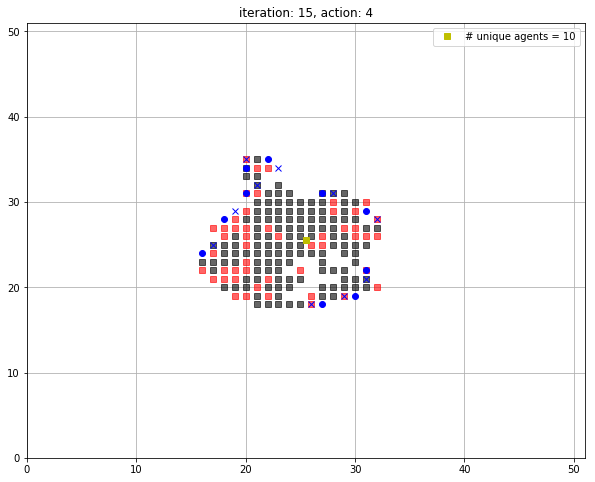

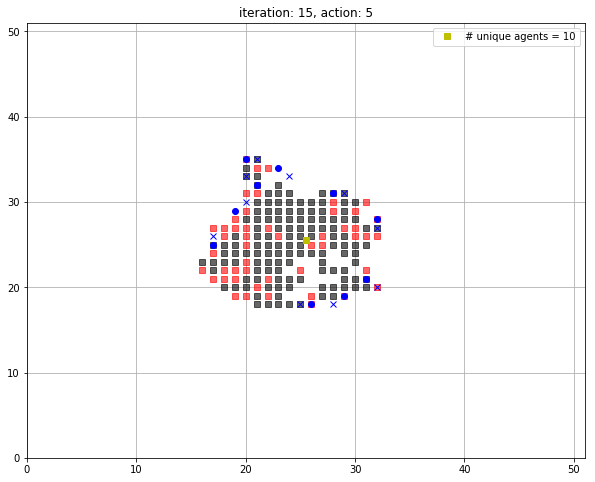

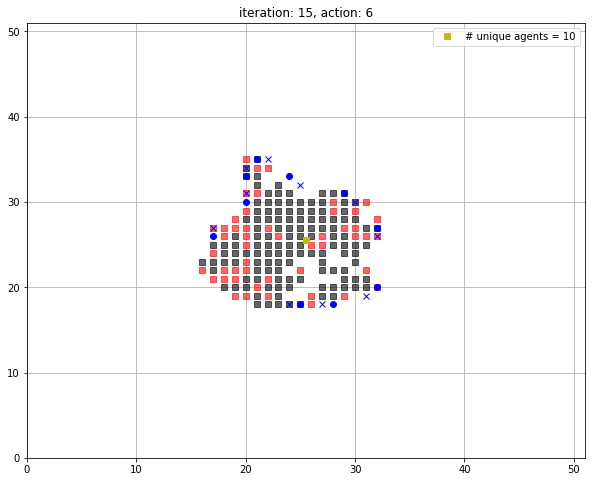

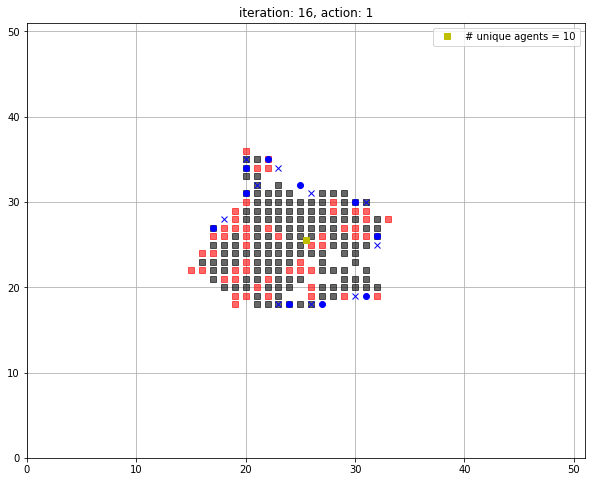

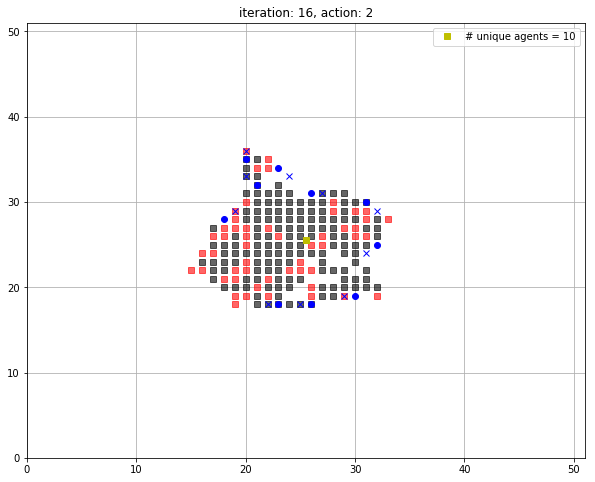

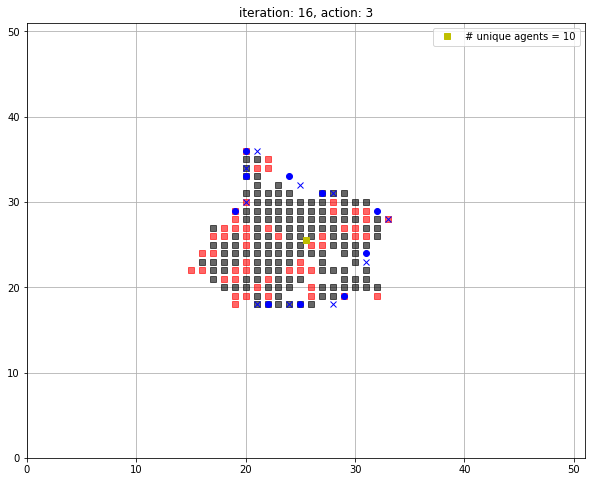

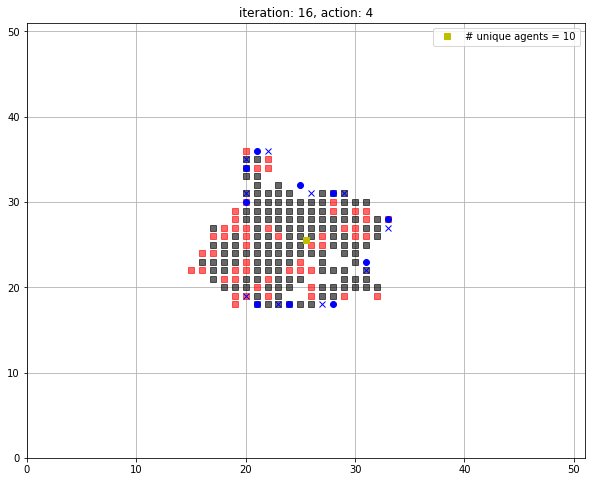

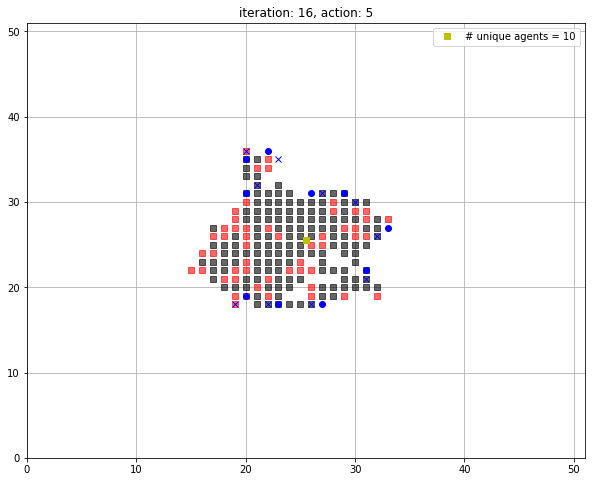

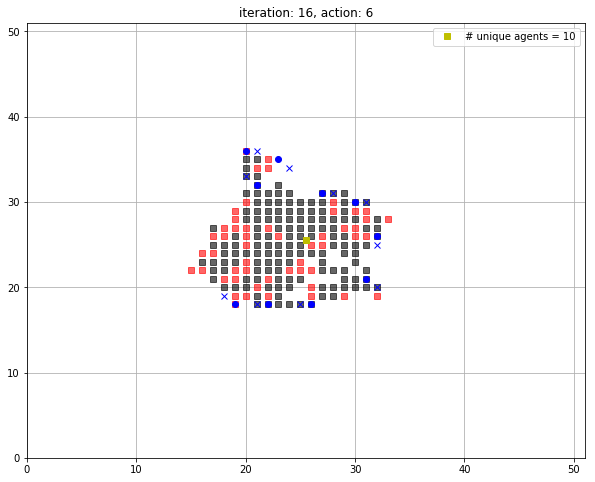

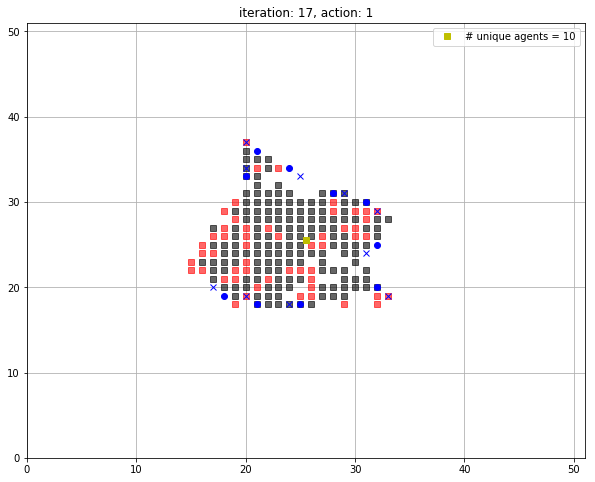

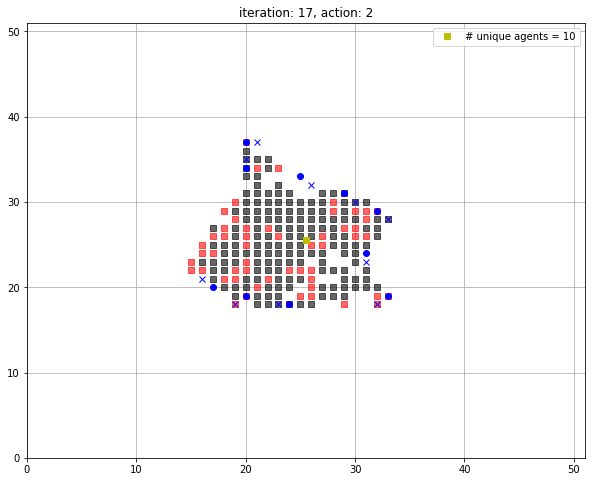

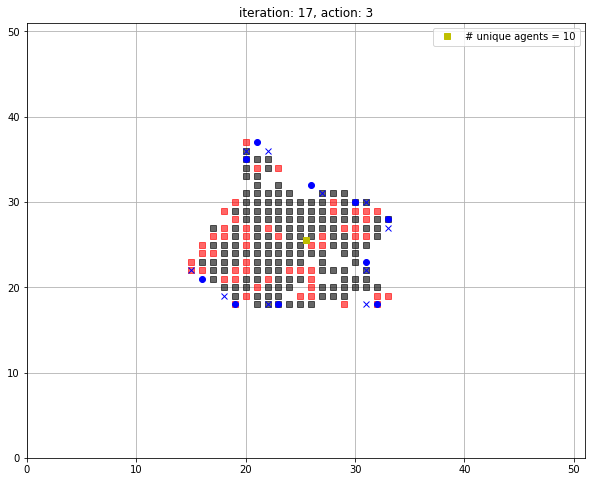

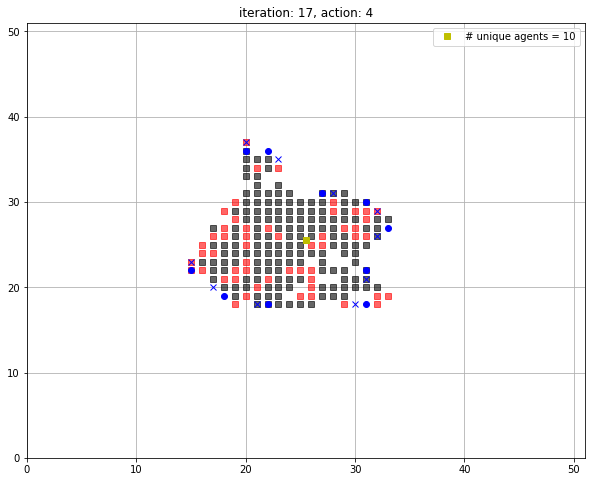

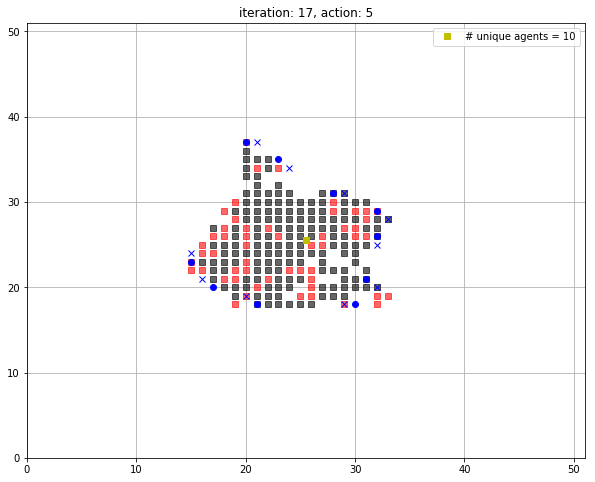

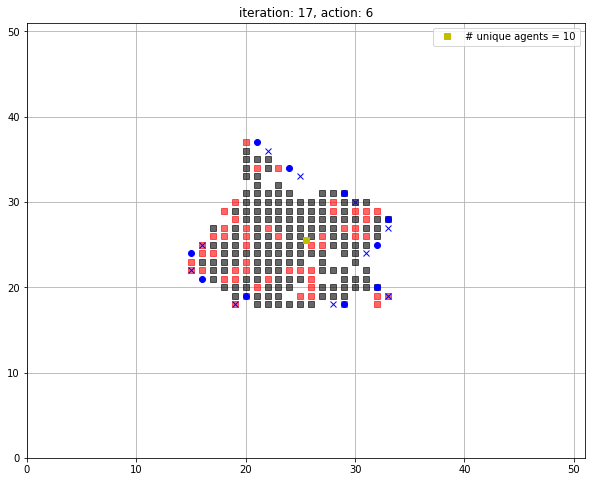

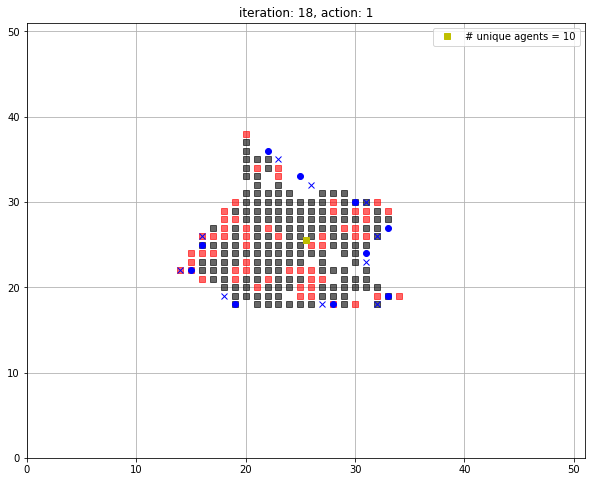

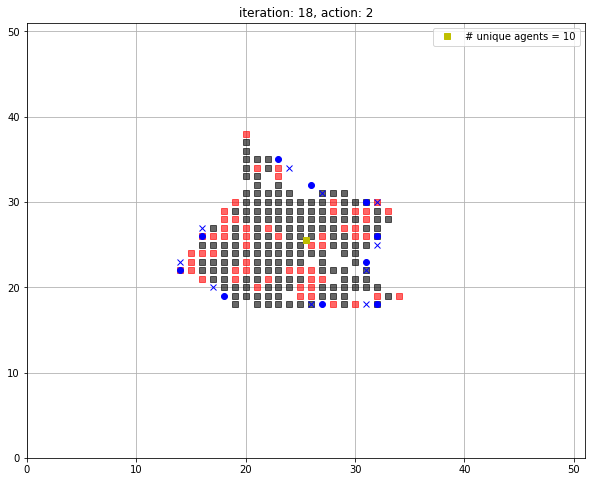

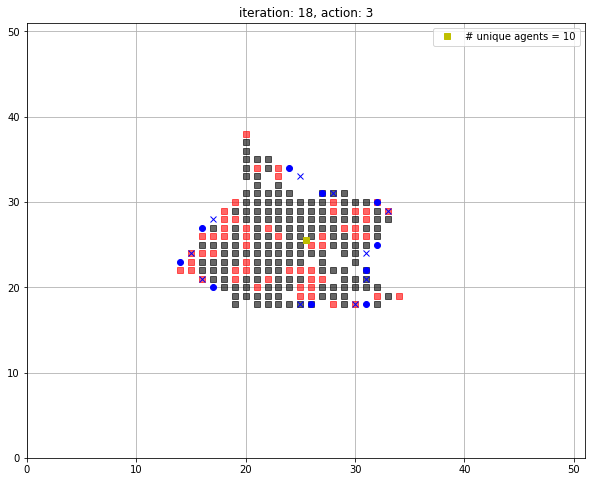

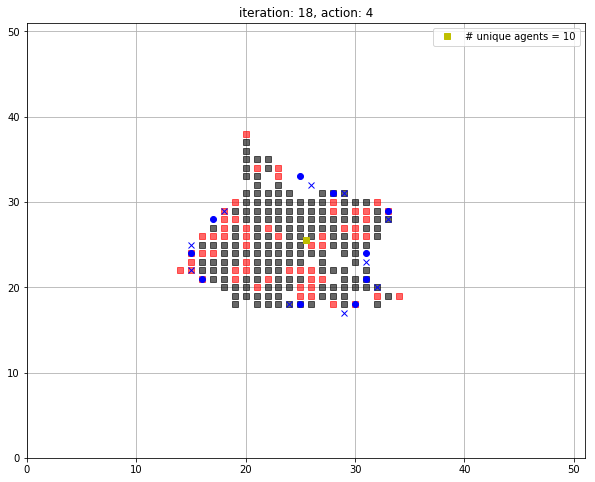

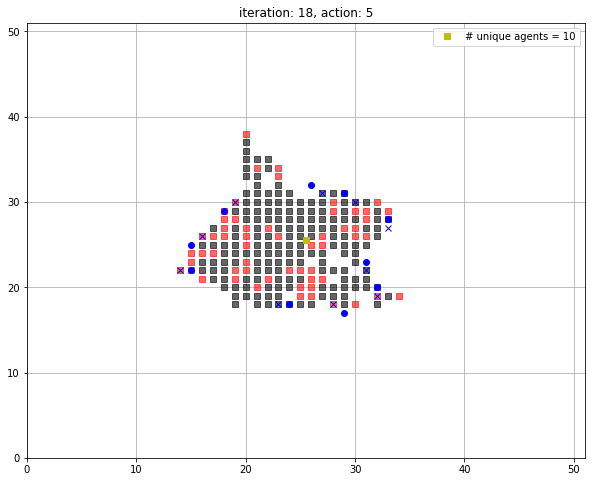

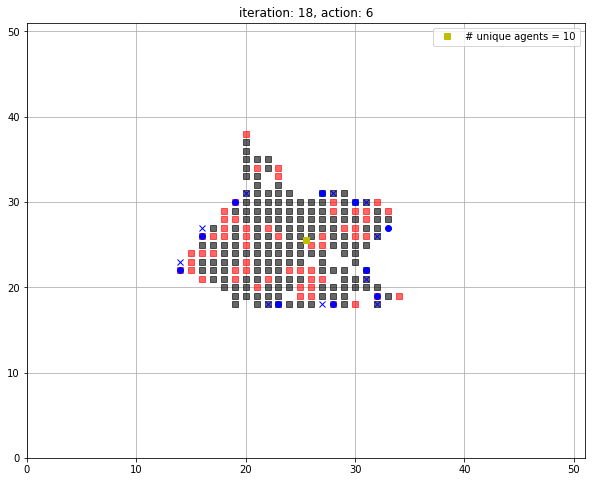

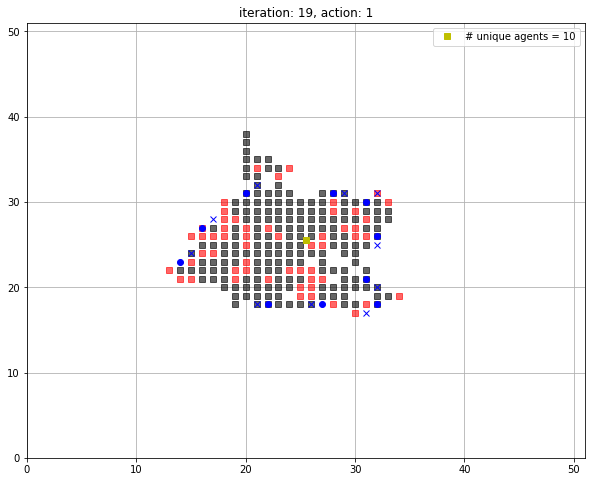

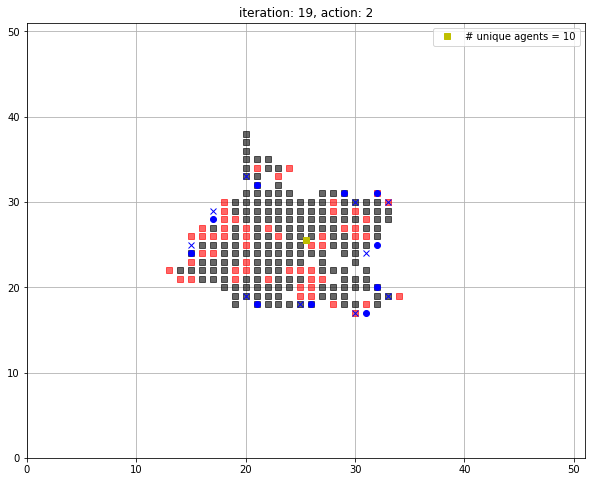

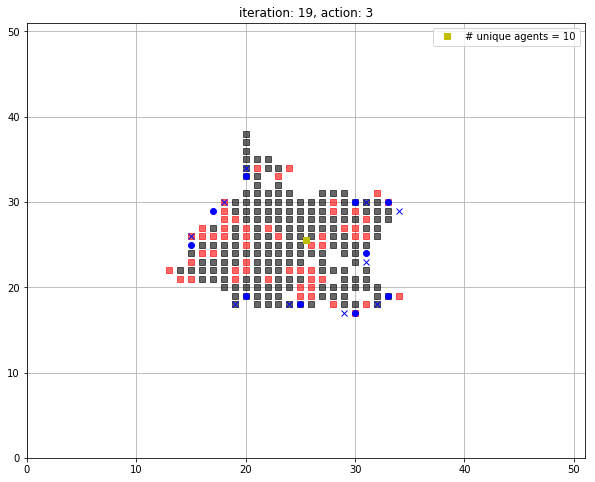

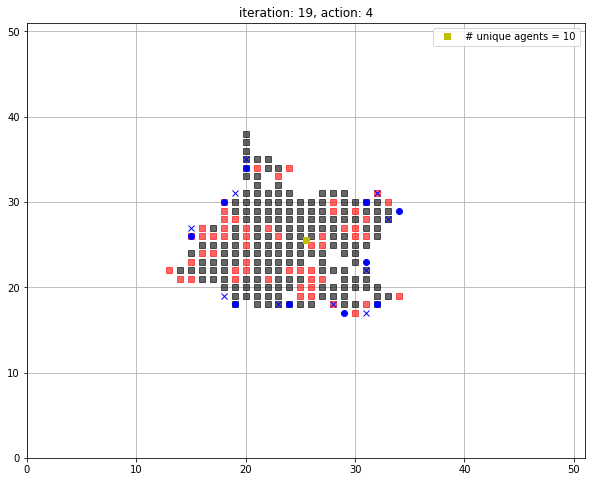

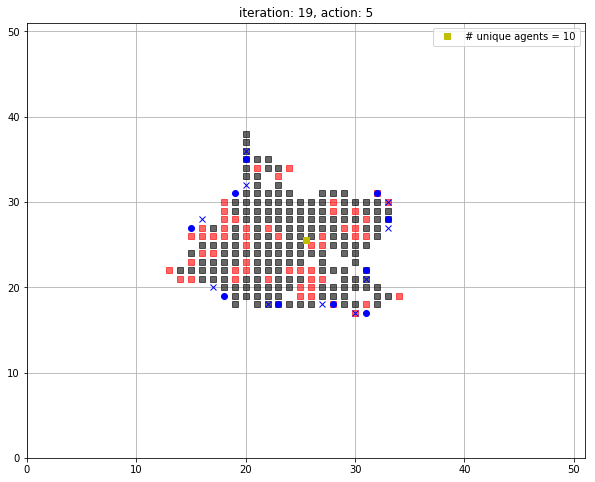

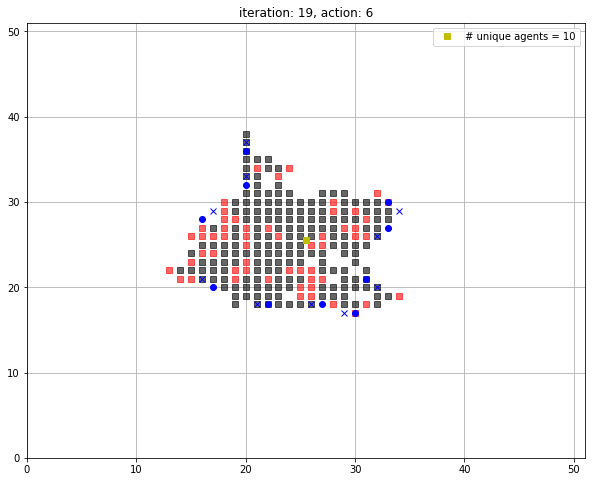

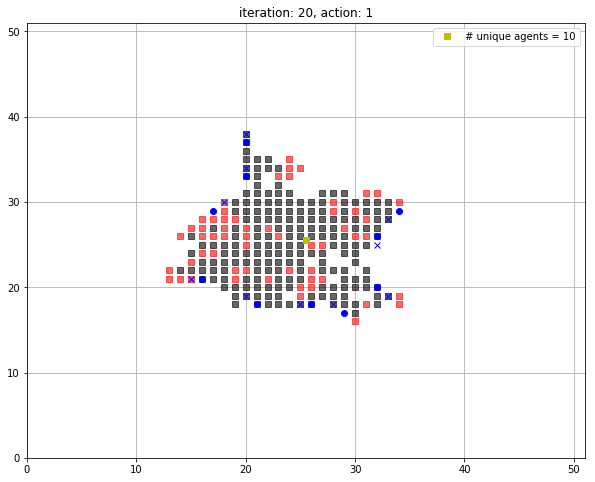

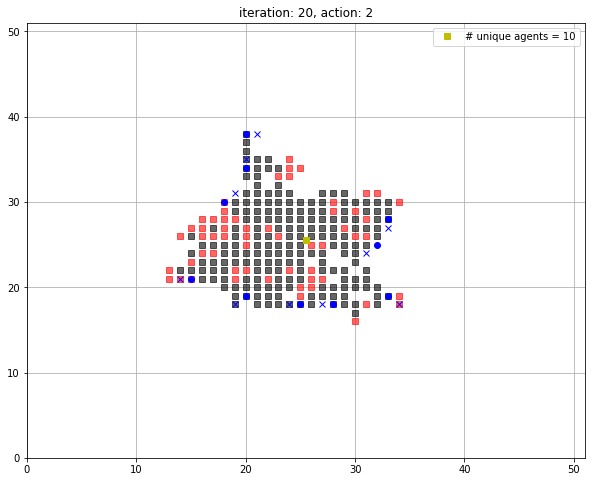

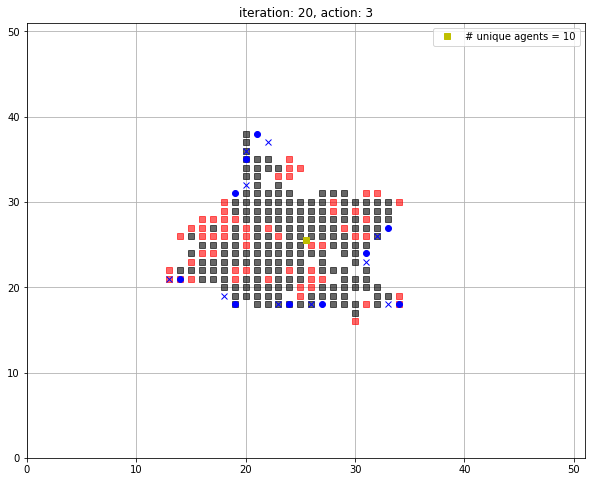

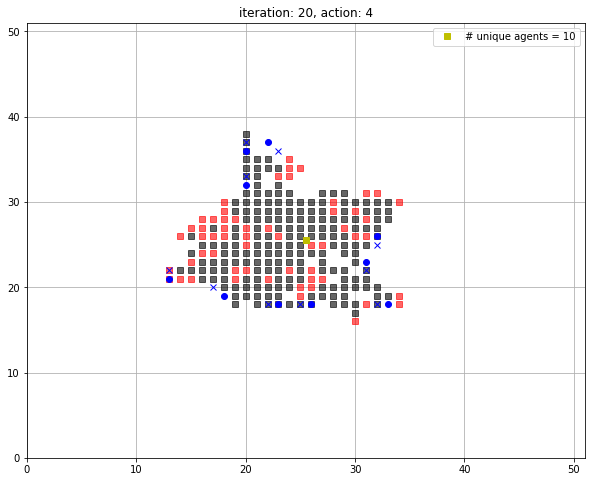

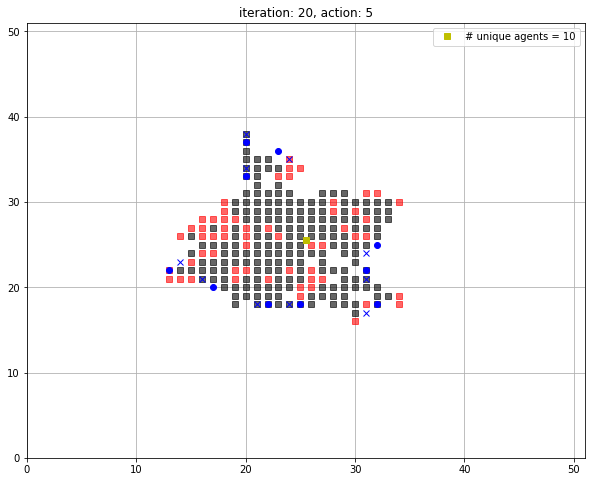

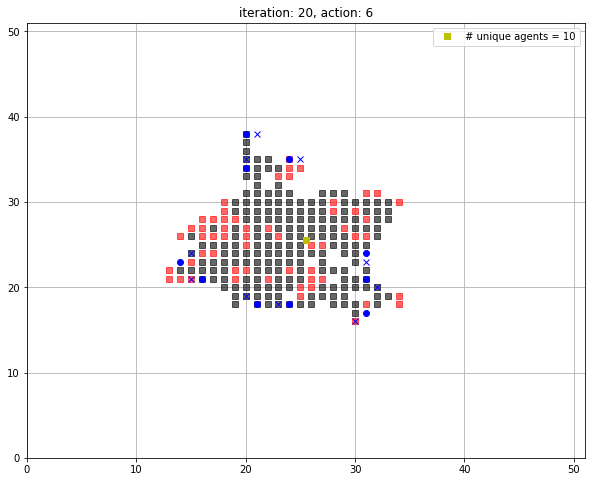

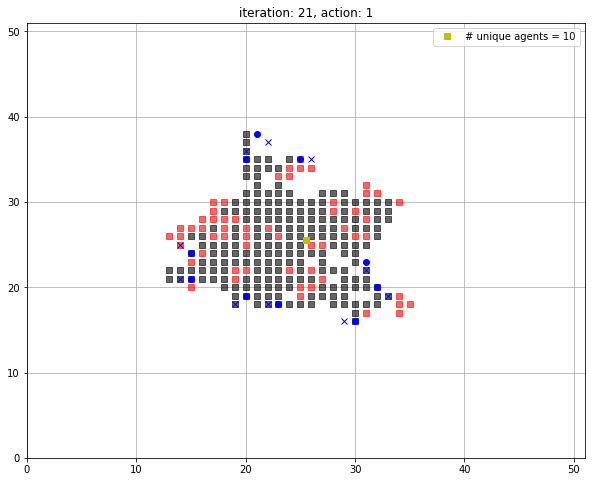

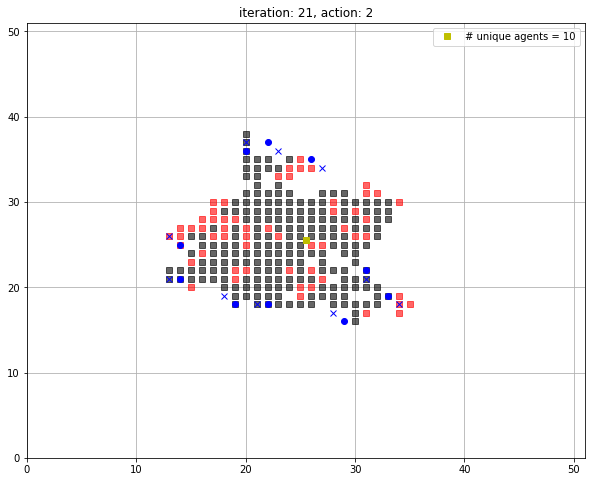

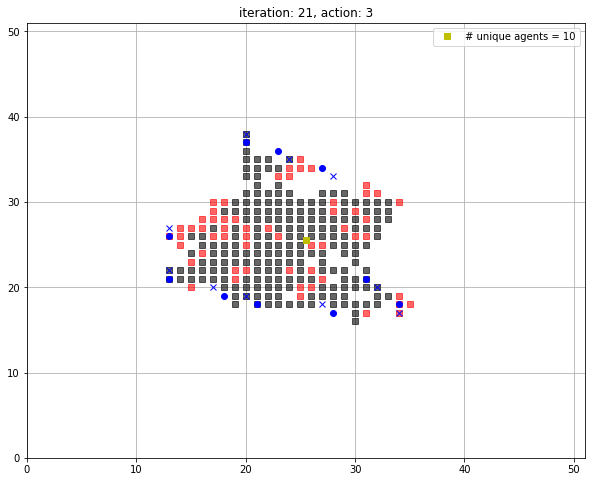

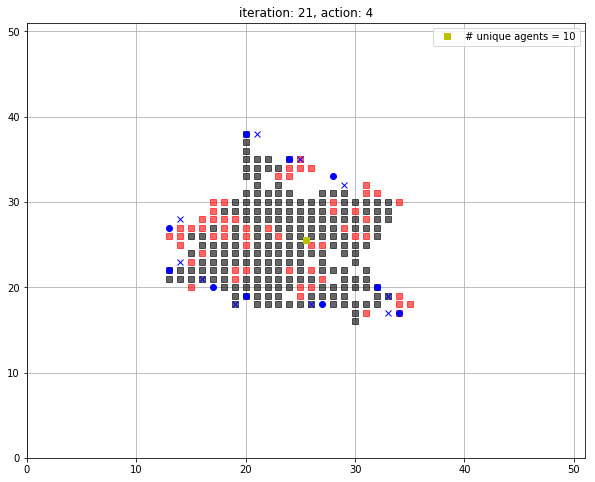

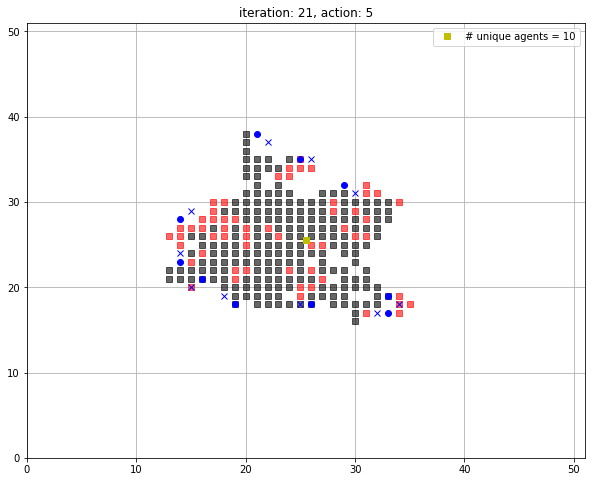

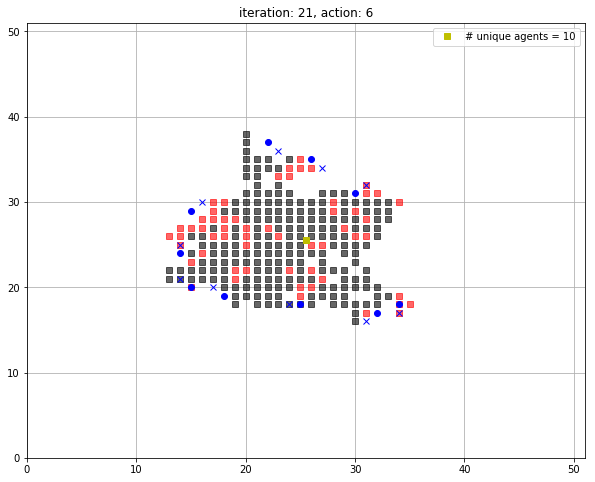

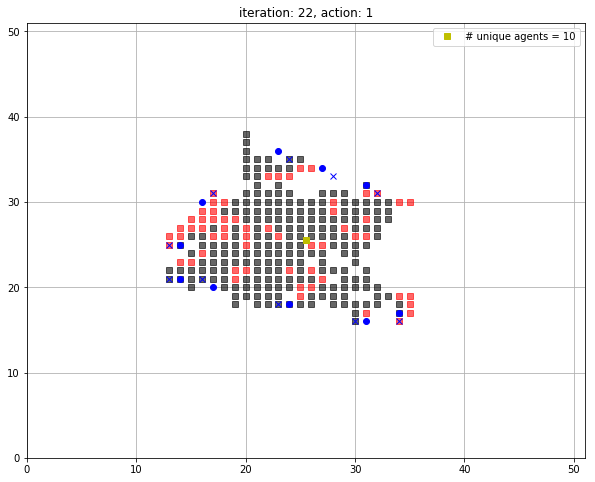

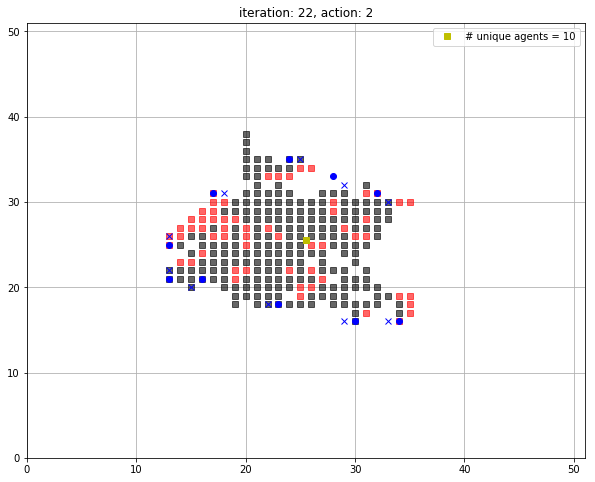

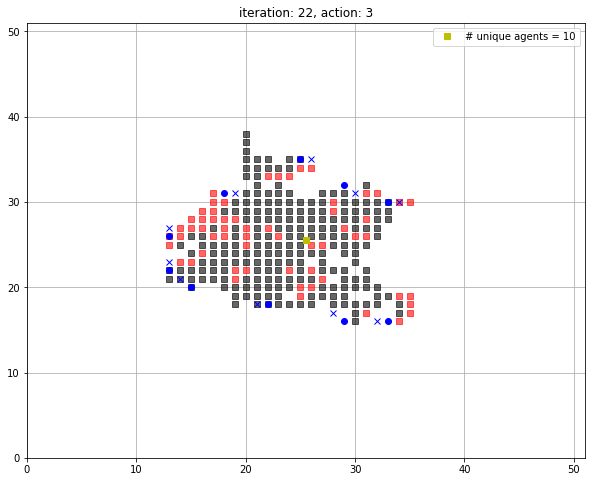

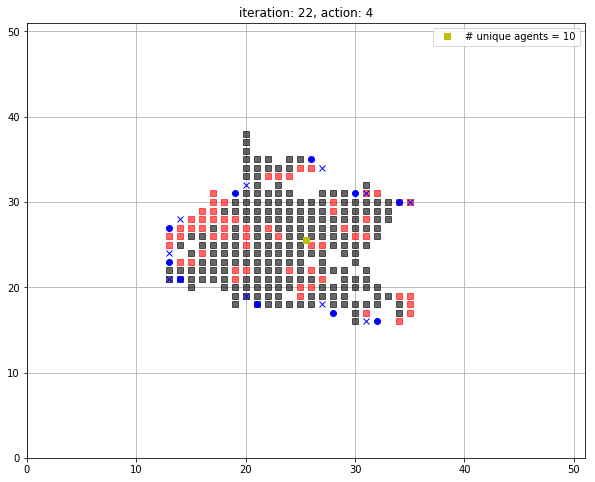

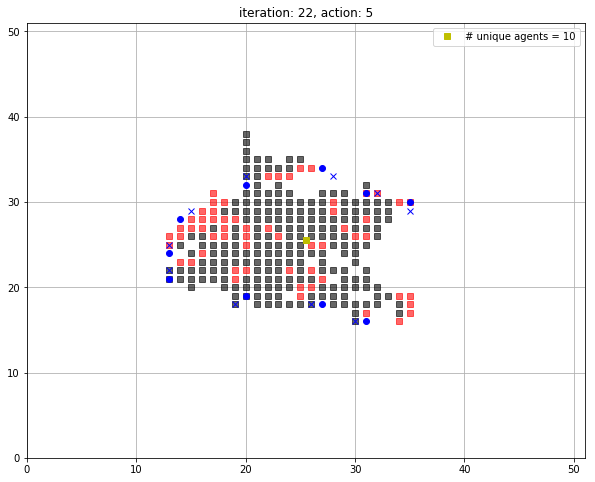

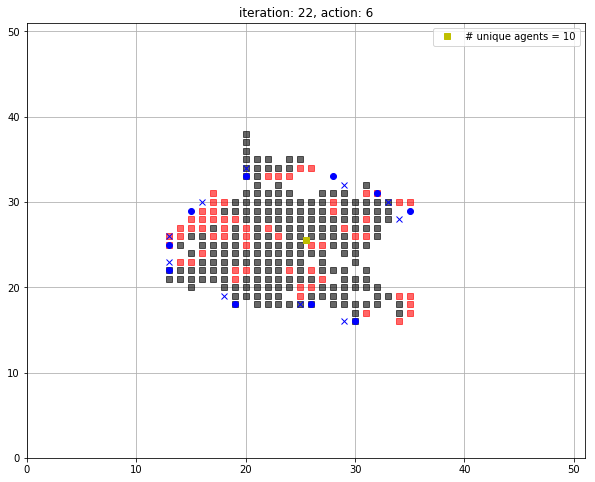

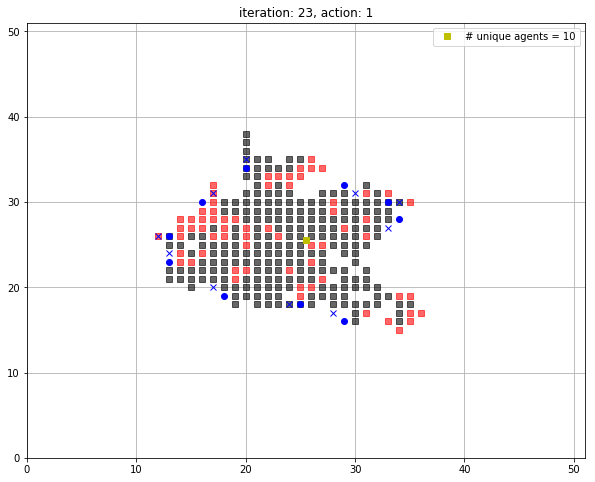

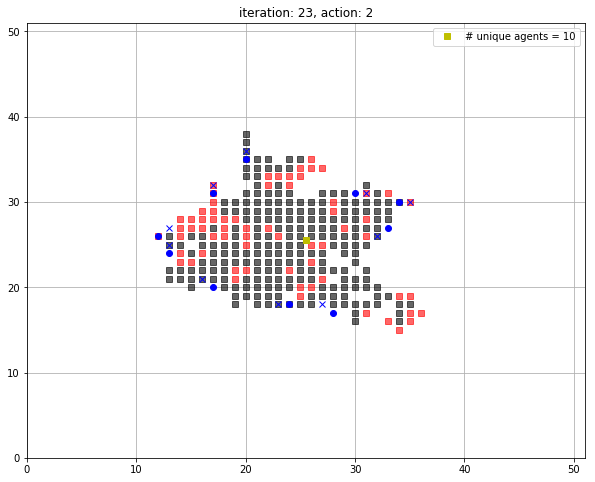

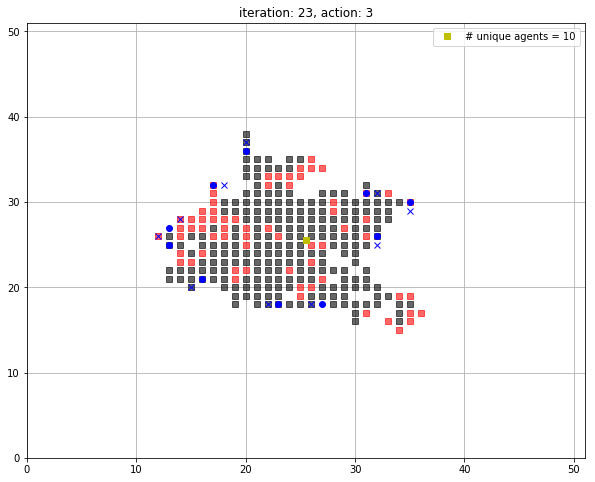

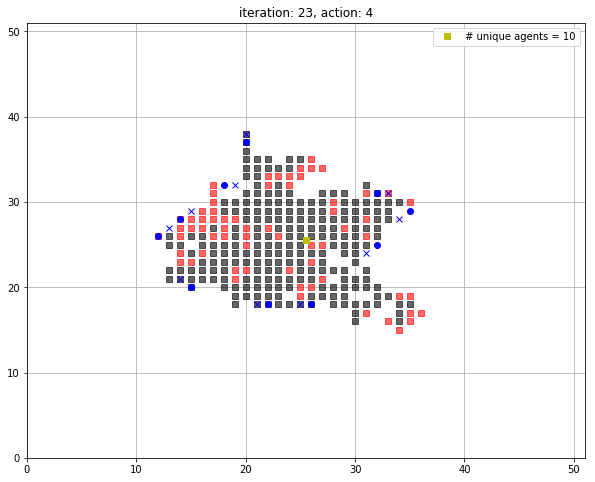

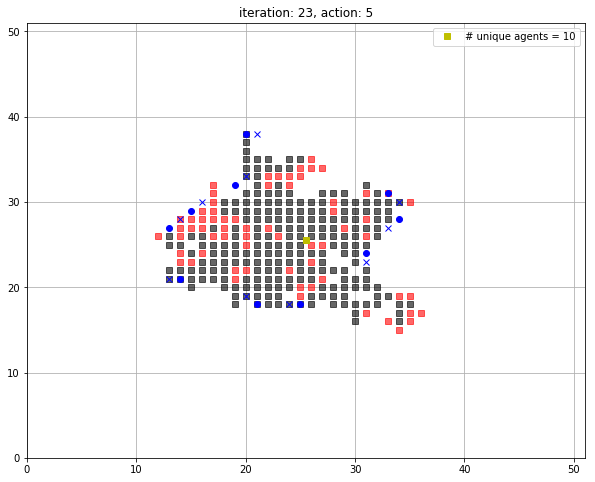

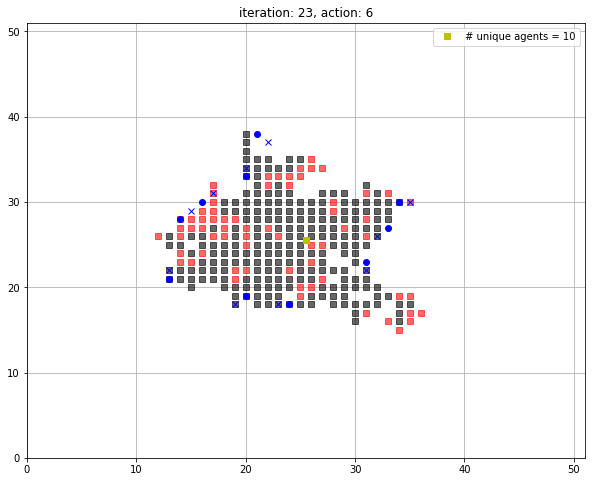

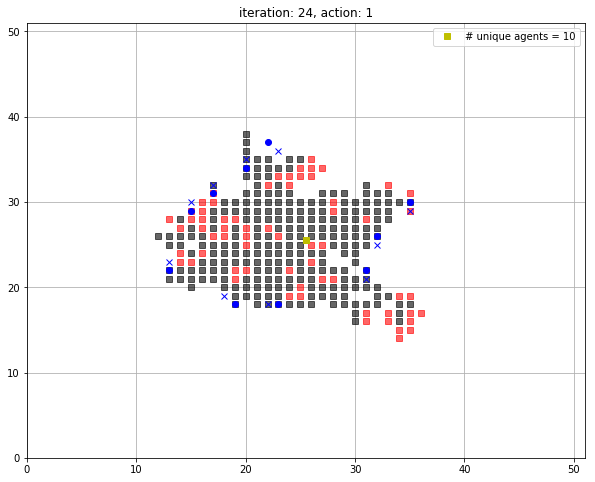

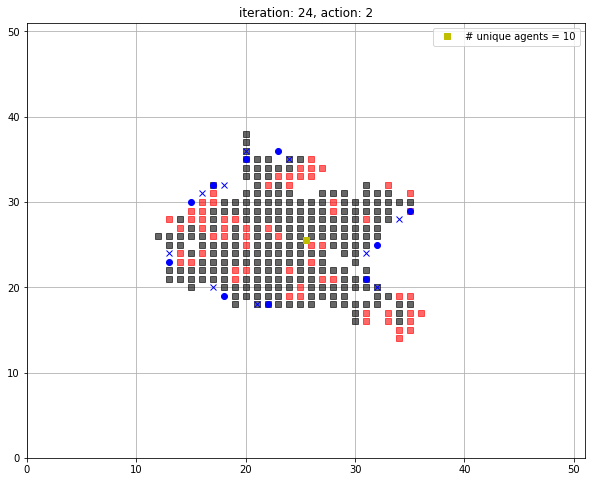

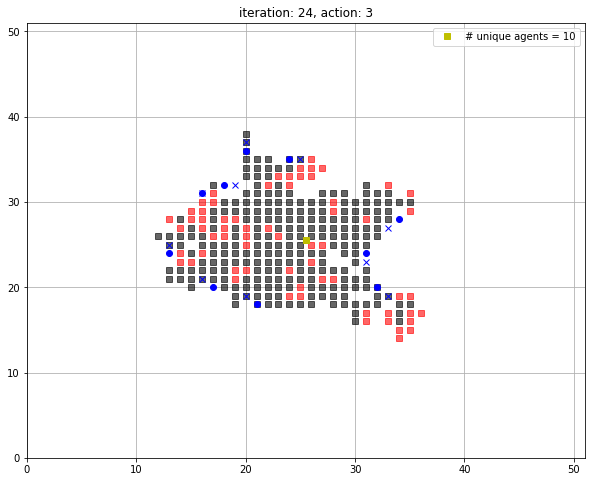

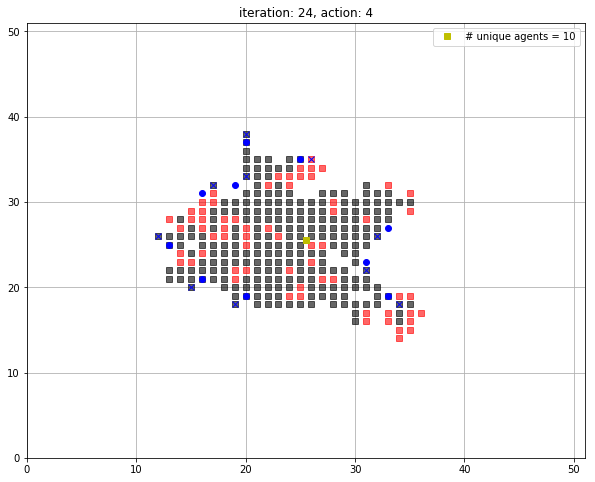

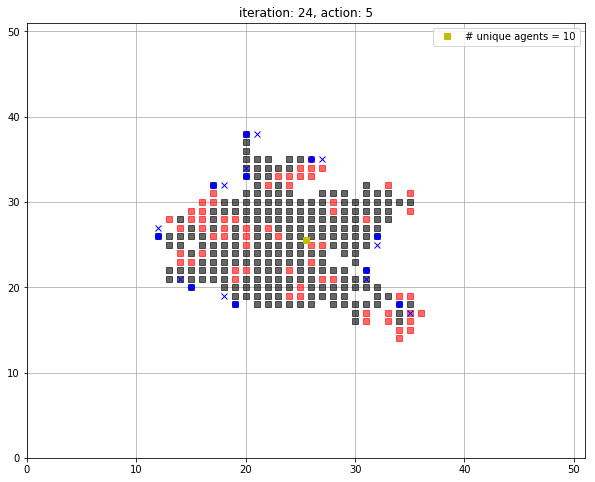

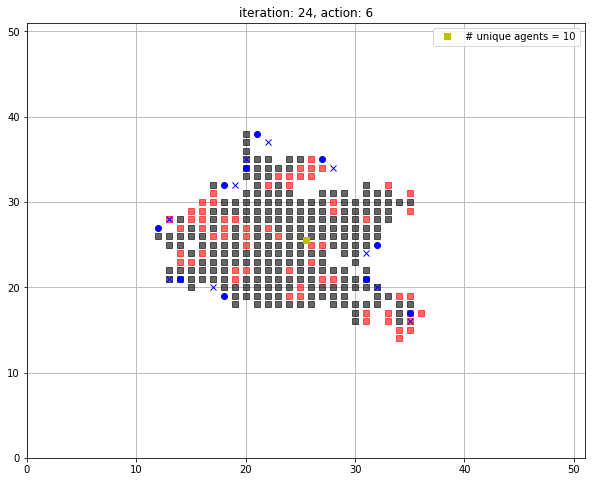

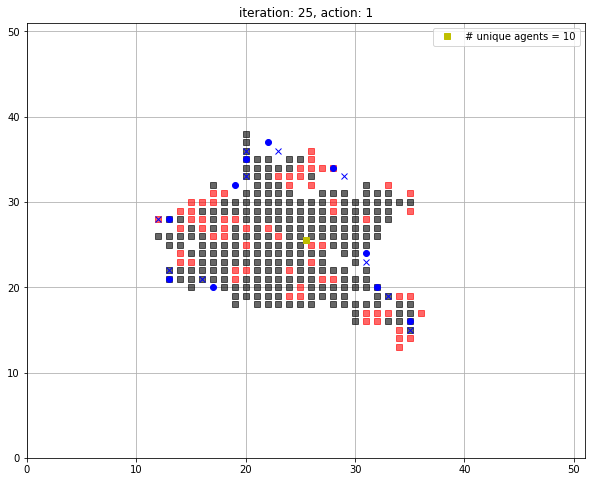

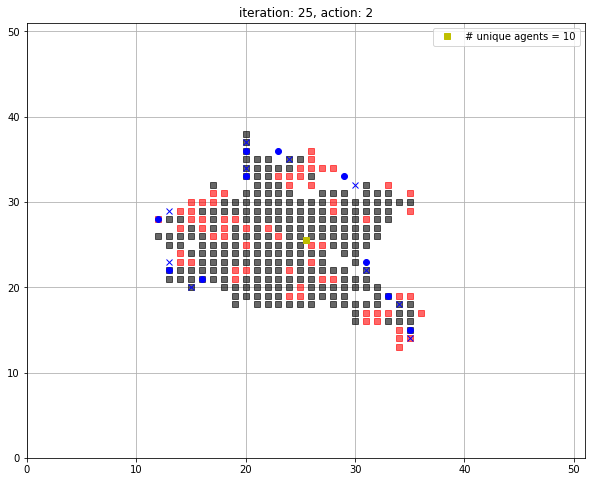

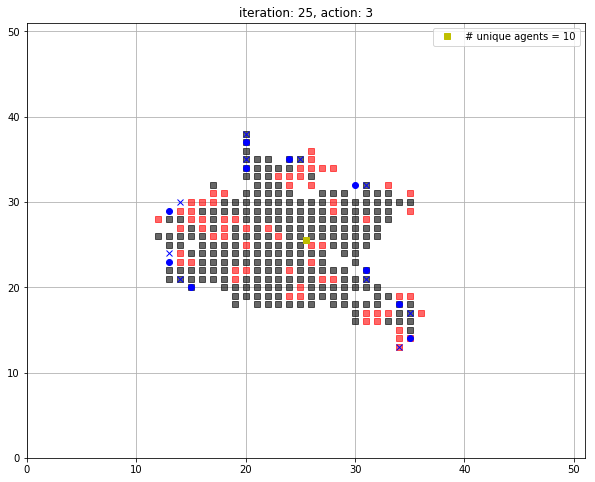

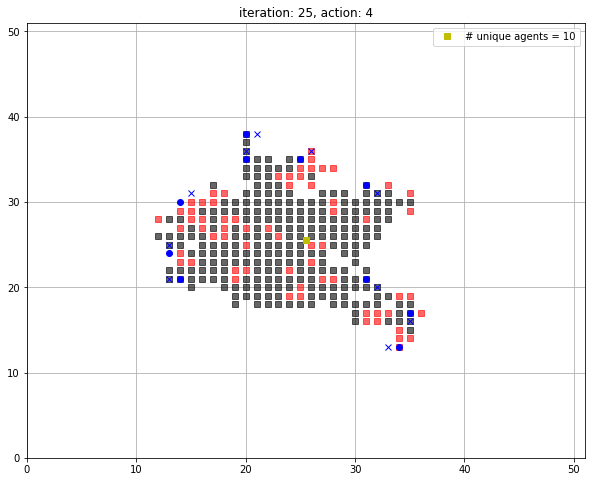

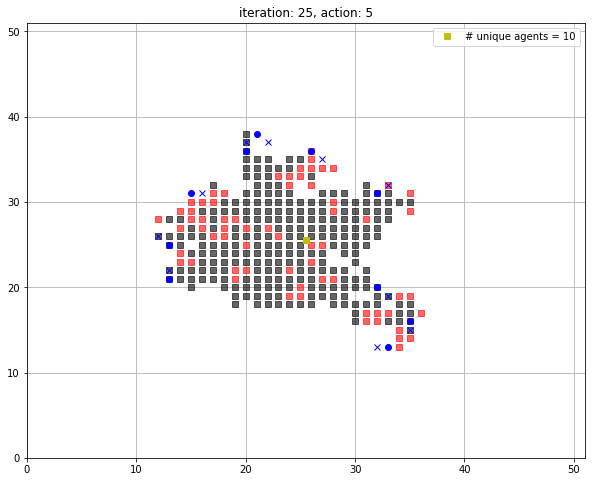

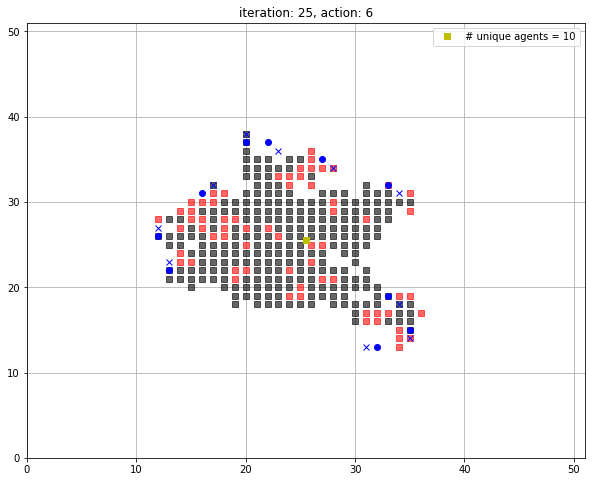

In [38]:
plt.close("all")
plotting = True

tic = time.clock()
# set rng seed
s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([])

# initialize agent positions
# n = np.squeeze(np.random.choice(num_agents, 1))
n = num_agents
agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
agent_pos = agent_pos.astype(np.int32)

control = []
repeat_cntr = 1
agent_sf = {}
for k in range(n):
    agent_sf[k] = False

# run simulation
#while not sim.end:
for _ in range(150):
    if plotting:
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d, action: %d' % (sim.iter,repeat_cntr))

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6)

    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    # generate control for each agent
    for k in range(n):
        # generate image
        img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

        # generate action and resulting trajectory using heuristic
        dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i!=k]
        min_dist, min_id, min_pos = min(dists)
        traj, act, sf = heuristic(k, agent_pos[k,:], img_st, agent_sf[k], center, min_id, min_pos)
        agent_sf[k] = sf

        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj))

        #if k == 0:
            #print(img_st)
        if plotting:
            plt.plot(traj[0][0],traj[0][1],"bo")
            plt.plot(traj[-1][0],traj[-1][1],"bx")
        #for (x,y) in traj:
        #    plt.plot(x,y,"bo")

        #for (x,y) in other_traj:
        #    plt.plot(x,y,"b^")

        # store agent's new position
        new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

    # remove duplicates from control sequence
    control = list(set(control))

    # step simulator
    #sim.step(control, dbeta=dp)
    if repeat_cntr % act_repeat == 0:
        sim.step(control, dbeta=dp)
        control = []
        repeat_cntr = 1
    else:
        repeat_cntr += 1

    # update agent position
    agent_pos = new_agent_pos

    if plotting:
        #plt.legend(['%d' %(len(set(tuple(x) for x in agent_pos)))])
        plt.plot(center,center,"ys",label='# unique agents = %d' %(len(set(tuple(x) for x in agent_pos))))
        plt.legend()

    #if sim.end:
    #    print('breaking early because game ended')
    #    break

    #if len(set(tuple(x) for x in agent_pos)) < n:
    #    print('agents merged!')
    #    #plt.plot(23,24,"yo")
    #    break

print("episode stats: %s, %f" %(sim.stats,sim.stats[0]/np.sum(sim.stats)))
print('# unique agents left = %d' %(len(set(tuple(x) for x in agent_pos))))
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

Benchmark heuristic solution by running many simulations

In [7]:
num_agents = 10
seeds = range(200)

results = []

In [8]:
tic = time.clock()
# run many simulations
for i,s in enumerate(seeds):
    np.random.seed(s)

    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([])

    # initialize agent positions
    # n = np.squeeze(np.random.choice(num_agents, 1))
    n = num_agents
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)

    control = []
    repeat_cntr = 1
    agent_sf = {}
    for k in range(n):
        agent_sf[k] = False

    # run simulation
    while not sim.end:
    #for _ in range(6*6):
    
        new_agent_pos = np.zeros((n,2)).astype(np.int32)

        # generate control for each agent
        for k in range(n):
            # generate image
            img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

            # generate action and resulting trajectory using heuristic
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i!=k]
            min_dist, min_id, min_pos = min(dists)
            traj, act, sf = heuristic(k, agent_pos[k,:], img_st, agent_sf[k], center, min_id, min_pos)
            agent_sf[k] = sf

            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))

            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

        # remove duplicates from control sequence
        control = list(set(control))

        # step simulator
        #sim.step(control, dbeta=dp)
        if repeat_cntr % act_repeat == 0:
            sim.step(control, dbeta=dp)
            control = []
            repeat_cntr = 1
        else:
            repeat_cntr += 1

        # update agent position
        agent_pos = new_agent_pos

    #print("[seed %3d] episode stats: %s, %f" %(s,sim.stats,sim.stats[0]/np.sum(sim.stats)))
    #print('# unique agents left = %d' %(len(set(tuple(x) for x in agent_pos))))
    if (i+1) % 10 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

finished 10 simulations
finished 20 simulations
finished 30 simulations
finished 40 simulations
finished 50 simulations
finished 60 simulations
finished 70 simulations
finished 80 simulations
finished 90 simulations
finished 100 simulations
finished 110 simulations
finished 120 simulations
finished 130 simulations
finished 140 simulations
finished 150 simulations
finished 160 simulations
finished 170 simulations
finished 180 simulations
finished 190 simulations
finished 200 simulations
932.11s = 15.54m elapsed


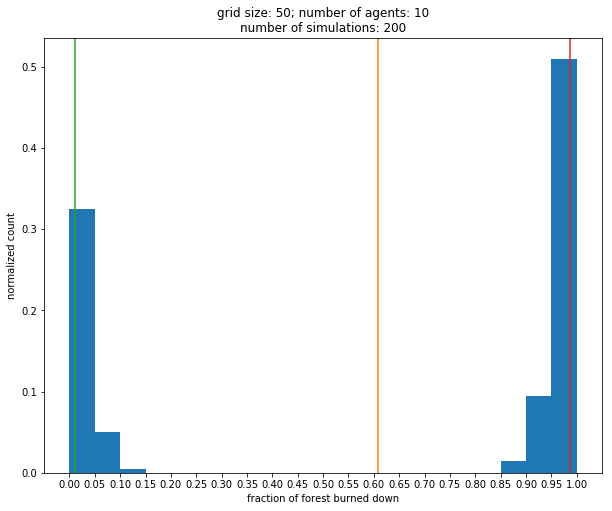

In [9]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.mean(results),color="C1",label="mean")
plt.axvline(np.percentile(results,0),color="C2",label="min")
plt.axvline(np.percentile(results,100),color="C3",label="max")

plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('grid size: %d; number of agents: %d\nnumber of simulations: %d' %(grid_size,num_agents,len(results)))
# plt.legend(loc=1)

# Reward function

In [10]:
def eelfff_reward(agent_id, traj, seen_fire, img_st, center, close_agent_id, close_pos):
    reward = 0
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    img_dim = img_st.shape[0]
    
    x1,y1 = traj[0]
    x2,y2 = traj[1]
    
    r = -y2 + y1 + img_dim//2
    c = x2 - x1 + img_dim//2
    
    if img_st[r,c] in [1,2]:
        counter = 0
        for (dr,dc) in fire_neigh:
            rn = r + dr
            cn = c + dc
            if img_st[rn,cn]==0:
                counter += 1
        
        if counter > 0:
            reward += 0.1
        else:
            reward += -1      
            #print('didnt move to a boundary node!')
    
    elif not seen_fire:
        if np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
            reward += 0.1
        else:
            reward += -1
            #print('didnt move closer to center!')
            
    if np.linalg.norm(traj[1]-close_pos,2) <= 1 and agent_id > close_agent_id:
        reward += -1      
        #print('failed to cooperate!')
    
    return reward

test reward function with heuristic solution

In [39]:
num_agents = 10
seed = 13

In [41]:
plt.close("all")
plotting = False

tic = time.clock()
# set rng seed
s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([])

# initialize agent positions
# n = np.squeeze(np.random.choice(num_agents, 1))
n = num_agents
agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
agent_pos = agent_pos.astype(np.int32)

ep_rew = 0
control = []
repeat_cntr = 1
agent_sf = {}
for k in range(n):
    agent_sf[k] = False

# run simulation
while not sim.end:
#for _ in range(150):
    if plotting:
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d, action: %d' % (sim.iter,repeat_cntr))

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6)

    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    # generate control for each agent
    for k in range(n):
        # generate image
        img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

        # generate action and resulting trajectory using heuristic
        dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i!=k]
        min_dist, min_id, min_pos = min(dists)
        traj, act, sf = heuristic(k, agent_pos[k,:], img_st, agent_sf[k], center, min_id, min_pos)
        agent_sf[k] = sf
        
        # calculate agent reward
        reward = eelfff_reward(k, traj, sf, img_st, center, min_id, min_pos)
        ep_rew += reward

        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj))

        #if k == 0:
            #print(img_st)
        if plotting:
            plt.plot(traj[0][0],traj[0][1],"bo")
            plt.plot(traj[-1][0],traj[-1][1],"bx")
        #for (x,y) in traj:
        #    plt.plot(x,y,"bo")

        #for (x,y) in other_traj:
        #    plt.plot(x,y,"b^")

        # store agent's new position
        new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

    # remove duplicates from control sequence
    control = list(set(control))

    # step simulator
    #sim.step(control, dbeta=dp)
    if repeat_cntr % act_repeat == 0:
        sim.step(control, dbeta=dp)
        control = []
        repeat_cntr = 1
    else:
        repeat_cntr += 1

    # update agent position
    agent_pos = new_agent_pos

    if plotting:
        #plt.legend(['%d' %(len(set(tuple(x) for x in agent_pos)))])
        plt.plot(center,center,"ys",label='# unique agents = %d' %(len(set(tuple(x) for x in agent_pos))))
        plt.legend()

    #if sim.end:
    #    print('breaking early because game ended')
    #    break

    #if len(set(tuple(x) for x in agent_pos)) < n:
    #    print('agents merged!')
    #    #plt.plot(23,24,"yo")
    #    break

print("after %d simulation steps:" %(sim.iter))
print("average reward: %0.2f" %(ep_rew/(n*sim.iter)))
print("episode stats: %s, %f" %(sim.stats,sim.stats[0]/np.sum(sim.stats)))
print('# unique agents left = %d' %(len(set(tuple(x) for x in agent_pos))))
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

after 180 simulation steps:
average reward: 0.16
episode stats: [  50    0 2450], 0.020000
# unique agents left = 10
5.58s = 0.09m elapsed


# Fit a network to the heuristic solution

network architecture

In [13]:
torch.cuda.is_available()

True

In [14]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor

In [15]:
class eelfff_net(nn.Module):
    """
    network to approximate Q function
    """
    def __init__(self, img_dim=8):
        self.img_dim = img_dim
        self.num_poss_actions = 9
        
        C, H, W = 1, img_dim, img_dim
        hidden_dim = 2048
        
        # conv layer settings
        nf1 = 32; nf2 = 64; nf3 = 64;
        fs1 = 4; fs2 = 3; fs3 = 2;
        cv_s1 = 1; cv_s2 = 1; cv_s3 = 1;
        cv_p1 = 0; cv_p2 = 0; cv_p3 = 0;
        
        # pool layer settings
        #p_sz1 = 4; p_sz2 = 2
        #p_st1 = 1; p_st2 = 1
        
        # calculate affine layer size
        Hp1 = 1 + (H + 2*cv_p1 - fs1) // cv_s1
        Wp1 = Hp1
        #Hpp1 = 1 + (Hp1 - p_sz1) // p_st1
        #Wpp1 = Hpp1
        
        Hp2 = 1 + (Hp1 + 2*cv_p2 - fs2) // cv_s2
        Wp2 = Hp2
        #Hpp2 = 1 + (Hp2 - p_sz2) // p_st2
        #Wpp2 = Hpp2
        
        Hp3 = 1 + (Hp2 + 2*cv_p3 - fs3) // cv_s3
        Wp3 = Hp3        
        
        #aff_flat_size = nf2*Hpp2*Wpp2 + 2*act_seq
        # image + id + position + seen_fire + center + close_id + close_pos
        aff_flat_size = nf3*Hp3*Wp3 + 1 + 2 + 1 + 2 + 1 + 2
        
        #print(Hp1)
        #print(Hp2)
        #print(Hp3)
        
        super(eelfff_net, self).__init__()
        # cnn structure
        self.cnn = nn.Sequential(
                        nn.Conv2d(C, nf1, kernel_size=fs1, stride=cv_s1, padding=cv_p1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(nf1, nf2, kernel_size=fs2, stride=cv_s2, padding=cv_p2),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(nf2, nf3, kernel_size=fs3, stride=cv_s3, padding=cv_p3),
                        nn.ReLU(inplace=True),
                        #nn.MaxPool2d(p_sz1,stride=p_st1),
                        #nn.Conv2d(nf1, nf2, kernel_size=fs2, stride=cv_s2, padding=cv_p2),
                        #nn.ReLU(inplace=True),
                        #nn.MaxPool2d(p_sz2,stride=p_st2),
                        Flatten()
                    )
        
        # nonlinear structure
        self.aff = nn.Sequential(
                        nn.Linear(aff_flat_size, hidden_dim),
                        nn.ReLU(inplace=True),
                        #nn.Linear(hidden_dim, self.num_poss_actions*act_seq),
                        nn.Linear(hidden_dim, self.num_poss_actions)
                    )
        
    def forward(self, img, ide, pos, sf, center, close_ide, close_pos):
        img_exp = img.unsqueeze(0)
        img_exp = img_exp.unsqueeze(0)
        ide_exp = ide.unsqueeze(0)
        pos_exp = pos.unsqueeze(0)
        sf_exp = sf.unsqueeze(0)
        cen_exp = center.unsqueeze(0)
        cid_exp = close_ide.unsqueeze(0)
        cpo_exp = close_pos.unsqueeze(0)
        
        feat = self.cnn(img_exp)
        feat = torch.cat((feat, ide_exp, pos_exp, sf_exp, cen_exp, cid_exp, cpo_exp), dim=1)

        Q = self.aff(feat)
        
        #return Q.view(N,self.num_poss_actions,self.act_seq)
        return Q.view(N,self.num_poss_actions,-1)

test architecture with random data

In [16]:
tic = time.clock()
N = 1
img_dim = 8
model = eelfff_net(img_dim).type(dtype)

img = Variable(torch.randn(img_dim,img_dim).type(dtype))
ide = Variable(torch.ones(1).type(dtype))
pos = Variable(torch.randn(2).type(dtype))
sf = Variable((True*torch.ones(1)).type(dtype))
center = Variable(torch.randn(2).type(dtype))
cid = Variable(2*torch.ones(1)).type(dtype)
cpo = Variable(torch.randn(2).type(dtype))

Q = model(img, ide, pos, sf, center, cid, cpo)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([1, 9, 1])
459.35s = 7.66m elapsed for this test


Train the network by running simulations

In [57]:
# simulator and network parameters
grid_size = 50
num_agents = [2,5,10]
D = []
memory_size = 1000000 #1000000
min_exp_size = 5000 #100
dp = 0.15/0.2763
act_repeat = 6
img_dim = 8
center = (grid_size+1)/2
cen_var = Variable(center*torch.ones(2)).type(dtype)

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

# create network instance
model = eelfff_net(img_dim=img_dim).type(dtype)
target = eelfff_net(img_dim=img_dim).type(dtype)
updt_max = 5000 #500
dqn_updt_cntr = 1

# optimizer and its parameters
gamma = 0.99
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4, betas=(0.95,0.95), eps=0.01)

# loss function
loss_fn = torch.nn.MSELoss(size_average=False)

# plotting data
plot_avg_rew = []
plot_frac_burn = []
plot_loss_hist = []

In [63]:
num_agents = [2,5,10]
seeds = range(10,20)

In [64]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([])
    
    # initialize agent positions
    n = np.squeeze(np.random.choice(num_agents, 1))
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)
    
    ep_rew = 0
    control = []
    repeat_cntr = 1
    agent_sf = {}
    for k in range(n):
        agent_sf[k] = False
        
    # run to termination
    while not sim.end:
        
        #control = []
        new_agent_pos = np.zeros((n,2)).astype(np.int32)
        agent_data = {}
        
        # generate control for each agent
        for k in range(n):
            agent_data[k] = {}
            agent_data[k]['id'] = Variable(k*torch.ones(1)).type(dtype)
            agent_data[k]['pos'] = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype)
            agent_data[k]['sf'] = Variable(agent_sf[k]*torch.ones(1)).type(dtype)
            
            # generate and save image
            img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
            agent_data[k]['img'] = Variable(torch.from_numpy(img)).type(dtype)

            # find nearest neighbor and their position, and save it
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i != k]
            _, min_id, min_pos = min(dists)
            agent_data[k]['other_id'] = Variable(min_id*torch.ones(1)).type(dtype)
            agent_data[k]['other_pos'] = Variable(torch.from_numpy(min_pos)).type(dtype)
            
            # always use heuristic to generate and save actions
            traj, act, sf = heuristic(k, agent_pos[k,:], img_st, agent_sf[k], center, min_id, min_pos)
            agent_sf[k] = sf
            agent_data[k]['act'] = act 
            agent_data[k]['next_sf'] = Variable(sf*torch.ones(1)).type(dtype)
            
            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))

            # calculate and store reward for agent
            reward = eelfff_reward(k, traj, sf, img_st, center, min_id, min_pos)
            agent_data[k]['reward'] = reward
            ep_rew += reward
                        
            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

            
        # remove duplicates from control sequence
        control = list(set(control))
        
        # step simulator
        if repeat_cntr % act_repeat == 0:
            sim.step(control, dbeta=dp)
            control = []
            repeat_cntr = 1
        else:
            repeat_cntr += 1
                    
        # update agent position
        agent_pos = new_agent_pos
        
        # grab new state information and add to replay memory
        isterminal = False
        for k in range(n):
            # generate and save image
            next_img, _, _ = CreateImageBW(sim.state, agent_pos[k,:])
            agent_data[k]['next_img'] = Variable(torch.from_numpy(next_img)).type(dtype)
            agent_data[k]['next_pos'] = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype)
            
            # find nearest neighbor and their trajectory
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i != k]
            _, min_id, min_pos = min(dists)
            agent_data[k]['next_other_id'] = Variable(min_id*torch.ones(1)).type(dtype)
            agent_data[k]['next_other_pos'] = Variable(torch.from_numpy(min_pos)).type(dtype)
            
            # check for terminal state
            if sim.end:
                isterminal = True
                
            D.append((agent_data[k]['img'],agent_data[k]['id'],agent_data[k]['pos'],agent_data[k]['sf'],
                      agent_data[k]['other_id'],agent_data[k]['other_pos'],
                      agent_data[k]['act'],agent_data[k]['reward'],
                      agent_data[k]['next_img'],agent_data[k]['next_pos'],agent_data[k]['next_sf'],
                      agent_data[k]['next_other_id'],agent_data[k]['next_other_pos'],
                      isterminal))
                
        # create minibatch from replay memory
        loss = 0
        if len(D) < min_exp_size:
            continue

        batch_idxs = np.random.randint(0,high=len(D),size=batch_size)

        # calculate loss over batch
        # exp indices: 0-img, 1-id, 2-pos, 3-seen_fire, 4-other_id, 5-other_pos, 
        #              6-action, 7-reward, 
        #              8-next_img, 9-next_pos, 10-next_seen_fire, 11-next_other_id, 12-next_other_pos
        #              13-isterminal
        for idx in batch_idxs:
            exp = D[idx]
            # reward clipping
            #curr_rew = np.clip(exp[5],-5,5)
            curr_rew = exp[7]
            tt = Variable(curr_rew*torch.ones(1),requires_grad=False).type(dtype)
            
            img = exp[0]
            ide = exp[1]
            pos = exp[2]
            sf = exp[3]
            cid = exp[4]
            cpo = exp[5]
            actions = exp[6]
            
            Q = model(img, ide, pos, sf, cen_var, cid, cpo)[0]
            x = Q[torch.FloatTensor(actions).type(torch.cuda.LongTensor)]
            #x = Q[torch.from_numpy(actions)].diag().sum()
            
            isterminal = exp[13]
            if not isterminal:
                next_img = exp[8]
                next_pos = exp[9]
                next_sf = exp[10]
                next_cid = exp[11]
                next_cpo = exp[12]

                Q = target(next_img, ide, next_pos, next_sf, cen_var, next_cid, next_cpo)[0]
                maxQ = Q.max(dim=0)[0].sum()
                tt += Variable(gamma*maxQ.data, requires_grad=False).type(dtype)
            
            # error clipping
            #loss += (loss_fn(x, tt)).clamp(min=-5,max=5)
            loss += loss_fn(x, tt)

        loss /= batch_size
        plot_loss_hist.append(loss.data[0])

        # update network
        optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        #torch.nn.utils.clip_grad_norm(model.parameters(), 0.5) 
        #for param in model.parameters():
        #    param.grad.data.clamp_(-1,1)
        optimizer.step()
        
        # update target network, if appropriate
        if dqn_updt_cntr % updt_max == 0:
            target = copy.deepcopy(model)
            print('---DEBUG: updated target network')
            dqn_updt_cntr = 1
        else:
            dqn_updt_cntr += 1
        
        # drop from memory if too many elements
        if len(D) > memory_size:
            D = D[len(D)-memory_size:]
            
    avg_rew = ep_rew/(n*sim.iter)
    frac_burn = sim.stats[2]/np.sum(sim.stats)
    print("seed %03d - number of agents: %02d" %(s,n))
    print("           average reward: %0.2f" %(avg_rew))
    print("           episode stats: %s, %f" %(sim.stats,frac_burn))
    
    plot_avg_rew.append(avg_rew)
    plot_frac_burn.append(frac_burn)
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

seed 010 - number of agents: 05
           average reward: 0.30
           episode stats: [  47    0 2453], 0.981200
---DEBUG: updated target network
seed 011 - number of agents: 05
           average reward: 0.18
           episode stats: [  26    0 2474], 0.989600
seed 012 - number of agents: 10
           average reward: 0.25
           episode stats: [2428    0   72], 0.028800
seed 013 - number of agents: 10
           average reward: 0.27
           episode stats: [2416    0   84], 0.033600
seed 014 - number of agents: 02
           average reward: 0.16
           episode stats: [  10    0 2490], 0.996000
seed 015 - number of agents: 02
           average reward: 0.25
           episode stats: [  13    0 2487], 0.994800
seed 016 - number of agents: 05
           average reward: 0.24
           episode stats: [  26    0 2474], 0.989600
seed 017 - number of agents: 05
           average reward: 0.18
           episode stats: [  50    0 2450], 0.980000
---DEBUG: updated target networ

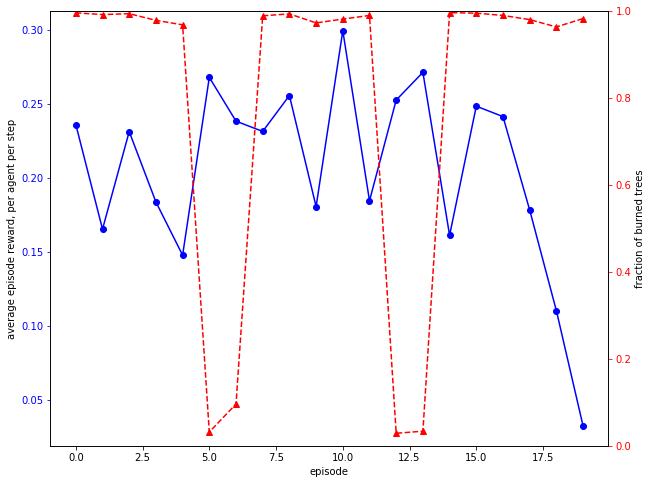

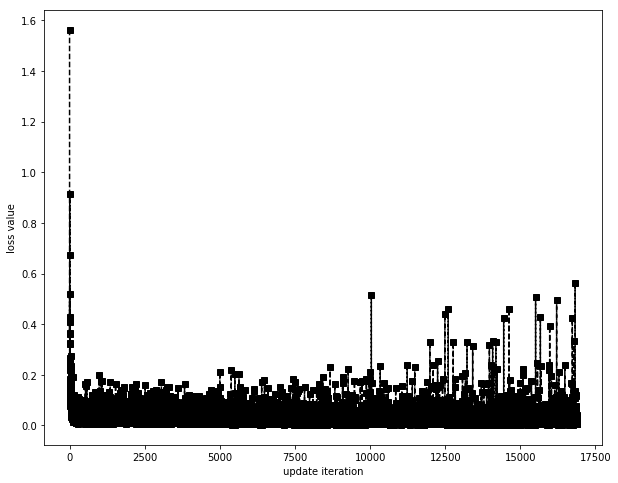

In [65]:
fig,ax1 = plt.subplots()
t = len(plot_avg_rew)
plt.plot(range(t),plot_avg_rew,'b-o')
ax1.set_xlabel('episode')
ax1.set_ylabel('average episode reward, per agent per step')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
plt.plot(range(t),plot_frac_burn,'r--^')
ax2.set_ylabel('fraction of burned trees')
ax2.tick_params('y', colors='r')
ax2.set_ylim([0,1])

fig = plt.figure()
plt.plot(range(len(plot_loss_hist)), plot_loss_hist, 'k--s')
plt.xlabel('update iteration')
plt.ylabel('loss value')

# Test the performance of the trained network

In [61]:
num_agents = 10
seed = 1

episode stats: [2476   22    2], 0.000800
# unique agents left = 10
0.85s = 0.01m elapsed


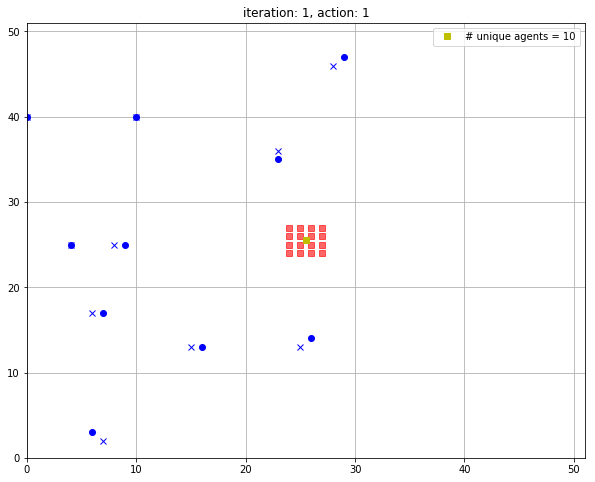

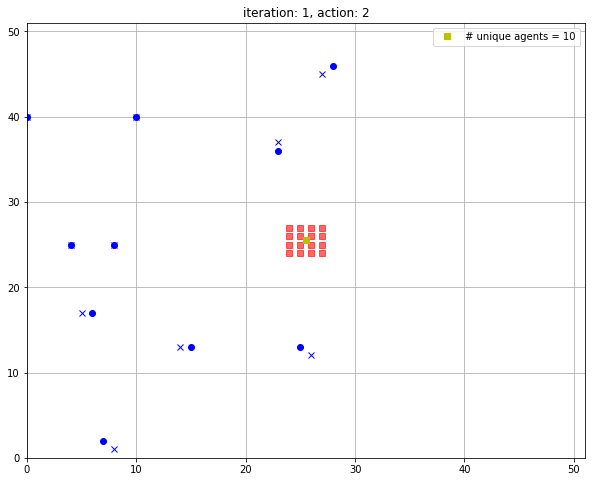

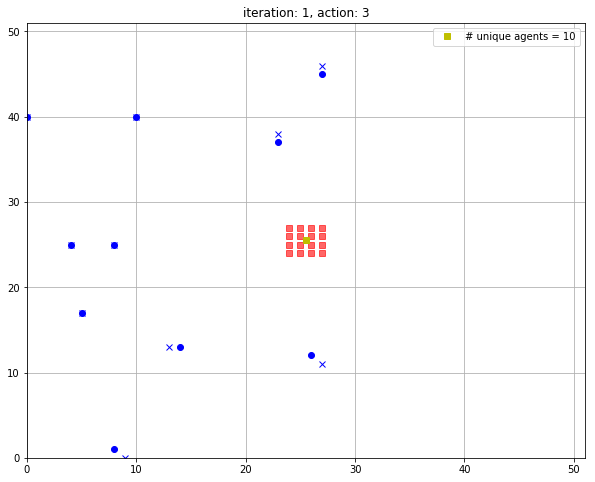

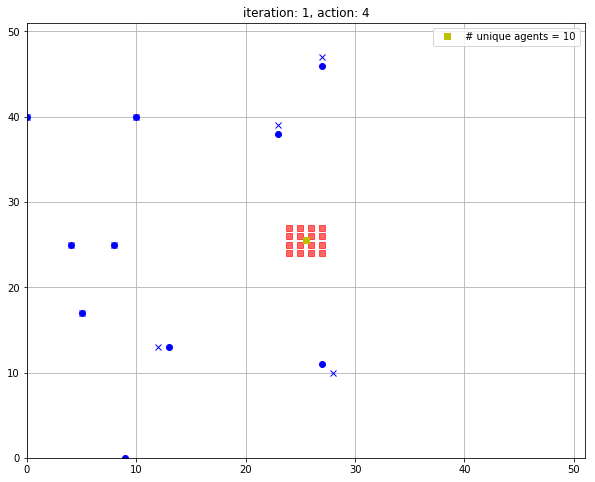

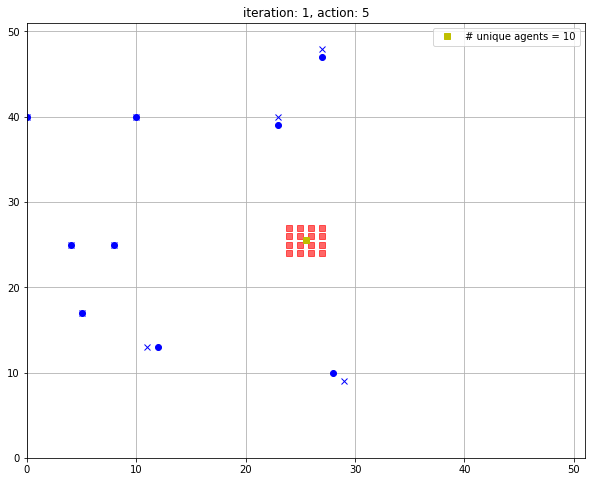

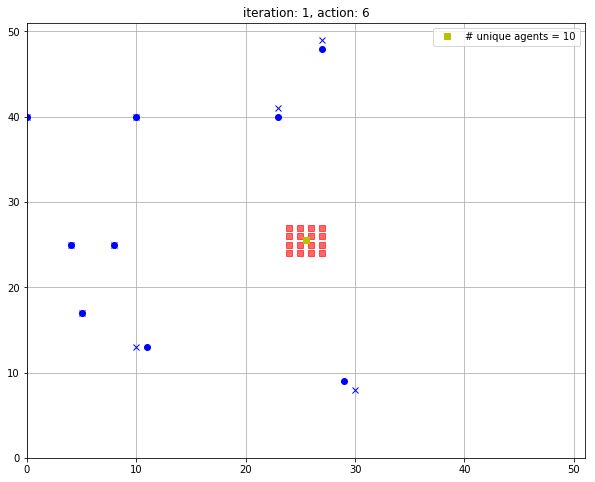

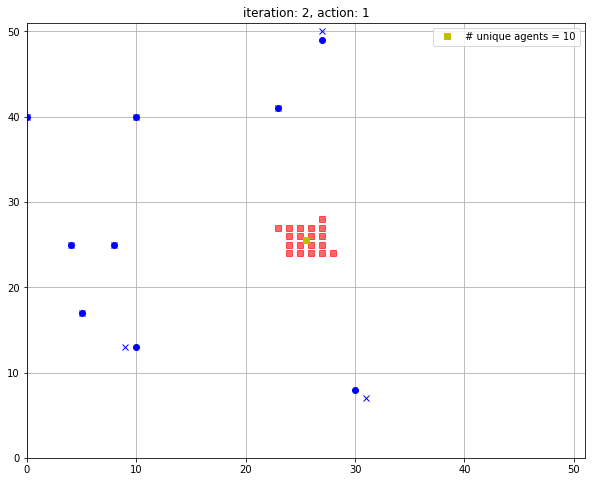

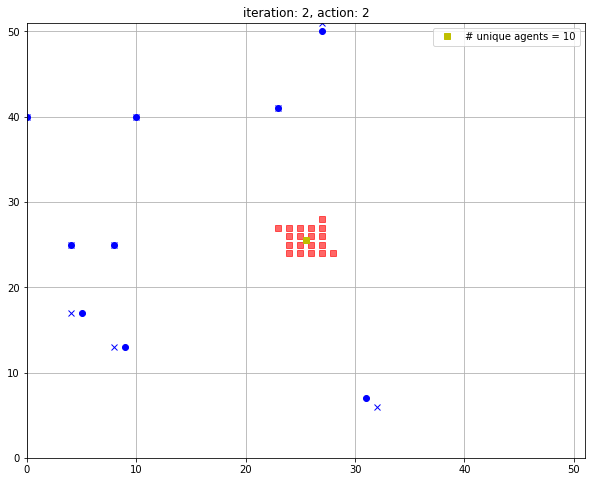

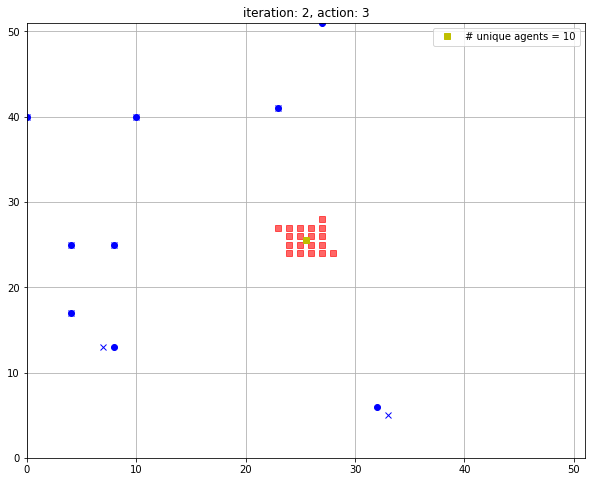

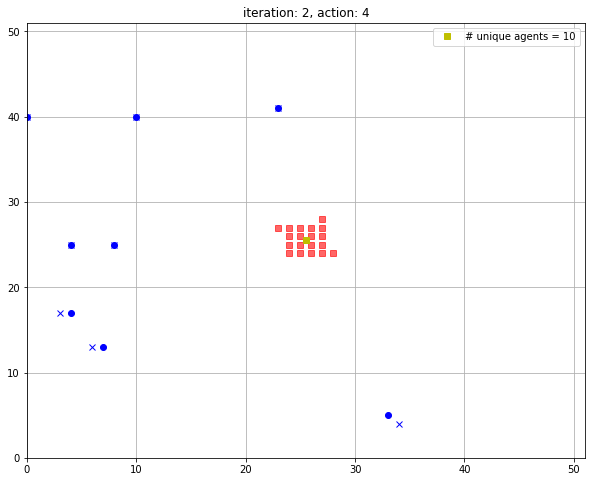

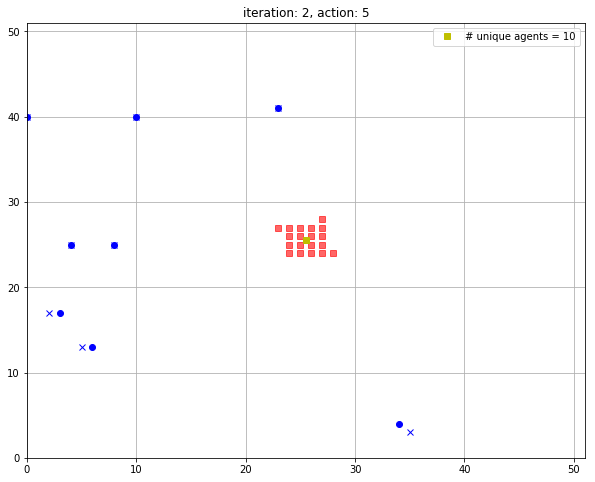

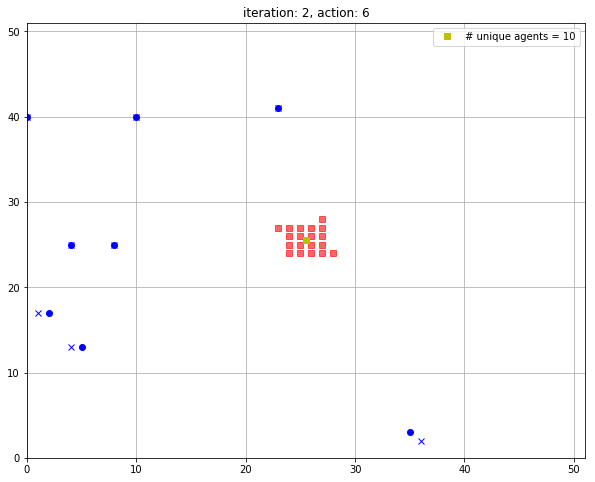

In [62]:
plt.close("all")
plotting = True

tic = time.clock()
# set rng seed
s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([])

# initialize agent positions
# n = np.squeeze(np.random.choice(num_agents, 1))
n = num_agents
agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
agent_pos = agent_pos.astype(np.int32)

control = []
repeat_cntr = 1
agent_sf = {}
for k in range(n):
    agent_sf[k] = False

# run simulation
#while not sim.end:
for _ in range(6*2):
    if plotting:
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d, action: %d' % (sim.iter,repeat_cntr))

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6)

    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    # generate control for each agent
    for k in range(n):
        # generate image
        img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

        # generate action and resulting trajectory using heuristic
        dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i,pos) for i,pos in enumerate(agent_pos) if i!=k]
        min_dist, min_id, min_pos = min(dists)
        
        # use network to generate action
        img_var = Variable(torch.from_numpy(img)).type(dtype)
        ide = Variable(k*torch.ones(1)).type(dtype)
        pos = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype)
        sf = Variable(agent_sf[k]*torch.ones(1)).type(dtype)
        cid = Variable(min_id*torch.ones(1)).type(dtype)
        cpo = Variable(torch.from_numpy(min_pos)).type(dtype)
        
        Q = model(img_var, ide, pos, sf, cen_var, cid, cpo)[0].data.cpu().numpy()
        act = np.argmax(Q, axis=0)
        traj = actions_to_trajectory(agent_pos[k,:], act)
        if img_st[img_dim//2,img_dim//2] in [1,2]:
            agent_sf[k] = True
        
        #traj, act, sf = heuristic(k, agent_pos[k,:], img_st, agent_sf[k], center, min_id, min_pos)
        #agent_sf[k] = sf

        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj))

        #if k == 0:
            #print(img_st)
        if plotting:
            plt.plot(traj[0][0],traj[0][1],"bo")
            plt.plot(traj[-1][0],traj[-1][1],"bx")
        #for (x,y) in traj:
        #    plt.plot(x,y,"bo")

        #for (x,y) in other_traj:
        #    plt.plot(x,y,"b^")

        # store agent's new position
        new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

    # remove duplicates from control sequence
    control = list(set(control))

    # step simulator
    #sim.step(control, dbeta=dp)
    if repeat_cntr % act_repeat == 0:
        sim.step(control, dbeta=dp)
        control = []
        repeat_cntr = 1
    else:
        repeat_cntr += 1

    # update agent position
    agent_pos = new_agent_pos

    if plotting:
        #plt.legend(['%d' %(len(set(tuple(x) for x in agent_pos)))])
        plt.plot(center,center,"ys",label='# unique agents = %d' %(len(set(tuple(x) for x in agent_pos))))
        plt.legend()

    #if sim.end:
    #    print('breaking early because game ended')
    #    break

    #if len(set(tuple(x) for x in agent_pos)) < n:
    #    print('agents merged!')
    #    #plt.plot(23,24,"yo")
    #    break

print("episode stats: %s, %f" %(sim.stats,sim.stats[2]/np.sum(sim.stats)))
print('# unique agents left = %d' %(len(set(tuple(x) for x in agent_pos))))
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

In [ ]:
# def heuristic_trajectory(pos, center, num_actions, img_st, hasfire, control):
#     trajectory = []
#     actions = []
#     trajectory.append((pos[0],pos[1]))
#     img_dim = img_st.shape[0]
    
#     if hasfire:
#         fires_r, fires_c = np.where(img_st==1)
#         neighbors = [(-1,0),(1,0),(0,1),(0,-1)]
#         fire = []
#         bdry = []
#         for r,c in zip(fires_r,fires_c):
#             counter = 0
#             for (dr,dc) in neighbors:
#                 rn = r + dr
#                 cn = c + dc
#                 if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] == 0:
#                     counter += 1
                    
#             x = col_to_x(c) - img_dim//2 + pos[0]
#             y = row_to_y(img_dim,r) - img_dim//2 + pos[1]
#             if counter >= 2 and (x,y) not in control:
#                 bdry.append((x,y))
#             elif (x,y) not in control:
#                 fire.append((x,y))
                
#         target = None
#         using_bdry = False
#         if len(bdry) > 0:
#             dists = [(np.abs(x-pos[0])+np.abs(y-pos[1]),(x,y)) for (x,y) in bdry]
#             using_bdry = True
#             target = min(dists)[1]
#         #elif len(fire) > 0:
#         #    dists = [(np.abs(x-pos[0])+np.abs(y-pos[1]),(x,y)) for (x,y) in fire]
#         #    target = min(dists)[1]
#         else:
#             target = trajectory[-1]
    
#         while len(trajectory) < num_actions+1:
#             loc = trajectory[-1]
#             if loc == target:
#                 if using_bdry:
#                     bdry.remove(target)
#                 #elif len(fire) > 0:
#                 #    fire.remove(target)
                    
#                 target = None
#                 using_bdry = False
#                 if len(bdry) > 0:
#                     dists = [(np.abs(x-loc[0])+np.abs(y-loc[1]),(x,y)) for (x,y) in bdry]
#                     target = min(dists)[1]
#                     using_bdry = True
#                 #elif len(fire) > 0:
#                 #    dists = [(np.abs(x-loc[0])+np.abs(y-loc[1]),(x,y)) for (x,y) in fire]
#                 #    target = min(dists)[1]
#                 else:
#                     target = trajectory[-1]
                    
#             dists = []
#             for a in range(9):
#                 new_loc = actions_to_trajectory(trajectory[-1],[a])[1]
#                 dists.append((np.abs(new_loc[0]-target[0])+np.abs(new_loc[1]-target[1]),new_loc,a))
                
#             trajectory.append(min(dists)[1])
#             actions.append(min(dists)[2])
#             #print(trajectory)
        
#     else:
#         for k in range(num_actions):
#             dists = []
#             for a in range(9):
#                 new_loc = actions_to_trajectory(trajectory[-1],[a])[1]
#                 dists.append((np.abs(center-new_loc[0])+np.abs(center-new_loc[1]),new_loc,a))
            
#             trajectory.append(min(dists)[1])
#             actions.append(min(dists)[2])
            
#     return trajectory, actions

In [ ]:
# def heuristic_trajectory(pos, img_st, center, close_pos, num_actions, grid_size, last_step, curr_agent):
#     #print('---')
#     #print(img_st)
#     traj = []
#     actions = []
#     traj.append((pos[0],pos[1]))
#     img_dim = img_st.shape[0]
#     fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
#     move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    
#     for k in range(num_actions):
#         dists = None
#         x,y = traj[k]
        
#         near_fire = False
#         #r = y_to_row(grid_size,y)
#         #c = x_to_col(x)  
#         r = img_dim//2
#         c = img_dim//2
#         for (dr,dc) in move_neigh:
#             rn = r + dr
#             cn = c + dc
#             if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [1,2]:
#                 near_fire = True
#                 break 
        
#         if near_fire:
#             cen_vec = np.array([x-center,y-center])
#             cen_vec = cen_vec/np.linalg.norm(cen_vec)
#             perp_vec = np.array([cen_vec[1],-cen_vec[0]])/np.linalg.norm(cen_vec)
#             #print(vec)
#             #print(perp_vec)

#             dists = []
#             for a in range(1,9):
#                 new_loc = actions_to_trajectory(traj[-1],[a])[1]
#                 r = -new_loc[1] + y + img_dim//2
#                 c = new_loc[0] - x + img_dim//2
                
#                 incntv = 0
#                 #if False and last_step and img_st[r,c]==0:
#                 #    #print(a,' ',last_step,' ',img_st[r,c])
#                 #    incntv += -2
#                 #    
#                 #elif False and not last_step and img_st[r,c]==1:
#                 #    counter = 0
#                 #    for (dr,dc) in fire_neigh:
#                 #        rn = r + dr
#                 #        cn = c + dc
#                 #        if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn]==0:
#                 #            counter += 1
#                 #            
#                 #    if counter>=2:
#                 #        incntv += -5
#                 #    elif counter>=1:
#                 #        incntv += -3
#                 #        
#                 #elif False and not last_step and img_st[r,c]==0:
#                 #    incntv += -1
#                 #        
#                 #if np.linalg.norm(new_loc-close_pos,1)<=1:
#                 #    incntv += 2
                
#                 if img_st[r,c] in [1,2]:
#                     counter = 0
#                     for (dr,dc) in fire_neigh:
#                         rn = r + dr
#                         cn = c + dc
#                         if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn]==0:
#                             counter += 1
                            
                            
#                     if img_st[r,c] == 1:
#                         incntv += counter*-0.5
#                     else:
#                         incntv += counter*-0.25
                   
#                     #if counter==1 and img_st[r,c]==1:
#                     #    incntv += -1.25
#                     #elif counter>=2 and img_st[r,c]==1:
#                     #    incntv += -1.75
#                     #elif counter>=2 and img_st[r,c]==2:
#                     #    incntv += -1
#                     #else:
#                     #   incntv += -0.5

#                 move_vec = np.array([new_loc[0]-x,new_loc[1]-y])
#                 if a != 0:
#                     move_vec = move_vec/np.linalg.norm(move_vec)
#                 #print(a,' ',incntv)
                
#                 #dists.append((np.linalg.norm(perp_vec-move_vec)+incntv,new_loc,a))
#                 dists.append((np.cross(cen_vec,move_vec)+incntv,new_loc,a))
                
#                 #if curr_agent == 4:
#                 #    print(dists)

#             #print(img_st)
#             #print(dists)
#             #5/0
                
#             #traj.append(min(dists)[1])
#             #actions.append(min(dists)[2])
#             #pot_pos = min(dists)[1]
            
            
#         else:
            
#             #if agent_dist <= -1:
#             #    traj.append(traj[-1])
#             #    actions.append(0)
#             #
#             #else:
#                 #print('moving to center')
#             dists = []
#             for a in range(9):
#                 new_loc = actions_to_trajectory(traj[-1],[a])[1]
#                 incntv = 0
#                 #if np.linalg.norm(new_loc-close_pos,1)<=1:
#                 #    incntv += 2
#                 dists.append((np.abs(center-new_loc[0])+np.abs(center-new_loc[1])+incntv,new_loc,a))

#             #traj.append(min(dists)[1])
#             #actions.append(min(dists)[2])
            
#         #pot_pos = min(dists)[1]
#         #pot_act = min(dists)[2]
        
#         #if np.linalg.norm(pot_pos-close_pos,1)<=1: # or np.linalg.norm(traj[k]-close_pos,1)<=0.5:
#         #    #print('agent should stop')
#         #    traj.append(traj[-1])
#         #    actions.append(0)
#         #else:
#         #    traj.append(pot_pos)
#         #    actions.append(pot_act)
        
#         traj.append(min(dists)[1])
#         actions.append(min(dists)[2])
    
#     #print('---')
#     #print()
    
#     return traj, actions

In [ ]:
# def heuristic_trajectory(pos, img_st, center, close_pos, num_actions, grid_size, last_step, curr_agent):

#     traj = []
#     actions = []
#     traj.append((pos[0],pos[1]))
#     img_dim = img_st.shape[0]
#     fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
#     move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
#     action_set = [4,1,2,3,5,8,7,6]
    
#     for k in range(num_actions):
#         dists = None
#         x,y = traj[k]

#         r = img_dim//2
#         c = img_dim//2
        
#         if img_st[r,c] in [1,2]:
#             dists = []
#             cen_vec = np.array([x-center,y-center])
#             cen_vec = cen_vec/np.linalg.norm(cen_vec)
#             perp_vec = np.array([cen_vec[1],-cen_vec[0]])/np.linalg.norm(cen_vec)
            
#             #for a in range(1,9):
#             for idx,a in enumerate(action_set):
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 rl = -new_pos[1] + y + img_dim//2
#                 cl = new_pos[0] -x + img_dim//2
                
#                 if img_st[rl,cl] == 0:
#                     continue
                    
#                 move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
#                 if a != 0:
#                     move_vec = move_vec/np.linalg.norm(move_vec)
                
#                 score = 0
                
#                 if np.cross(cen_vec,move_vec)<0:
#                     #print(a,' ',cen_vec,' ',move_vec,' ',np.cross(cen_vec,move_vec))
#                     score += -0.5

#                 #bdry = False
#                 #for (dr,dc) in fire_neigh:
#                 #    rn = rl + dr
#                 #    cn = cl + dc
#                 #    if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn]==0:
#                 #        bdry = True
#                 #        break
#                 counter = 0
#                 for (dr,dc) in fire_neigh:
#                     rn = rl + dr
#                     cn = cl + dc
#                     if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn]==0:
#                         counter += 1
                
#                 #if bdry:
#                 #    score += -0.75
#                 #else:
#                 #    continue
                
#                 #if counter==0:
#                 #    continue
#                 if counter==1:
#                     score += -0.75
#                 elif counter>=2:
#                     score += -0.85
                    
#                 score += -0.01*(len(action_set)-idx)
#                 #print(a,' ',score)

#                 dists.append((score,new_pos,a))
                
#             #print(dists)
#             #print()
            
#         else:
#             dists = []
#             for a in range(9):
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))
        
#         traj.append(min(dists)[1])
#         actions.append(min(dists)[2])
        
#     return traj, actions

In [ ]:
# def heuristic_trajectory(pos, img_st, center, close_pos, num_actions, grid_size, last_step, curr_agent):

#     traj = []
#     actions = []
#     traj.append((pos[0],pos[1]))
#     img_dim = img_st.shape[0]
#     fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
#     move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
#     action_set = [4,1,2,3,5,8,7,6]
    
#     for k in range(num_actions):
#         dists = None
#         x,y = traj[k]

#         r = img_dim//2
#         c = img_dim//2
        
#         near_fire = False
#         for (dr,dc) in move_neigh:
#             rn = r + dr
#             cn = c + dc
#             if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [1,2]:
#                 near_fire = True
#                 break
        
#         if img_st[r,c] in [1,2] or near_fire:
#             dists = []
#             action_set = None
#             ang = np.arctan2(y-center,x-center)
#             if ang>=0 and ang<np.pi/4:
#                 quad=1
#                 action_set = [5,8,7,6]
#             elif ang>=np.pi/4 and ang<np.pi/2:
#                 quad=2
#                 action_set = [3,5,8,7]
#             elif ang>=np.pi/2 and ang<(3*np.pi)/4:
#                 quad=3
#                 action_set = [2,3,5,8]
#             elif ang>=(3*np.pi)/4:
#                 quad=4
#                 action_set = [1,2,3,5]
#             elif ang<=(-3*np.pi)/4:
#                 quad=5
#                 action_set = [4,1,2,3]
#             elif ang>(-3*np.pi)/4 and ang<=(-np.pi/2):
#                 quad=6
#                 action_set = [6,4,1,2]
#             elif ang>(-np.pi/2) and ang<=(-np.pi/4):
#                 quad=7
#                 action_set = [7,6,4,1]
#             elif ang>(-np.pi/4) and ang<0:
#                 quad=8
#                 action_set = [8,7,6,4]

#             '''
#             if ang>=0 and ang<np.pi/2:
#                 quad=1
#                 #action_set = [2,3,5,8,7]
#                 action_set = [3,5,8,7,6]
#             elif ang>=np.pi/2:
#                 quad=2
#                 action_set = [1,2,3,5,8]
#             elif ang<0 and ang>-np.pi/2:
#                 quad=4
#                 #action_set = [7,6,4,1,2,8]
#                 action_set = [8,7,6,4,1]
#             elif ang<=-np.pi/2:
#                 quad=3
#                 #action_set = [4,1,2,3,5,6]
#                 action_set = [6,4,1,2,3]
#             '''
                
#             for a in action_set:
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 rl = -new_pos[1] + y + img_dim//2
#                 cl = new_pos[0] -x + img_dim//2
                
#                 if img_st[rl,cl] == 0:
#                     continue
                    
#                 counter = 0
#                 for (dr,dc) in fire_neigh:
#                     rn = rl + dr
#                     cn = cl + dc
#                     if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn]==0:
#                         counter += 1
                        
#                 if counter>=1:
#                     dists.append((0,new_pos,a))
#                     break     
        
#             #print('quadrant = ',quad)
#             #print()

#         else:
#             dists = []
#             for a in range(9):
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))
        
#         #if not dists:
#         #    print('current agent = ', curr_agent)
#         #    print('agent position = ', pos)
#         #    print('quadrant = ', quad)
#         #    print('actions = ', action_set)
        
#         if not dists:
#             dists = []
#             cen_vec = np.array([x-center,y-center])
#             cen_vec = cen_vec/np.linalg.norm(cen_vec)
#             for a in range(1,9):
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
#                 if a != 0:
#                     move_vec = move_vec/np.linalg.norm(move_vec)
#                 dists.append((np.cross(cen_vec,move_vec),new_pos,a))
          
#         pot_act = min(dists)[2]
#         new_pos = actions_to_trajectory(traj[-1],[a])[1]
#         if np.linalg.norm(new_pos-close_pos,1)<=1:
#             traj.append(traj[-1])
#             actions.append(0)
#         else:        
#             traj.append(min(dists)[1])
#             actions.append(min(dists)[2])
        
#     return traj, actions

In [ ]:
# def heuristic_trajectory(pos, img_st, center, close_pos, num_actions, grid_size, last_step, curr_agent, seen_fire):

#     traj = []
#     actions = []
#     traj.append((pos[0],pos[1]))
#     img_dim = img_st.shape[0]
#     fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
#     move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
#     action_set = [4,1,2,3,5,8,7,6]
    
#     for k in range(num_actions):
#         dists = None
#         x,y = traj[k]

#         r = img_dim//2
#         c = img_dim//2
        
#         #elif near_fire:
#         if img_st[r,c] in [1,2] or seen_fire:
#             seen_fire = True
            
#             #near_fire = False
#             #for (dr,dc) in move_neigh:
#             #    rn = r + dr
#             #    cn = c + dc
#             #    if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [1,2]:
#             #        near_fire = True
#             #        break
                    
#             counter = 0
#             for (dr,dc) in move_neigh:
#                 rn = r + dr
#                 cn = c + dc
#                 if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [1,2]:
#                     counter += 1
            
            
#             if last_step and counter>=7:
#                 dists = []
#                 for a in range(9):
#                     new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                     dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))

#                 traj.append(max(dists)[1])
#                 actions.append(max(dists)[2])
                
#             elif False and last_step and counter<=4:
#                 dists = []
#                 for a in range(9):
#                     new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                     dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))

#                 traj.append(min(dists)[1])
#                 actions.append(min(dists)[2])
                
#             else:
                
#                 dists = []
#                 cen_vec = np.array([x-center,y-center])
#                 cen_vec = cen_vec/np.linalg.norm(cen_vec)
#                 for a in range(1,9):
#                     new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                     move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
#                     if a != 0:
#                         move_vec = move_vec/np.linalg.norm(move_vec)
#                     dists.append((np.cross(cen_vec,move_vec),new_pos,a))

#                 traj.append(min(dists)[1])
#                 actions.append(min(dists)[2])      
                
#             '''

            
#             if counter<=3:
#                 dists = []
#                 for a in range(9):
#                     new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                     dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))

#                 traj.append(min(dists)[1])
#                 actions.append(min(dists)[2])
                
#             elif counter>=7:
#                 dists = []
#                 for a in range(9):
#                     new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                     dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))

#                 traj.append(max(dists)[1])
#                 actions.append(max(dists)[2])
            
#             else:
#             '''


#         else:
#             dists = []
#             for a in range(9):
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))
                
#             traj.append(min(dists)[1])
#             actions.append(min(dists)[2])
        
#     return traj, actions, seen_fire

In [ ]:
def heuristic_trajectory(pos, img_st, center, close_pos, num_actions, grid_size, 
                         last_step, curr_agent, close_agent_id, seen_fire):

    traj = []
    actions = []
    traj.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    action_set = [4,1,2,3,5,8,7,6]
    
    for k in range(num_actions):
        dists = None
        x,y = traj[k]

        r = img_dim//2
        c = img_dim//2
        
        near_fire = False
        for (dr,dc) in move_neigh:
            rn = r + dr
            cn = c + dc
            if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [1,2]:
                near_fire = True
                break
        
        if img_st[r,c] in [1,2] or seen_fire:
            seen_fire = True
        
            dists = []
            cen_vec = np.array([x-center,y-center])
            cen_vec = cen_vec/np.linalg.norm(cen_vec)
            for a in range(1,9):
            #for a in [2,5,7,4]:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                
                rl = -new_pos[1] + y + img_dim//2
                cl = new_pos[0] -x + img_dim//2
                #if a in [1,3,8,6] and img_st[rl,cl] in [0]:
                #    continue
                
                move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
                if a != 0:
                    move_vec = move_vec/np.linalg.norm(move_vec)
                dists.append((np.cross(cen_vec,move_vec),new_pos,a))
            

            cir_pos = min(dists)[1]
            cir_act = min(dists)[2]
                
            ri = -cir_pos[1] + y + img_dim//2
            ci = cir_pos[0] -x + img_dim//2
            
            left_act = None
            if cir_act==1:
                left_act = [6,4]
                #left_act = [4]
                righ_act = [2]
            elif cir_act==2:
                left_act = [4,1]
                #left_act = [1]
                righ_act = [3]
            elif cir_act==3:
                left_act = [1,2]
                #left_act = [2]
                righ_act = [5]
            elif cir_act==5:
                left_act = [2,3]
                #left_act = [3]
                righ_act = [8]
            elif cir_act==8:
                left_act = [3,5]
                #left_act = [5]
                righ_act = [7]
            elif cir_act==7:
                left_act = [5,8]
                #left_act = [8]
                righ_act = [6]
            elif cir_act==6:
                left_act = [8,7]
                #left_act = [7]
                righ_act = [4]
            elif cir_act==4:
                left_act = [7,6]
                #left_act = [6]
                righ_act = [1]
            
            '''
            left_act = None
            if cir_act==2:
                #left_act = [3]
                left_act = [1]
            elif cir_act==5:
                #left_act = [8]
                left_act = [3]
            elif cir_act==7:
                #left_act = [6]
                left_act = [8]
            elif cir_act==4:
                #left_act = [1]
                left_act = [6]
            '''    
            #print(cir_act)
            #print(left_act)
            
            '''
            out_pos = actions_to_trajectory(traj[-1],[left_act[0]])[1]
            ro = -out_pos[1] + y + img_dim//2
            co = out_pos[0] - x + img_dim//2
            if img_st[ro,co] in [1,2]:
                cir_pos = out_pos
                cir_act = left_act[0]
            elif img_st[ri,ci] in [0]:
                cir_act = righ_act[0]
                cir_pos = actions_to_trajectory(traj[-1],[cir_act])[1]
            '''
                
            out = False
            for a in left_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                ro = -new_pos[1] + y + img_dim//2
                co = new_pos[0] - x + img_dim//2
                if img_st[ro,co] in [1]:
                    cir_pos = new_pos
                    cir_act = a
                    out = True
                    break
                    
            if not out:
                for a in left_act:
                    new_pos = actions_to_trajectory(traj[-1],[a])[1]
                    ro = -new_pos[1] + y + img_dim//2
                    co = new_pos[0] - x + img_dim//2
                    if img_st[ro,co] in [2]:
                        cir_pos = new_pos
                        cir_act = a
                        out = True
                        break

            counter = 0
            for (dr,dc) in move_neigh:
                rn = ri + dr
                cn = ci + dc
                if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [0]:
                    counter += 1

            if not out and img_st[ri,ci] in [0] and counter>=6:
                for a in righ_act:
                    new_pos = actions_to_trajectory(traj[-1],[a])[1]
                    cir_pos = new_pos
                    cir_act = a
                    
            if np.linalg.norm(cir_pos-close_pos,2)<=1 and curr_agent > close_agent_id:
                cir_pos = traj[-1]
                cir_act = 0
                    
#             rp = -cir_pos[1] + y + img_dim//2
#             cp = cir_pos[0] -x + img_dim//2
#             #if img_st[rp,cp] in [0,2]:
#             for a in left_act:
#                 new_pos = actions_to_trajectory(traj[-1],[a])[1]
#                 rl = -new_pos[1] + y + img_dim//2
#                 cl = new_pos[0] -x + img_dim//2

#                 if img_st[rl,cl] in [1]:
#                     cir_pos = new_pos
#                     cir_act = a
#                     break
                    
            #print(cir_act)
            #print()
            
            
            
            traj.append(cir_pos)
            actions.append(cir_act)      

        if not seen_fire:
            dists = []
            #for a in range(9):
            for idx,a in enumerate([2,5,7,4,1,3,8,6]):
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                incntv = -(8-idx)*0.1
                dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))
                
            #print(dists)
            #print()
            traj.append(min(dists)[1])
            actions.append(min(dists)[2])
        
    return traj, actions, seen_fire

In [ ]:
def heuristic_trajectory(pos, img_st, center, close_pos, num_actions, grid_size, 
                         last_step, curr_agent, close_agent_id, seen_fire, prev_action, hdng):

    traj = []
    actions = []
    traj.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    action_set = [4,1,2,3,5,8,7,6]
    
    for k in range(num_actions):
        dists = None
        x,y = traj[k]

        r = img_dim//2
        c = img_dim//2
        
        if img_st[r,c] in [1,2] or seen_fire:
            dists = []
            seen_fire = True
                
            if hdng==0:
                action_set = [1,2,3,5,8,7,6,4]
            elif hdng==45:
                action_set = [4,1,2,3,5,8,7,6]
            elif hdng==90:
                action_set = [6,4,1,2,3,5,8,7]
            elif hdng==135:
                action_set = [7,6,4,1,2,3,5,8]
            elif hdng==180:
                action_set = [8,7,6,4,1,2,3,5]
            elif hdng==225:
                action_set = [5,8,7,6,4,1,2,3]
            elif hdng==270:
                action_set = [3,5,8,7,6,4,1,2]
            elif hdng==315:
                action_set = [2,3,5,8,7,6,4,1]
                
            cir_pos = None
            cir_act = None

            for a in action_set:
                '''
                if prev_action==2 and a==7:
                    continue
                elif prev_action==3 and a==6:
                    continue
                elif prev_action==5 and a==4:
                    continue
                elif prev_action==8 and a==1:
                    continue
                elif prev_action==7 and a==2:
                    continue
                elif prev_action==6 and a==3:
                    continue
                elif prev_action==4 and a==5:
                    continue
                elif prev_action==1 and a==8:
                    continue
                '''
                
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                #if new_pos in prev_action:
                #    continue

                rl = -new_pos[1] + y + img_dim//2
                cl = new_pos[0] -x + img_dim//2

                if img_st[rl,cl]==0:
                    continue

                counter = 0
                for (dr,dc) in fire_neigh:
                    rn = rl + dr
                    cn = cl + dc
                    if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn]==0:
                        counter += 1

                if counter>0:
                    cir_pos = new_pos
                    cir_act = a
                    break   
                    
            if cir_pos is None:
                print(pos)
                print(img_st)
            
            if curr_agent > close_agent_id and np.linalg.norm(cir_pos-close_pos,2)<=1:
                cir_pos = traj[-1]
                cir_act = 0
                
                    
            traj.append(cir_pos)
            actions.append(cir_act)
            
            if cir_act==1:
                new_hdng = 135
            elif cir_act==2:
                new_hdng = 90
            elif cir_act==3:
                new_hdng = 45
            elif cir_act==5:
                new_hdng = 0
            elif cir_act==8:
                new_hdng = 315
            elif cir_act==7:
                new_hdng = 270
            elif cir_act==6:
                new_hdng = 225
            elif cir_act==4:
                new_hdng = 180
            elif cir_act==0:
                new_hdng = hdng
                    
        if not seen_fire:
            dists = []
            #for a in range(9):
            for idx,a in enumerate([2,5,7,4,1,3,8,6]):
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                incntv = -(8-idx)*0.1
                dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))
                
            #print(dists)
            #print()
            score,pos,act = min(dists)
            
            traj.append(pos)
            actions.append(act)
            
            if act==1:
                new_hdng = 135
            elif act==2:
                new_hdng = 90
            elif act==3:
                new_hdng = 45
            elif act==5:
                new_hdng = 0
            elif act==8:
                new_hdng = 315
            elif act==7:
                new_hdng = 270
            elif act==6:
                new_hdng = 225
            elif act==4:
                new_hdng = 180
        
    return traj, actions, seen_fire, new_hdng

## Network datatype [cpu/gpu]

In [ ]:
torch.cuda.is_available()

In [ ]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor

## Build the network

In [ ]:
class eelfff_net(nn.Module):
    """
    network to approximate Q function
    """
    def __init__(self, act_seq=6, img_dim=8):
        self.act_seq = act_seq
        self.img_dim = img_dim
        self.num_poss_actions = 9
        
        C, H, W = 1, img_dim, img_dim
        hidden_dim = 2048
        
        # conv layer settings
        nf1 = 32; nf2 = 64; nf3 = 64;
        fs1 = 4; fs2 = 3; fs3 = 2;
        cv_s1 = 1; cv_s2 = 1; cv_s3 = 1;
        cv_p1 = 0; cv_p2 = 0; cv_p3 = 0;
        
        # pool layer settings
        #p_sz1 = 4; p_sz2 = 2
        #p_st1 = 1; p_st2 = 1
        
        # calculate affine layer size
        Hp1 = 1 + (H + 2*cv_p1 - fs1) // cv_s1
        Wp1 = Hp1
        #Hpp1 = 1 + (Hp1 - p_sz1) // p_st1
        #Wpp1 = Hpp1
        
        Hp2 = 1 + (Hp1 + 2*cv_p2 - fs2) // cv_s2
        Wp2 = Hp2
        #Hpp2 = 1 + (Hp2 - p_sz2) // p_st2
        #Wpp2 = Hpp2
        
        Hp3 = 1 + (Hp2 + 2*cv_p3 - fs3) // cv_s3
        Wp3 = Hp3        
        
        #aff_flat_size = nf2*Hpp2*Wpp2 + 2*act_seq
        # image + other trajectory + center
        aff_flat_size = nf3*Hp3*Wp3 + 2*(act_seq+1) + 2
        
        #print(Hp1)
        #print(Hp2)
        #print(Hp3)
        
        super(eelfff_net, self).__init__()
        # cnn structure
        self.cnn = nn.Sequential(
                        nn.Conv2d(C, nf1, kernel_size=fs1, stride=cv_s1, padding=cv_p1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(nf1, nf2, kernel_size=fs2, stride=cv_s2, padding=cv_p2),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(nf2, nf3, kernel_size=fs3, stride=cv_s3, padding=cv_p3),
                        nn.ReLU(inplace=True),
                        #nn.MaxPool2d(p_sz1,stride=p_st1),
                        #nn.Conv2d(nf1, nf2, kernel_size=fs2, stride=cv_s2, padding=cv_p2),
                        #nn.ReLU(inplace=True),
                        #nn.MaxPool2d(p_sz2,stride=p_st2),
                        Flatten()
                    )
        
        # nonlinear structure
        self.aff = nn.Sequential(
                        nn.Linear(aff_flat_size, hidden_dim),
                        nn.ReLU(inplace=True),
                        #nn.Linear(hidden_dim, self.num_poss_actions*act_seq),
                        nn.Linear(hidden_dim, self.num_poss_actions)
                    )
        
    def forward(self, img, act, center):
        img_exp = img.unsqueeze(0)
        img_exp = img_exp.unsqueeze(0)
        act_exp = act.unsqueeze(0)
        cen_exp = center.unsqueeze(0)
        #hsf_exp = hasfire.unsqueeze(0)
        feat = self.cnn(img_exp)
        feat = torch.cat((feat, act_exp, cen_exp), dim=1)
        Q = self.aff(feat)
        
        #return Q.view(N,self.num_poss_actions,self.act_seq)
        return Q.view(N,self.num_poss_actions,-1)

test implementation of network with random data

In [ ]:
tic = time.clock()
N = 1
img_dim = 8
act_seq = 3
model = eelfff_net(act_seq, img_dim).type(dtype)

img = torch.randn(img_dim,img_dim).type(dtype)
act = torch.randn(2*(act_seq+1)).type(dtype)
center = torch.randn(2).type(dtype)
hasfire = (True*torch.ones(1)).type(dtype)

img_var = Variable(img)
act_var = Variable(act)
center_var = Variable(center)
# hasfire_var = Variable(hasfire)

Q = model(img_var, act_var, center_var)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

## Define a reward function

In [ ]:
# def eelfff_reward(states, trajs, fire_flags, other_trajs):
#     N = len(states)
#     grid_size = states[0].shape[0]
#     center = math.ceil(grid_size/2)
#     neighbors = [(-1,0),(0,-1),(1,0),(0,1)]
#     #reward = Variable(torch.zeros(1), requires_grad=True).type(dtype)
#     reward = 0
    
#     for n in range(N):
#         st = states[n]
#         traj = trajs[n]
#         other_traj = other_trajs[n]
#         has_fires = fire_flags[n]
#         n_rew = 0
        
#         # reward for treating fires and boundary fires
#         # that weren't already treated by the agent
#         if has_fires:
#             treated = []
#             for (x,y) in traj:
#                 r = y_to_row(grid_size,y)
#                 c = x_to_col(x)

#                 # reward for treating a fire
#                 if r>=0 and r<grid_size and c>=0 and c<grid_size and st[r,c]==1 and (x,y) not in treated:
#                     n_rew += 1

#                     counter = 0 
#                     for (dc,dr) in neighbors:
#                         rn = r + dr
#                         cn = c + dc
#                         if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and st[rn,cn] == 0:
#                             counter += 1

#                     # bonus for treating a boundary fire
#                     if counter >= 2:
#                         n_rew += 2
#                     #    print('treated a boundary fire')
#                     #else:
#                     #    print('treated a normal fire')
                        
#                     treated.append((x,y))
                
#                 elif (x,y) in treated:
#                     n_rew += -3
                
#                 else:
#                     n_rew += -1
           
#         # reward for approaching center [if no fires in image]
#         else:
#             #x_end, y_end = traj[-1]
#             #n_rew -= np.abs(x_end-center) + np.abs(y_end-center)
            
#             for k in range(len(traj)-1):
#                 x1, y1 = traj[k]
#                 x2, y2 = traj[k+1]
#                 #if np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
#                 #    reward += 1.0/(len(traj)-1)
#                 #    #print('made it closer to the center')
                
#                 if np.abs(x2-center)+np.abs(y2-center) >= np.abs(x1-center)+np.abs(y1-center):
#                     n_rew += -2
#                 elif np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
#                     n_rew += 1
    
#         # penalty for intersecting with 'nearest agent'
#         #if not set(traj).isdisjoint(other_traj):
#         #    #reward += -2*len(set(traj).intersection(other_traj))
#         #    n_rew = -4
#         #    #print('intersected with a friends path :(')
#         #else:
#         #    n_rew += 0.1
            
#         reward += n_rew
    
#     return reward/N

In [ ]:
# tic = time.clock()

# states = np.zeros((3,5,5)).astype(np.uint8)
# states[:,2,2] = 1
# trajs = []
# trajs.append([(5,5),(5,5),(4,4)])
# trajs.append([(3,3),(3,3),(3,3)])
# trajs.append([(5,5),(4,4),(3,3)])
# other_trajs = []
# other_trajs.append([(1,1),(1,2),(1,1)])
# other_trajs.append([(1,1),(1,2),(1,3)])
# other_trajs.append([(1,1),(2,2),(3,3)])
# fire_flags = [False, True, True]

# reward = eelfff_reward(states, trajs, fire_flags, other_trajs)
# print('minibatch reward: %0.2f' %reward)

# toc = time.clock()
# print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

In [ ]:
def eelfff_reward(state, traj, other_traj, control):
    grid_size = state.shape[0]
    center = math.ceil(grid_size/2)
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(0,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)]
    reward = 0
    
    #for idx, (x,y) in traj:   
    for k in range(len(traj)-1):
        x1, y1 = traj[k]
        x2, y2 = traj[k+1]
        
        near_fire = False
        for (dx,dy) in move_neigh:
            r = y_to_row(grid_size,y1+dy)
            c = x_to_col(x1+dx)
            
            if r>=0 and r<grid_size and c>=0 and c<grid_size and state[r,c]==1:
                near_fire = True
                break
        
        #print(near_fire)
        if near_fire:
            r = y_to_row(grid_size,y2)
            c = x_to_col(x2)
            
            if r>=0 and r<grid_size and c>=0 and c<grid_size and state[r,c]==1 and (x2,y2) not in control:
                counter = 0 
                for (dc,dr) in fire_neigh:
                    rn = r + dr
                    cn = c + dc
                    if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and state[rn,cn] == 0:
                        counter += 1
                        
                if counter >= 2:
                    #print('treated boundary')
                    reward += 0.1
                else:
                    #print('did not treat boundary fire')
                    reward -= 1
            else:
                #print('close to fire but didnt treat it')
                reward -= 1
            
        elif np.abs(x2-center)+np.abs(y2-center) < np.abs(x1-center)+np.abs(y1-center):
            #print('moved closer to center')
            reward += 0.1
        else:
            #print('failed all objectives')
            reward -= 1
            
    # penalty for intersecting with 'nearest agent'
    if not set(traj).isdisjoint(other_traj):
        #reward += -2*len(set(traj).intersection(other_traj))
        reward -= 1
        #print('intersected with a friends path :(')
    else:
        reward += 0.1

        
    return reward

In [ ]:
tic = time.clock()

state = np.zeros((5,5)).astype(np.uint8)
state[2,2] = 1
traj = [(5,5),(5,5),(4,4),(3,3)]
other_traj = [(1,1),(1,2),(1,1)]
control = []

reward = eelfff_reward(state, traj, other_traj, control)
print('reward: %0.2f' %reward)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

## Train the network

In [ ]:
# simulator and network parameters
grid_size = 50
num_agents = [2,5,10]
D = []
memory_size = 100000
min_exp_size = 50
dp = 0.15/0.2763
act_seq = 1
act_repeat = 6
other_act_seq = act_repeat//2
img_dim = 8
center = math.ceil(grid_size/2)
cen_var = Variable(center*torch.ones(2)).type(dtype)

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

# create network instance
model = eelfff_net(act_seq=act_seq, img_dim=img_dim).type(dtype)
target = eelfff_net(act_seq=act_seq, img_dim=img_dim).type(dtype)
updt_max = 250
dqn_updt_cntr = 1

# optimizer and its parameters
gamma = 0.95
# eps_init = 1
# eps_finl = 0.1
# epsilon = eps_init #0.15
# anneal_range = 10000
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [ ]:
num_agents = [6]
seeds = [1]

In [ ]:
tic = time.clock()
# run simulator many times
for s in seeds:
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    
    # initialize agent positions
    n = np.squeeze(np.random.choice(num_agents, 1))
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)
    
    ep_rew = 0
    
    control = []
    repeat_cntr = 1
        
    # run to termination
    while not sim.end:
        
        #control = []
        new_agent_pos = np.zeros((n,2)).astype(np.int32)
        agent_data = {}
        #print(agent_pos)
        
        # generate control for each agent
        for k in range(n):
            agent_data[k] = {}
            
            # generate and save image
            img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])
            img_var = Variable(torch.from_numpy(img)).type(dtype)
            hasfire_var = Variable(hasfire*torch.ones(1)).type(dtype)
            agent_data[k]['img'] = img_var
            agent_data[k]['hasfire'] = hasfire_var

            # find nearest neighbor and their trajectory, and save it
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i != k]
            min_idx = min(dists)[1]
            other_img, other_img_st, other_hasfire = CreateImageBW(sim.state, agent_pos[min_idx,:])
            other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], center, 
                                                 act_seq, other_img_st, other_hasfire, control)
            other_traj_var = Variable(torch.from_numpy(np.asarray(other_traj).reshape((-1,)))).type(dtype)
            agent_data[k]['other_traj'] = other_traj_var
            
            # always use heuristic method to generate action(s)
            # also generate trajectory
            pos_cen_var = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype) - cen_var
            agent_data[k]['pos_cen'] = pos_cen_var
                
            #actions = np.random.randint(0, high=9, size=(act_seq,))
            traj, actions = heuristic_trajectory(agent_pos[k,:], center, act_seq, img_st, hasfire, control)
            actions = np.asarray(actions)
                
            agent_data[k]['actions'] = actions 
            
            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))

            # calculate and store reward for agent
            #reward = eelfff_reward([sim.state], [traj], [hasfire], [other_traj])
            reward = eelfff_reward(sim.state, traj, other_traj, control)
            agent_data[k]['reward'] = reward
            #print(reward)
            ep_rew += reward
                        
            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
            
            #print(other_traj)
            #print(actions)
            #print(traj)
            #5/0
            
        # remove duplicates from control sequence
        control = list(set(control))
        #if control:
        #    print('control is not empty')
        #    print(control)
        #    5/0
        
        # step simulator
        #sim.step(control, dbeta=dp)
        if repeat_cntr % act_repeat == 0:
            sim.step(control, dbeta=dp)
            print(control)
            control = []
            repeat_cntr = 1
        else:
            repeat_cntr += 1
                    
        # update agent position
        agent_pos = new_agent_pos
        
        # grab new state information and add to replay memory
        isterminal = False
        for k in range(n):
            # generate and save image
            next_img, _, next_hasfire = CreateImageBW(sim.state, agent_pos[k,:])
            next_img_var = Variable(torch.from_numpy(next_img)).type(dtype)
            next_hasfire_var = Variable(next_hasfire*torch.ones(1)).type(dtype)
            agent_data[k]['next_img'] = next_img_var
            agent_data[k]['next_hasfire'] = next_hasfire_var
            
            # find nearest neighbor and their trajectory
            dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i != k]
            min_idx = min(dists)[1]
            other_img, other_img_st, other_hasfire = CreateImageBW(sim.state, agent_pos[min_idx,:])
            other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], center, 
                                                 act_seq, other_img_st, other_hasfire, control)
            other_traj_var = Variable(torch.from_numpy(np.asarray(other_traj).reshape((-1,)))).type(dtype)
            agent_data[k]['next_other_traj'] = other_traj_var
            
            next_pos_cen_var = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype) - cen_var
            agent_data[k]['next_pos_cen'] = next_pos_cen_var
        
            # check for terminal state
            if sim.end:
                isterminal = True
                
            D.append((agent_data[k]['img'],agent_data[k]['other_traj'],
                      agent_data[k]['pos_cen'],agent_data[k]['hasfire'],
                      agent_data[k]['actions'],agent_data[k]['reward'],
                      agent_data[k]['next_img'],agent_data[k]['next_other_traj'],
                      agent_data[k]['next_pos_cen'],agent_data[k]['next_hasfire'],
                      isterminal))
                
        # create minibatch from replay memory
        loss = 0
        if len(D) < batch_size or len(D) < min_exp_size:
            continue

        batch_idxs = np.random.randint(0,high=len(D),size=batch_size)

        # calculate loss over batch
        # exp indices: 0-img, 1-other_traj, 2-pos_cen, 3-hasfire, 4-actions, 5-reward, 
        #              6-next_img, 7-next_other_traj, 8-next_pos_cen, 9-next_hasfire
        #              10-isterminal
        for idx in batch_idxs:
            exp = D[idx]
            # reward clipping
            #curr_rew = np.clip(exp[5],-5,5)
            curr_rew = exp[5]
            tt = Variable(curr_rew*torch.ones(1),requires_grad=False).type(dtype)
            
            img_var = exp[0]
            other_traj_var = exp[1]
            pos_cen_var = exp[2]
            hasfire_var = exp[3]
            actions = exp[4]
            
            #img_var = empty_img_var
            #other_traj_var = empty_traj_var
            Q = model(img_var, other_traj_var, pos_cen_var, hasfire_var)[0]
            x = Q[torch.from_numpy(actions).type(torch.cuda.LongTensor)].diag().sum()
            #x = Q[torch.from_numpy(actions)].diag().sum()
            
            isterminal = exp[10]
            if not isterminal:
                next_img_var = exp[6]
                next_other_traj_var = exp[7]
                next_pos_cen_var = exp[8]
                next_hasfire_var = exp[9]

                #next_img_var = empty_img_var
                #next_other_traj_var = empty_traj_var
                #Q = model(next_img_var, next_other_traj_var, next_pos_cen_var, next_hasfire_var)[0]
                Q = target(next_img_var, next_other_traj_var, next_pos_cen_var, next_hasfire_var)[0]
                maxQ = Q.max(dim=0)[0].sum()
                #x += gamma*maxQ
                tt += Variable(gamma*maxQ.data, requires_grad=False).type(dtype)
            
            # error clipping
            #loss += (loss_fn(x, tt)).clamp(min=-5,max=5)
            loss += loss_fn(x, tt)

        loss /= batch_size

        # update network
        optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        #torch.nn.utils.clip_grad_norm(model.parameters(), 0.5) 
        #for param in model.parameters():
        #    param.grad.data.clamp_(-1,1)
        optimizer.step()
        
        # anneal exploration rate
        #if epsilon > eps_finl:
        #    epsilon += -(eps_init - eps_finl) / anneal_range
        
        # update target network, if appropriate
        if dqn_updt_cntr % updt_max == 0:
            target = copy.deepcopy(model)
            dqn_updt_cntr = 1
        else:
            dqn_updt_cntr += 1
        
        # drop from memory if too many elements
        if len(D) > memory_size:
            D = D[len(D)-memory_size:]
            
        #print(agent_pos)
        #print()
        #5/0
            
    print("average reward: %0.2f" %(ep_rew/(n*sim.iter)))
    print("episode stats: %s, %f" %(sim.stats,sim.stats[0]/np.sum(sim.stats)))
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

## Test the network in simulation

In [ ]:
num_agents = [10]
seeds = [1]

In [ ]:
plt.close("all")
plotting = True
tic = time.clock()
# run simulator many times
for s in seeds:
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([])
    
    # initialize agent positions
    n = np.squeeze(np.random.choice(num_agents, 1))
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = agent_pos.astype(np.int32)
    
    ep_rew = 0
    
    control = []
    repeat_cntr = 1
    
    agent_act = {}
    agent_sf = {}
    agent_prev = {}
    agent_hd = {}
    for k in range(n):
        agent_act[k] = None
        agent_sf[k] = False
        agent_prev[k] = []
        agent_hd[k] = 0

    # run to termination
    while not sim.end:
    #for _ in range(6*10):
        if plotting:
            plt.figure()
            plt.grid()
            plt.xlim([0,grid_size+1])
            plt.ylim([0,grid_size+1])
            plt.title('iteration: %d, action: %d' % (sim.iter,repeat_cntr))

            #plt.plot(center,center,"gx")
            for i in range(grid_size):
                for j in range(grid_size):
                    x = col_to_x(j)
                    y = row_to_y(grid_size,i)
                    if sim.state[i,j] == 1:
                        plt.plot(x,y,"rs",alpha=0.6)
                    elif sim.state[i,j] == 2:
                        plt.plot(x,y,"ks",alpha=0.6)
        
        new_agent_pos = np.zeros((n,2)).astype(np.int32)
        #agent_data = {}
        #print(agent_pos)
        
        # generate control for each agent
        for k in range(n):
            # generate image
            img, img_st, hasfire = CreateImageBW(sim.state, agent_pos[k,:])

            # find nearest neighbor and their trajectory, and save it
            #dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i != k]
            #min_idx = min(dists)[1]
            #other_img, other_img_st, other_hasfire = CreateImageBW(sim.state, agent_pos[min_idx,:])
            #other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], other_img_st, 
            #                                        center, other_act_seq, grid_size)
            #other_traj, _ = heuristic_trajectory(agent_pos[min_idx,:], center, 
            #                                        act_seq, other_img_st, other_hasfire, control)
            
            # generate actions using network
            #pos_cen_var = Variable(torch.from_numpy(agent_pos[k,:])).type(dtype) - cen_var

            #img_var = Variable(torch.from_numpy(img)).type(dtype)
            #other_traj_var = Variable(torch.from_numpy(np.asarray(other_traj).reshape((-1,)))).type(dtype)
            #hasfire_var = Variable(hasfire*torch.ones(1)).type(dtype)

            #img_var = empty_img_var
            #other_traj_var = empty_traj_var
            
            #Q = model(img_var, other_traj_var, pos_cen_var, hasfire_var)[0].data.cpu().numpy()
            #print(Q)
            #print("range of Q values: %f to %f" %(np.amin(Q),np.amax(Q)))
            #actions = np.argmax(Q,axis=0)
            #traj = actions_to_trajectory(agent_pos[k,:], actions)
            
            #traj, actions = heuristic_trajectory(agent_pos[k,:], center, act_seq, img_st, hasfire, control)
            #actions = np.asarray(actions)
            
            if agent_act[k] is None or len(agent_act[k])==0:
                dists = [(np.linalg.norm(agent_pos[k,:]-pos,1),i) for i,pos in enumerate(agent_pos) if i!=k]
                #min_dist = min(dists)[0]
                min_idx = min(dists)[1]
                #agent_pos[min_idx,:]
                _, action_set, sf, hd = heuristic_trajectory(agent_pos[k,:], img_st, 25.5, agent_pos[min_idx,:], 
                                                             act_seq, grid_size, repeat_cntr>=act_repeat, 
                                                             k, min_idx, agent_sf[k], agent_prev[k], agent_hd[k])

                #_, action_set = heuristic_trajectory(agent_pos[k,:], center, act_seq*act_repeat, 
                #                                     img_st, hasfire, control)
                agent_act[k] = action_set
                agent_sf[k] = sf
                agent_hd[k] = hd
                
            #print(agent_act[k])
            #print(type(agent_act[k]))

            actions = [agent_act[k].pop(0)]
            traj = actions_to_trajectory(agent_pos[k,:], actions)
            agent_prev[k].append(traj[-1])
            
            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj))
            
            #if k == 0:
                #print(img_st)
            if plotting:
                plt.plot(traj[0][0],traj[0][1],"bo")
                plt.plot(traj[-1][0],traj[-1][1],"bx")
            #for (x,y) in traj:
            #    plt.plot(x,y,"bo")
                
            #for (x,y) in other_traj:
            #    plt.plot(x,y,"b^")
            
            # calculate and store reward for agent
            #reward = eelfff_reward([sim.state], [traj], [hasfire], [other_traj])
            reward = eelfff_reward(sim.state, traj, other_traj, control)
            #print(reward)
            ep_rew += reward
                        
            # store agent's new position
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
            
        # remove duplicates from control sequence
        control = list(set(control))
        #if control:
        #    print('control is not empty')
        #    print(control)
        #    5/0
        
        # step simulator
        #sim.step(control, dbeta=dp)
        if repeat_cntr % act_repeat == 0:
            sim.step(control, dbeta=dp)
            control = []
            for k in range(n):
                agent_act[k] = None
                agent_prev[k] = []
            repeat_cntr = 1
            #if sim.iter >= 3:
            #    5/0
        else:
            repeat_cntr += 1
        
        # update agent position
        agent_pos = new_agent_pos
        
        if plotting:
            #plt.legend(['%d' %(len(set(tuple(x) for x in agent_pos)))])
            plt.plot(25.5,25.5,"ys",alpha=1,label='# unique agents = %d' %(len(set(tuple(x) for x in agent_pos))))
            plt.legend()
            
        #if sim.end:
        #    print('breaking early because game ended')
        #    break
        
        #if len(set(tuple(x) for x in agent_pos)) < n:
        #    print('agents merged!')
        #    #plt.plot(23,24,"yo")
        #    break
        
            
    print("average reward: %0.2f" %(ep_rew/(n*sim.iter)))
    print("episode stats: %s, %f" %(sim.stats,sim.stats[0]/np.sum(sim.stats)))
    print('# unique agents left = %d' %(len(set(tuple(x) for x in agent_pos))))
        
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" %(toc-tic,(toc-tic)/60))

In [ ]:
agent_prev

In [ ]:
len(set(tuple(x) for x in agent_pos))

In [ ]:
agent_pos